## Imports

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import ast
import datetime
import json
from scipy.stats import mannwhitneyu
import random
import datetime
from datetime import datetime
import networkx as nx
from scipy.stats import mannwhitneyu
import statistics
from networkx.algorithms import assortativity
from scipy.signal import savgol_filter
import seaborn as sns
import os
from scipy import signal
import math
import string
import scipy
from scipy import stats

#functions

#make the significance bars
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.055, barh=.055, fs=None, maxasterix=None):
    if type(data) is str:
        text = data
    else:
        text = ''
        p = .05
        counter = 0
        while data < p:
            p /= 10.
            counter+=1
            if maxasterix and counter == maxasterix:
                text = 'P < .0005'
                break
        if counter == 0:
            text = 'not significant'
        if counter == 1:
            text = 'P < .05'
        if counter == 2: 
            text = 'P < .005'
    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]
    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]
    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)
    y = max(ly, ry) + dh
    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)
    plt.plot(barx, bary, c='black')
    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs
    plt.text(*mid, text, **kwargs)

#fix string format of pairs in dedup process to be an actual list
def fix_format_and_replace_pos_barcodes(sem_interactions,barcode_dict,filename):
    new_rows = []
    count = 0
    for row,val in sem_interactions.iterrows():
        interactions_list = val['interactions']
        if (pd.isna(interactions_list)):
            user = val['user']
            converted_user = user
            if user in barcode_dict.keys():
                converted_user = barcode_dict[user]
            to_add = [val['day'],converted_user,val['building'],float("nan"),float("nan")]
            new_rows.append(to_add)
        else:
            interactions_list = [interactions_list[1:-1]]
            for x in interactions_list:
                y = ast.literal_eval(x.replace('[','[\"').replace(',','",').replace('\'\",','\','))
                interactions = []
                if type(y)!=str:
                    for item in list(y):
                        new_int = ast.literal_eval(item)
                        id = new_int[0]
                        if id in barcode_dict.keys():
                            converted_id = barcode_dict[id]
                            new_int = [converted_id,new_int[1]]
                        interactions.append(new_int)
                else:
                    new_int = ast.literal_eval(y)
                    id = new_int[0]
                    if id in barcode_dict.keys():
                        converted_id = barcode_dict[id]
                        new_int = [converted_id,new_int[1]]
                    interactions.append(new_int)
            user = val['user']
            converted_user= user
            if user in barcode_dict.keys():
                converted_user = barcode_dict[user]
            prefix = [val['day'],converted_user,val['building']]
            for x in interactions:
                new_list = prefix + x
                to_add = new_list
                new_rows.append(to_add)
    interactions_full = pd.DataFrame(new_rows,columns = ['day','user_1','building','user_2','duration'])
    interactions_full.to_csv(filename,index = False)

#make by ap list for taylor to examine access point patterns
def make_by_ap_cleaned_interaction_lists(sem_interactions,guest_list,barcode_dict,filename,non_students_list):
    sem_interactions = sem_interactions.drop(columns = ['start_ts','end_ts','interactions'])
    sem_interactions = sem_interactions[~sem_interactions['user'].isin(guest_list)]
    sem_interactions = sem_interactions[~sem_interactions['user'].isin(non_students_list)]

    new_rows = []
    for row, val in sem_interactions.iterrows():
        user = val['user']
        day = val['day']
        duration = val['duration']
        building = val['building']
        ap = val['ap']
        int_count = val['interaction_count']
        if user in barcode_dict.keys():
            user = barcode_dict[user]
        to_add = [day,user,duration,building,ap,int_count]
        new_rows.append(to_add)
    sem_interactions_final = pd.DataFrame(new_rows,columns = ['day','user','duration','building','ap','int_count'])
    sem_interactions_final.to_csv(filename,index = False)

#jaccard similarity algorithm
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)),3)

#remove any interactions that include an individual connecting to an access point where there
#..are no other students (i.e. solo interactions/accesses)
def group_sem_no_solos(semester_interactions_cleaned):
    interactions_no_solos = semester_interactions_cleaned.dropna().reset_index()
    interactions_no_solos['pair'] = '[\"' + interactions_no_solos['user_1']+'\",\"'+interactions_no_solos['user_2'] +'\"]'
    interactions_no_solos['pair'] = [json.loads(x) for x in interactions_no_solos['pair']]
    interactions_no_solos['pair'] = [str(sorted(x)) for x in interactions_no_solos['pair']]
    interactions_no_solos = interactions_no_solos.reset_index(drop = True)
    interactions_no_solos = interactions_no_solos[interactions_no_solos['user_1'] != interactions_no_solos['user_2']]
    grouped_by_pair = interactions_no_solos.groupby(['day','pair','user_1']).agg({'duration':['sum','median','count']}).reset_index()
    grouped_by_pair.columns = ['day','pair','user1','duration_sum','duration_median','int_count']
    return grouped_by_pair,interactions_no_solos

#dedup file (i.e. get it pairwise again and remove solo ap connections)
def run_dedup_and_clean_fall(grouped_by_pair_fall,fall_interactions_no_solos):
    #producing only pairs to see if we have two for each pair (what we would expect)
    pair_counts = grouped_by_pair_fall.groupby(['day','pair']).size().reset_index()

    #finding any pairs that don't have 2 interactions when all interaction info is summed
    pair_counts.columns = ['day','pair','count']
    faulty_pair_counts = pair_counts[pair_counts['count'] != 2]

    new_holder_cleaned = grouped_by_pair_fall

    #spliting into two lists that create pairwise comparisons of the same pairings
    new_holder1 = new_holder_cleaned[::2]
    new_holder2 =  new_holder_cleaned[1::2]

    #checking pairwise matching after clean of wonky 1-ways
    vals_h1 = list(new_holder1['pair'].values)
    vals_h2 = list(new_holder2['pair'].values)
    print(vals_h1 == vals_h2)

    new_rows_deduped = []
    for x in range(len(new_holder1)):
        if new_holder1['int_count'].iloc[x] != new_holder2['int_count'].iloc[x]:
            if new_holder1['int_count'].iloc[x] > new_holder2['int_count'].iloc[x]:
                file = new_holder1.iloc[x]
            else : #new_holder1.iloc['int_count'][x] < new_holder2.iloc['int_count'][x]
                file = new_holder2.iloc[x]
        else: #new_holder1.iloc['int_count'][x] == new_holder2.iloc['int_count']
            file = new_holder1.iloc[x]
        date = file['day']
        pair = file['pair']
        sum = file['duration_sum']
        median = file['duration_median']
        count = file['int_count']
        to_add = [date,pair,sum,median,count]
        new_rows_deduped.append(to_add)
    final_semester_deduped = pd.DataFrame(data = new_rows_deduped,columns = ['day','pair','sum','median','count'])

    #checking to make sure half were removed
    print(len(final_semester_deduped))
    print(len(new_holder_cleaned))
    print(len(new_holder_cleaned)/2)

    return final_semester_deduped

#same dedup as above but for spring
def run_dedup_and_clean_spring(grouped_by_pair_spring,spring_interactions_no_solos):
    #producing only pairs to see if we have two for each pair (what we would expect)
    pair_counts = grouped_by_pair_spring.groupby(['day','pair']).size().reset_index()

    #finding any pairs that don't have 2 interactions when all interaction info is summed
    pair_counts.columns = ['day','pair','count']

    new_holder_cleaned = grouped_by_pair_spring

    #spliting into two lists that create pairwise comparisons of the same pairings
    new_holder1 = new_holder_cleaned[::2]
    new_holder2 =  new_holder_cleaned[1::2]

    #checking pairwise matching after clean of wonky 1-ways
    vals_h1 = list(new_holder1['pair'].values)
    vals_h2 = list(new_holder2['pair'].values)
    print(vals_h1 == vals_h2)

    new_rows_deduped = []
    for x in range(len(new_holder1)):
        if new_holder1['int_count'].iloc[x] != new_holder2['int_count'].iloc[x]:
            if new_holder1['int_count'].iloc[x] > new_holder2['int_count'].iloc[x]:
                file = new_holder1.iloc[x]
            else : #new_holder1.iloc['int_count'][x] < new_holder2.iloc['int_count'][x]
                file = new_holder2.iloc[x]
        else: #new_holder1.iloc['int_count'][x] == new_holder2.iloc['int_count']
            file = new_holder1.iloc[x]
        date = file['day']
        pair = file['pair']
        sum = file['duration_sum']
        median = file['duration_median']
        count = file['int_count']
        to_add = [date,pair,sum,median,count]
        new_rows_deduped.append(to_add)
    final_semester_deduped = pd.DataFrame(data = new_rows_deduped,columns = ['day','pair','sum','median','count'])

    #checking to make sure half were removed
    print(len(final_semester_deduped))
    print(len(new_holder_cleaned))
    print(len(new_holder_cleaned)/2)
    return final_semester_deduped

#create list of positives by date that were within X number of days to positive test (window size = X)
def create_by_date_pos_list(semester_final,barcode_to_test_date,window_size):
    barcode_to_test_date_dict = {}
    by_date_pos_list = {}
    days = list(set(semester_final['day']))
    positives = list(set(barcode_to_test_date['barcode']))
    for row,index in barcode_to_test_date.iterrows():
        barcode_to_test_date_dict[index['barcode']] = index['Test Date']
    for day in days:
        by_date_pos_list[day] = []
        for positive in positives:
            test_date = datetime.fromisoformat(barcode_to_test_date_dict[positive])
            current_date = datetime.fromisoformat(day)
            diff = (test_date-current_date).days
            if diff <=window_size and diff >= 0:
                by_date_pos_list[day].append(positive)
    return by_date_pos_list, positives

#used for the sig bar function
def label_diff(i,j,text,X,Y):
    x = (X[i]+X[j])/2
    y = 1.1*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2}
    ax.annotate(text, xy=(X[i],y+7), zorder=10)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

#edit 10 day pos list to only include positives that have been present on campus for at least 10 days
def create_by_date_pos_list_without10days(by_date_pos_list,sem_node_list,positives,barcode_to_test_date_dict):
    sem_remove = []
    for x in sem_node_list:
        if x in positives:
            first = datetime.fromisoformat(sem_node_list[x][0][0])
            second = datetime.strptime(barcode_to_test_date_dict[x],"%Y-%m-%d")
            diff = (first-second).days
            if (diff < 1 and diff > -10):
                sem_remove.append(x) 

    by_date_pos_list_dict_new = {}
    for x in by_date_pos_list:
        new_list = []
        for code in by_date_pos_list[x]:
            if code not in sem_remove:
                new_list.append(code)
        by_date_pos_list_dict_new[x] = new_list
    
    return by_date_pos_list_dict_new

#create chart for number of total days there was at least one visit on campus
def create_numvisits_per_node_chart_sem1(node_list_sem1,node_list_sem2):
    
    values = []
    for x in node_list_sem1.values():
        values.append(x[1])
    sum_visits_sem1 = []
    for x in values:
        sum_visits_sem1.append(sum(x))
        
    values = []
    for x in node_list_sem2.values():
        values.append(x[1])
    sum_visits_sem2 = []
    for x in values:
        sum_visits_sem2.append(sum(x))
    
    plt.figure(figsize = (10,8))
    
    plt.hist(sum_visits_sem1,bins = range(100),alpha = .6,color = color_pallet[3],label = 'Fall 2020')
    plt.hist(sum_visits_sem2,bins = range(100),alpha = .6, color = color_pallet[5], label = 'Spring 2021')
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Number of Days on Campus During Semester',fontsize = 16)
    plt.ylabel('Number of Users',fontsize = 16)
    plt.legend(loc = 'best', fontsize = 16,frameon = True)

    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'Supp5B.svg'

    plt.savefig(image_name, format=image_format, dpi=1200)
    plt.show()

    return 

#create node groups for the larger uncleaned file
def run_network_to_make_groups_largerfile(interactions_by_pairing):
    days = []
    node_count = []
    edge_count = []
    node_list = {}
    for x in interactions_by_pairing:
        day = str(x['day'].iloc[0])
        days.append(day)
        g = nx.from_pandas_edgelist(x,'user_1','user_2', ['duration'], create_using = nx.Graph())
        for node in g:
            if node in node_list:
                node_list[node][1].append(1)
            else:
                node_list[node] = [[day],[1]]
        num_nodes = g.number_of_nodes()
        num_edges = g.number_of_edges()

        node_count.append(num_nodes)
        edge_count.append(num_edges)
    return node_list,node_count,edge_count,days

#create node groups for the non-deduped file
def run_network_to_make_groups_nonpaired(interactions_by_pairing):
    days = []
    node_count = []
    edge_count = []
    node_list = {}
    for x in interactions_by_pairing:
        x.columns = ['day','user','duration','building','ap','int count']
        day = str(x['day'].iloc[0])
        days.append(day)
        x_new = x.groupby(['user'])
        x_new = [group for y, group in x_new]
        for nodes in x_new:
            node = nodes['user'].iloc[0]
            if node in node_list:
                node_list[node][1].append(1)
            else:
                node_list[node] = [[day],[1]]
        node_count.append(len(x_new))
    return node_list,node_count,days

#separate interactions by building types to assess patterns in connectivity
def find_proportion_interactions_per_buildingtype_perday(sem_interactions):
    #create list of dates, get the interaction count and duration for each residence hall type
    dates = []
    reshall_bydate_count = []
    academichall_bydate_count = []
    otherhall_bydate_count = []

    reshall_bydate_duration = []
    academichall_bydate_duration = []
    otherhall_bydate_duration = []

    total_ints_count = []
    hall = "residence"
    academic = "academic"
    other = "other"
    for x in sem_interactions:
        dataframe = x
        dates.append(x['day'].iloc[0])
        residential_building_count = len(x.loc[x.building.str.contains(hall)])
        residential_building_duration = x.loc[x.building.str.contains(hall)]['duration'].median()

        academic_building_count = len(x.loc[x.building.str.contains(academic)])
        academic_building_duration = x.loc[x.building.str.contains(academic)]['duration'].median()

        other_building_count = len(x.loc[x.building.str.contains(other)])
        other_building_duration = x.loc[x.building.str.contains(other)]['duration'].median()

        reshall_bydate_count.append(residential_building_count)
        academichall_bydate_count.append(academic_building_count)
        otherhall_bydate_count.append(other_building_count)  
        total_ints_count.append(len(x))

        reshall_bydate_duration.append(residential_building_duration)
        academichall_bydate_duration.append(academic_building_duration)
        otherhall_bydate_duration.append(other_building_duration) 
        by_date_building_int_counts = pd.DataFrame({'date': dates, 'total ints':total_ints_count,'res hall ints':reshall_bydate_count,'academic hall ints':academichall_bydate_count,'other hall ints':otherhall_bydate_count})
        by_date_building_duration = pd.DataFrame({'date': dates, 'res hall duration':reshall_bydate_duration,'academic hall duration':academichall_bydate_duration,'other hall duration':otherhall_bydate_duration})
    return by_date_building_duration,by_date_building_int_counts,dates

#convert date to day of week so that building type analysis can be done by day of week
def create_day_of_week(dates,by_date_building_int_counts,by_date_building_duration):
    #create dictionary of days of the week
    days = dates
    day_2_DOW = {}
    for day in days:
        day_2_DOW[day] = datetime.strptime(day, '%Y-%M-%d').strftime('%A')
    by_date_building_int_counts['DOW'] = by_date_building_int_counts.apply(lambda row: day_2_DOW[row.date], axis=1)
    by_date_building_duration['DOW'] = by_date_building_duration.apply(lambda row: day_2_DOW[row.date], axis=1)
    return by_date_building_int_counts,by_date_building_duration,day_2_DOW 

#building type analysis extracting day of week medians
def create_sem_bydate_buildingcounts_withmedian(by_date_building_int_counts):
    sem_by_date_building_int_counts = by_date_building_int_counts.groupby(['DOW']).median().reset_index(drop = False)
    sem_by_date_building_int_counts = sem_by_date_building_int_counts.reindex([1,5,6,4,0,2,3])
    return sem_by_date_building_int_counts

#make building type analysis figures for interaction (access point connection) counts
def make_sem_chart_building_intcounts(sem_by_date_building_int_counts, SemesterName):
    #make sem chart
    labels = sem_by_date_building_int_counts['DOW']
    res_hall = sem_by_date_building_int_counts['res hall ints']
    academic_hall = sem_by_date_building_int_counts['academic hall ints']
    other_hall = sem_by_date_building_int_counts['other hall ints']
    total = sem_by_date_building_int_counts['total ints']

    width = .7
    
    plt.figure(figsize = (11,11))
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.xlabel('Day of Week',fontsize = 16)
    plt.ylabel('Interaction Count By Building Type',fontsize = 16)
    plt.bar(labels,total,width,color = color_pallet[0],alpha = .2,label = 'All Buildings')
    plt.plot(labels,res_hall, label = "Residence",color = color_pallet[6],alpha = .7,linewidth = 4,marker = 'o')
    plt.plot(labels,academic_hall, label = "Academic",color = color_pallet[5],alpha = .7,linewidth = 4,marker = 'o')
    plt.plot(labels,other_hall,label = "Other", color = color_pallet[3],alpha = .7,linewidth = 4,marker = 'o')
    plt.grid(axis = 'x',visible = False)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [3,0,1,2]
    plt.ylim(0,35000)
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc = 'best',fontsize = 15,frameon = True) 
    #plt.ylim(0,max(res_hall+other_hall+academic_hall)*1.19)
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'Supp6BD' + SemesterName + '.svg'
    plt.savefig(image_name, format=image_format, dpi=1200)
    plt.show()
    return 

#get building metrics for figures with duration metrics
def create_sem_bydate_duration_withmedian(by_date_building_duration):
    sem_by_date_building_duration_med = by_date_building_duration.groupby(['DOW']).median().reset_index(drop = False)
    sem_by_date_building_duration_med = sem_by_date_building_duration_med.reindex([1,5,6,4,0,2,3])
    sem_by_date_building_duration = by_date_building_duration.groupby('DOW')
    one = sem_by_date_building_duration.get_group('Monday')
    two = sem_by_date_building_duration.get_group('Tuesday')
    three = sem_by_date_building_duration.get_group('Wednesday')
    four = sem_by_date_building_duration.get_group('Thursday')
    five = sem_by_date_building_duration.get_group('Friday')
    six = sem_by_date_building_duration.get_group('Saturday')
    seven = sem_by_date_building_duration.get_group('Sunday')
    one = np.median(list(one['res hall duration'])+list(one['academic hall duration'])+list(one['other hall duration']))
    two = np.median(list(two['res hall duration'])+list(two['academic hall duration'])+list(two['other hall duration']))
    three = np.median(list(three['res hall duration'])+list(three['academic hall duration'])+list(three['other hall duration']))
    four = np.median(list(four['res hall duration'])+list(four['academic hall duration'])+list(four['other hall duration']))
    five = np.median(list(five['res hall duration'])+list(five['academic hall duration'])+list(five['other hall duration']))
    six = np.median(list(six['res hall duration'])+list(six['academic hall duration'])+list(six['other hall duration']))
    seven = np.median(list(seven['res hall duration'])+list(seven['academic hall duration'])+list(seven['other hall duration']))
    median_week = [one,two,three,four,five,six,seven]
    return sem_by_date_building_duration_med,median_week

#make building analysis figures with duration metrics
def make_sem_chart_building_duration(sem_by_date_building_duration, SemesterName,non_med):
    #make sem chart
    labels = sem_by_date_building_duration['DOW']
    res_hall = sem_by_date_building_duration['res hall duration']
    academic_hall = sem_by_date_building_duration['academic hall duration']
    other_hall = sem_by_date_building_duration['other hall duration'] 
  
    width = .7
    plt.figure(figsize = (11,11))
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.ylim(0,140)
    plt.grid(axis = 'x',visible = False)
    plt.plot(labels,non_med,label = 'All Buildings',color = color_pallet[0],alpha = .8,linestyle = '--',linewidth = 7,marker = 'o')
    plt.plot(labels,academic_hall, label = "Academic",color = color_pallet[6],alpha = .7,linewidth = 4,marker = 'o')
    plt.plot(labels,res_hall, label = "Residence",color = color_pallet[5],alpha = .7,linewidth = 4,marker = 'o')
    plt.plot(labels,other_hall, label = "Other",color = color_pallet[3],alpha = .7,linewidth = 4,marker = 'o')
    plt.ylabel('Median Duration (minutes)',fontsize = 16)
    plt.xlabel('Day of Week',fontsize = 16)
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0,1,2,3]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc = 'best',fontsize = 15,frameon=True) 
    #plt.ylim((15,40))
    image_format = 'svg' 
    image_name = 'Supp6AC' + SemesterName + '.svg'
    plt.savefig(image_name, format=image_format, dpi=1200)
    plt.show()
    return

#custom boxplot function
def box_plot(data, fill_color,i):
    bp = ax.boxplot(data, patch_artist=True,positions = [i],widths = .75,medianprops=dict(color='black'),flierprops = dict(color = fill_color))
    for box in bp['boxes']:
        box.set(color='black', linewidth=2)
    for fliers in bp['fliers']:
        flierprops=dict(color= fill_color, markeredgecolor='fill_color')
    #for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    #    plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,alpha = .6)       
        
    return bp

#custom boxplot function that doesn't include fliers for outliers
def box_plot_no_fliers(data, fill_color,i):
    bp = ax.boxplot(data, patch_artist=True,positions = [i],widths = .75,medianprops=dict(color='black'),showfliers=False)
    for box in bp['boxes']:
        box.set(color='black', linewidth=2)
    for fliers in bp['fliers']:
        flierprops=dict(color= fill_color, markeredgecolor='fill_color')
    #for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    #    plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color,alpha = .6)       
        
    return bp

#for chris's outbreaker analysis
def make_diff_list(by_date_all_interactions_bypairing,positives_list):
    keep_list = []
    for x in by_date_all_interactions_bypairing:
        day = str(x['day'].iloc[0])
        positives = positives_list
        
        g = nx.from_pandas_edgelist(x,'user1','user2',['sum','median', 'count'], create_using = nx.Graph())
        for edges in g.edges:
            if edges[0] in positives and edges[1] in positives:
                if ((abs((datetime.strptime(day,'%Y-%m-%d')-datetime.strptime(barcode_to_test_date_dict[edges[1]],'%Y-%m-%d')).days))<=12):
                    if((abs((datetime.strptime(day,'%Y-%m-%d')-datetime.strptime(barcode_to_test_date_dict[edges[0]],'%Y-%m-%d')).days))<=12):
                        to_keep = [edges[0],edges[1],day, barcode_to_test_date_dict[edges[0]],barcode_to_test_date_dict[edges[1]],(datetime.strptime(barcode_to_test_date_dict[edges[1]],'%Y-%m-%d')-datetime.strptime(barcode_to_test_date_dict[edges[0]],'%Y-%m-%d')).days,abs((datetime.strptime(day,'%Y-%m-%d')-datetime.strptime(barcode_to_test_date_dict[edges[0]],'%Y-%m-%d')).days),abs((datetime.strptime(day,'%Y-%m-%d')-datetime.strptime(barcode_to_test_date_dict[edges[1]],'%Y-%m-%d')).days)]
                        keep_list.append(to_keep)
    return keep_list

#get data for count of pos and neg on campus
def make_dist_charts_data(interactions_by_pairing,by_date_pos_list):
    days = []
    node_count = []
    edge_count = []
    counter_pos_list = []
    counter_neg_list = []
    for x in interactions_by_pairing:
        x.columns = ['day','user','duration','building','ap','int count']
        counter_pos = 0
        counter_neg = 0
        day = str(x['day'].iloc[0])
        days.append(day)
        x_new = x.groupby(['user'])
        x_new = [group for y, group in x_new]
        for nodes in x_new:
            node = nodes['user'].iloc[0]
            if node in positives:
                counter_pos +=1
            else:
                counter_neg +=1
        counter_pos_list.append(counter_pos)
        counter_neg_list.append(counter_neg)
    return counter_neg_list,counter_pos_list,days

#use data for number of pos and neg indiv's on campus each day
def create_dist_chart_sem1(counter_pos_list,counter_neg_list,days):
    formatted_dates = []
    not_formatted_dates = []
    for x in days:
        new = datetime.strptime(x,'%Y-%m-%d')
        not_formatted_dates.append(new)
        new_time = datetime.strftime(new, '%b-%d')
        formatted_dates.append(new_time)

    plt.figure(figsize = (16,8))
    plt.plot(formatted_dates,counter_neg_list, label = "Negative",color = color_pallet[4],linewidth = 3)
    plt.plot(formatted_dates,counter_pos_list,color = color_pallet[3],label = "Positive", linewidth = 3)
    plt.legend(loc="best",fontsize = 20,frameon=True)
    plt.ylabel('Number of Individuals On Campus',fontsize = 20)
    plt.xlabel('Date (2020)',fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.grid(axis = 'x',visible = False)
    plt.grid(axis = 'y',alpha = False)
    plt.xticks(np.arange(0, len(formatted_dates), 7),fontsize = 20,rotation = 70)
    
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'SuppD1.svg'

    plt.savefig(image_name, format=image_format, dpi=1200)
    plt.show()    
    prop_negs = []
    for x in counter_neg_list:
        new = x/max(counter_neg_list)
        prop_negs.append(new)
    prop_pos = []
    for x in counter_pos_list:
        new = x/max(counter_pos_list)
        prop_pos.append(new)
    
    plt.figure(figsize = (16,8))
    plt.plot(formatted_dates,prop_negs, label = "Negative",color = color_pallet[4],linewidth = 3)
    plt.plot(formatted_dates,prop_pos,color = color_pallet[3],label = "Positive", linewidth = 3)
    plt.legend(loc="best",fontsize = 20,frameon=True)
    plt.ylabel('Proportion of Individuals on Campus',fontsize = 20)
    plt.xlabel('Date (2020)',fontsize = 20)
    plt.yticks(fontsize = 16)
    plt.grid(axis = 'x',visible = False)
    plt.grid(axis = 'y',alpha = False)
    plt.xticks(np.arange(0, len(formatted_dates), 7),fontsize = 20,rotation = 70)
    
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'SuppD2.svg'

    plt.savefig(image_name, format=image_format, dpi=1200)
    plt.show()

    fall_u,fall_p = mannwhitneyu(prop_negs,prop_pos)
    print(fall_u,fall_p)
    p_fall = scipy.stats.pearsonr(prop_negs,prop_pos)
    print(p_fall)

#create same chart as above for days on campus for pos and neg but for spring sem
def create_dist_chart_sem2(counter_pos_list,counter_neg_list,days):
    formatted_dates = []
    not_formatted_dates = []
    for x in days:
        new = datetime.strptime(x,'%Y-%m-%d')
        not_formatted_dates.append(new)
        new_time = datetime.strftime(new, '%b-%d')
        formatted_dates.append(new_time)

    plt.figure(figsize = (16,8))
    plt.plot(formatted_dates,counter_neg_list, label = "Negative",color = color_pallet[4],linewidth = 3)
    plt.plot(formatted_dates,counter_pos_list,color = color_pallet[3],label = "Positive", linewidth = 3)
    plt.legend(loc="best",fontsize = 20,frameon=True)
    plt.ylabel('Number of Individuals On Campus',fontsize = 20)
    plt.xlabel('Date (2021)',fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.ylim(0,5000)
    plt.grid(axis = 'x',visible = False)
    plt.grid(axis = 'y',alpha = False)
    plt.xticks(np.arange(0, len(formatted_dates), 7),fontsize = 20,rotation = 70)
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'SuppE1.svg'

    plt.savefig(image_name, format=image_format, dpi=1200)
    plt.show()
    
    prop_negs = []
    for x in counter_neg_list:
        new = x/max(counter_neg_list)
        prop_negs.append(new)
    prop_pos = []
    for x in counter_pos_list:
        new = x/max(counter_pos_list)
        prop_pos.append(new)
    
    plt.figure(figsize = (16,8))
    plt.plot(formatted_dates,prop_negs, label = "Negative",color = color_pallet[4],linewidth = 3)
    plt.plot(formatted_dates,prop_pos,color = color_pallet[3],label = "Positive", linewidth = 3)
    plt.legend(loc="lower right",fontsize = 20,frameon=True)
    plt.ylabel('Proportion of Individuals on Campus',fontsize = 20)
    plt.xlabel('Date (2021)',fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.grid(axis = 'x',visible = False)
    plt.grid(axis = 'y',alpha = False)
    plt.xticks(np.arange(0, len(formatted_dates), 7),fontsize = 20,rotation = 70)
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'SuppE2.svg'

    plt.savefig(image_name, format=image_format, dpi=1200)
    plt.show()

    spring_u,spring_p = mannwhitneyu(prop_negs,prop_pos)
    print(spring_u,spring_p)

    p_spring = scipy.stats.pearsonr(prop_negs,prop_pos)
    print(p_spring)

#extract data for AA analysis and create conf intervals
def pos_att_network_sem_test(by_date_all_interactions_bypairing,positives_list,rolling,holder_counter,title):
    days = []
    pos_att = []
    pos_att_random = []
    counter_pos = 0
    counter_pos_list = []
    counter_neg_list = []
    counter_neg = 0
    random_list = []
    lower_ci_95 = []
    higher_ci_95 = []
    holder_counter = []
    
    for x in by_date_all_interactions_bypairing:
        day = str(x['day'].iloc[0])
        #if rolling == True and day == '2021-03-19':
        #    break
        if rolling == True:
            positives = positives_list[str(day)]
        else : positives = list(positives_list)
        random_list = []
        days.append(day)
        g = nx.from_pandas_edgelist(x,'user1','user2',['sum','median', 'count'], create_using = nx.Graph())
        counter_pos = 0
        counter_neg = 0
        for nodes in g:
            if nodes in positives: 
                g.nodes[nodes]['pos'] = 1 
                counter_pos+=1
            else: 
                g.nodes[nodes]['pos'] = 0
                counter_neg+=1

        pos_attribute_assort_coef = assortativity.numeric_assortativity_coefficient(g, 'pos')
        pos_att.append(pos_attribute_assort_coef)
        counter_pos_list.append(counter_pos)
        counter_neg_list.append(counter_neg)
        
        #create permuted version
        for x in range(40):
            for nodes in g:
                g.nodes[nodes]['eventual_pos'] = 0
                choose_prob = random.uniform(0,1)
                if (choose_prob <= (counter_pos/counter_neg)):
                    g.nodes[nodes]['eventual_pos'] = 1 
                else:
                    g.nodes[nodes]['eventual_pos'] = 0
            pos_attribute_assort_coef = assortativity.numeric_assortativity_coefficient(g, 'eventual_pos')
            random_list.append(pos_attribute_assort_coef)
        random_list = [item for item in random_list if not(math.isnan(item)) == True]
        if random_list == []:
            random_list = [0,0,0,0]
        random_list = sorted(random_list)
        lower_ci_95.append(random_list[0])
        higher_ci_95.append(random_list[-2])

    pos_att_results = pos_att
    holder_counter.append(counter_pos_list)
    
    #create_dist_chart(counter_pos_list,counter_neg_list,days,title)
    
    return pos_att_results,holder_counter,lower_ci_95,higher_ci_95,days, counter_neg_list,counter_pos_list

#run AA analysis for contact tracing testing
def pos_att_network_sem_test_CT_scenario1(by_date_all_interactions_bypairing,positives_list,rolling,holder_counter,title):
    days = []
    pos_att = []
    pos_att_random = []
    counter_pos = 0
    counter_pos_list = []
    counter_neg_list = []
    counter_neg = 0
    random_list = []
    lower_ci_95 = []
    higher_ci_95 = []
    holder_counter = []
    
    for x in by_date_all_interactions_bypairing:
        day = str(x['day'].iloc[0])
        #if rolling == True and day == '2021-03-19':
        #    break
        if rolling == True:
            positives = positives_list[str(day)]
        else : positives = list(positives_list)
        random_list = []
        days.append(day)
        g = nx.from_pandas_edgelist(x,'user1','user2',['sum','median', 'count'], create_using = nx.Graph())
        counter_pos = 0
        counter_neg = 0
        node_list_to_keep = []
        for nodes in g:
            if nodes in positives and nodes in ct_groupings: 
                g.nodes[nodes]['pos'] = 1 
                counter_pos+=1
                node_list_to_keep.append(nodes)
            elif nodes not in positives: 
                g.nodes[nodes]['pos'] = 0
                counter_neg+=1
                node_list_to_keep.append(nodes)

        pos_attribute_assort_coef = assortativity.numeric_assortativity_coefficient(g, 'pos',nodes = node_list_to_keep)
        pos_att.append(pos_attribute_assort_coef)
        counter_pos_list.append(counter_pos)
        counter_neg_list.append(counter_neg)
        
        #create permuted version
        for x in range(40):
            for nodes in g:
                g.nodes[nodes]['eventual_pos'] = 0
                choose_prob = random.uniform(0,1)
                if (choose_prob <= (counter_pos/counter_neg)):
                    g.nodes[nodes]['eventual_pos'] = 1 
                else:
                    g.nodes[nodes]['eventual_pos'] = 0
            pos_attribute_assort_coef = assortativity.numeric_assortativity_coefficient(g, 'eventual_pos')
            random_list.append(pos_attribute_assort_coef)
        random_list = [item for item in random_list if not(math.isnan(item)) == True]
        if random_list == []:
            random_list = [0,0,0,0]
        random_list = sorted(random_list)
        lower_ci_95.append(random_list[0])
        higher_ci_95.append(random_list[-2])

    pos_att_results = pos_att
    holder_counter.append(counter_pos_list)
    
    #create_dist_chart(counter_pos_list,counter_neg_list,days,title)
    
    return pos_att_results,holder_counter,lower_ci_95,higher_ci_95,days, counter_neg_list,counter_pos_list

#run AA analysis again but for no contact tracing data included
def pos_att_network_sem_test_CT_scenario2(by_date_all_interactions_bypairing,positives_list,rolling,holder_counter,title):
    days = []
    pos_att = []
    pos_att_random = []
    counter_pos = 0
    counter_pos_list = []
    counter_neg_list = []
    counter_neg = 0
    random_list = []
    lower_ci_95 = []
    higher_ci_95 = []
    holder_counter = []
    
    for x in by_date_all_interactions_bypairing:
        day = str(x['day'].iloc[0])
        #if rolling == True and day == '2021-03-19':
        #    break
        if rolling == True:
            positives = positives_list[str(day)]
        else : positives = list(positives_list)
        random_list = []
        days.append(day)
        g = nx.from_pandas_edgelist(x,'user1','user2',['sum','median', 'count'], create_using = nx.Graph())
        counter_pos = 0
        counter_neg = 0
        node_list_to_keep = []
        for nodes in g:
            if nodes in positives and nodes not in ct_groupings: 
                g.nodes[nodes]['pos'] = 1 
                counter_pos+=1
                node_list_to_keep.append(nodes)
            elif nodes not in positives: 
                g.nodes[nodes]['pos'] = 0
                counter_neg+=1
                node_list_to_keep.append(nodes)

        pos_attribute_assort_coef = assortativity.numeric_assortativity_coefficient(g, 'pos',nodes = node_list_to_keep)
        pos_att.append(pos_attribute_assort_coef)
        counter_pos_list.append(counter_pos)
        counter_neg_list.append(counter_neg)
        
        #create permuted version
        for x in range(40):
            for nodes in g:
                g.nodes[nodes]['eventual_pos'] = 0
                choose_prob = random.uniform(0,1)
                if (choose_prob <= (counter_pos/counter_neg)):
                    g.nodes[nodes]['eventual_pos'] = 1 
                else:
                    g.nodes[nodes]['eventual_pos'] = 0
            pos_attribute_assort_coef = assortativity.numeric_assortativity_coefficient(g, 'eventual_pos')
            random_list.append(pos_attribute_assort_coef)
        random_list = [item for item in random_list if not(math.isnan(item)) == True]
        if random_list == []:
            random_list = [0,0,0,0]
        random_list = sorted(random_list)
        lower_ci_95.append(random_list[0])
        higher_ci_95.append(random_list[-2])

    pos_att_results = pos_att
    holder_counter.append(counter_pos_list)
    
    #create_dist_chart(counter_pos_list,counter_neg_list,days,title)
    
    return pos_att_results,holder_counter,lower_ci_95,higher_ci_95,days, counter_neg_list,counter_pos_list

#make Attribute assortativity charts with conf intervals
def make_AA_charts(days,pos,lower_ci_95,higher_ci_95,title,color,label1,label2,type_name):
    formatted_dates = []
    not_formatted_dates = []
    for x in days:
        new = datetime.strptime(x,'%Y-%m-%d')
        not_formatted_dates.append(new)
        new_time = datetime.strftime(new, '%b-%d')
        formatted_dates.append(new_time)
    
    plt.figure(figsize = (19,10))
    plt.plot(formatted_dates,pos, label = label1,color = color,linewidth = 3.5)
    plt.fill_between(formatted_dates,higher_ci_95,lower_ci_95,alpha = .3,color = color_pallet[6],label = label2)
    plt.legend(loc="best",fontsize = 23,frameon = True)
    plt.xticks(np.arange(0, len(formatted_dates), 7),fontsize = 23,rotation = 70)
    plt.yticks(fontsize = 23)
    plt.ylabel(str('Assortativity Coefficient'+ type_name),fontsize = 23)
    plt.xlabel('Fall 2020',fontsize = 23)
    plt.grid(axis = 'x',visible = False)
    plt.grid(axis = 'y',visible = False)
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'Main2C_B7.svg'
    plt.savefig(image_name, format=image_format, dpi=1200)
    plt.show()

    counter_in = 0
    counter_full = 0
    counter_out = 0
    for x in range(len(pos)):
        counter_full +=1
        if ((pos[x] >= lower_ci_95[x]) and (pos[x] <= higher_ci_95[x])):
                counter_in +=1
        else:
            counter_out +=1
    
    print(counter_in,counter_out,counter_full)

#lag time testing for AA and case count with figures
def lag_stuff_to_be_splitup(first_sem_positives,rolling_pos_att,days):
    formatted_dates = []
    not_formatted_dates = []
    for x in days:
        new = datetime.strptime(x,'%Y-%m-%d')
        not_formatted_dates.append(new)
        new_time = datetime.strftime(new, '%b-%d')
        formatted_dates.append(new_time)

    case_count_per_day = []
    for x in range(len(days)):
        if (days[x] in list(first_sem_positives[['Test_day', 'barcode']].groupby('Test_day').count().reset_index()['Test_day'])):
            case_count_per_day.append(first_sem_positives[['Test_day', 'barcode']].groupby('Test_day').count().reset_index()['barcode'][list(first_sem_positives[['Test_day', 'barcode']].groupby('Test_day').count().reset_index()['Test_day']).index(days[x])])
        else:
            case_count_per_day.append(0)
    
    rolling_pos_att = [0 if math.isnan(x) else x for x in rolling_pos_att]

    rolling_smoothed = savgol_filter(rolling_pos_att, 17, 4,mode = 'nearest')
    case_count_smoothed = savgol_filter(case_count_per_day, 17, 4,mode = 'nearest')

    new = []
    for x in case_count_smoothed:
        if x <0:
            new.append(0)
        else:
            new.append(x)
    case_count_smoothed = new

    fig, ax = plt.subplots(figsize = (20,10))
    ax.set_xlabel('Date (2020)',fontsize = 20)
    ax.set_ylabel('Attribute Assortativity (10-day rolling)',fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='x', which='major', labelsize=20,rotation = 70)

    ax2 = ax.twinx()
    ax2.grid(axis = 'y',alpha = .1)
    ax.grid(axis = 'y',alpha = .1)
    ax2.grid(axis = 'x',alpha = .3)
    ax.grid(axis = 'x',alpha = .3)
    ax2.plot(formatted_dates,case_count_per_day,color = color_pallet[6],label = 'Case Count',linewidth = 3,linestyle=":")
    ax.plot(formatted_dates,rolling_pos_att,label = "AA",color = color_pallet[5],linewidth = 2,linestyle="--")
    ax.plot(formatted_dates,rolling_smoothed,color = color_pallet[5],linewidth = 4, label = 'Smoothed AA')
    ax.set_ylim(0, max(rolling_pos_att)*1.0)
    ax2.set_ylim(0, max(case_count_per_day)*1.0)
    ax2.plot(formatted_dates,case_count_smoothed,color = color_pallet[6], linewidth = 4,label = 'Smoothed Case Count')
    leg = ax.legend(loc="upper left",fontsize = 20,frameon=True)
    for line in leg.get_lines():
        line.set_linewidth(5.0)
        
    leg = ax2.legend(loc="upper right",fontsize = 20,frameon=True)
    for line in leg.get_lines():
        line.set_linewidth(5.0)

    ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], len(ax2.get_yticks())))

    ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
    plt.tick_params(axis='both', which='major', labelsize=20)

    ax.sharex(ax2)
    ax2.set_ylabel('Positive Cases Per Day',fontsize =20)
    plt.xticks(np.arange(0, len(formatted_dates), 7),fontsize = 25,rotation = 90)
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'Main2E.svg'
    plt.savefig(image_name, format=image_format, dpi=1200)
    plt.show()
    
    print('unsmoothed pearson: ',scipy.stats.pearsonr(rolling_pos_att, case_count_per_day))
    print('smoothed pearson: ',scipy.stats.pearsonr(rolling_smoothed,case_count_smoothed))
    
    return case_count_per_day,rolling_smoothed,case_count_smoothed

#cross correlation algo
def crosscorr(datax, datay, lag=0, wrap=False):
        return datax.corr(datay.shift(lag))

#find the lag time for the case count and AA results
def lag_finder(rolling,casecount,smoothed_rolling,smoothed_casecount):
    print('Non-Smoothed')
    d1 = casecount
    d2 = rolling
    seconds = 1
    fps = 10
    rs = [crosscorr(pd.Series(d1),pd.Series(d2), lag) for lag in range(-int(4),int(11))]
    offset = np.floor(len(rs)/3.63)-np.argmax(rs)
    print(offset)
    f,ax=plt.subplots(figsize=(14,3))
    ax.plot(rs,color = color_pallet[5],linewidth = 2,linestyle = '--',label = 'Correlation')
    ax.axvline(4,color='k',linestyle=':',label='Lag = 0')
    print(rs)
    #ax.axvline(np.argmax(rs),color='r',linestyle=':',label='Peak synchrony')
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    ax.set_xticklabels([-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0],fontsize = 16)
    ax.set_xlabel('Lag, in days',fontsize = 15)
    ax.set_ylabel('Pearson correlation',fontsize = 15)
    ax.grid(axis = 'y',alpha = .1)
    ax.grid(axis = 'x',alpha = .3)
    leg = plt.legend(fontsize = 16,loc = 'best',frameon = True)
    for line in leg.get_lines():
        line.set_linewidth(3.0)
    plt.tick_params(axis='both', which='major', labelsize=16)
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'Supp8D1.svg'
    plt.savefig(image_name, format=image_format, dpi=1200)

    plt.show()
    print("Smoothed")
    d1 = smoothed_casecount
    d2 = smoothed_rolling

    seconds = 1
    fps = 10
    rs = [crosscorr(pd.Series(d1),pd.Series(d2), lag) for lag in range(-int(4),int(11))]
    offset = np.floor(len(rs)/3.63)-np.argmax(rs)
    f,ax=plt.subplots(figsize=(14,3))
    plt.tick_params(axis='both', which='major', labelsize=16)

    print(offset)
    ax.plot(rs,color = color_pallet[5],linewidth = 3,label = 'Smoothed Correlation')
    ax.axvline(4,color='k',linestyle=':',label='Lag = 0')
    print(rs)
    #ax.axvline(np.argmax(rs),color='r',linestyle=':',label='Peak synchrony')
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    ax.set_xticklabels([-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0],fontsize = 16)
    ax.set_xlabel('Lag, in days',fontsize = 15)
    ax.set_ylabel('Pearson correlation',fontsize = 15)
    ax.grid(axis = 'y',alpha = .1)
    ax.grid(axis = 'x',alpha = .3)
    leg = plt.legend(fontsize = 16,loc = 'best',frameon = True)
    for line in leg.get_lines():
        line.set_linewidth(3.0)
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'Supp8D2.svg'
    plt.savefig(image_name, format=image_format, dpi=1200)
    plt.show()

#same AA function but for Spring 2021
def make_AA_charts_sem2(days,pos,lower_ci_95,higher_ci_95,title,color,label1,label2,type_name):
    formatted_dates = []
    not_formatted_dates = []
    for x in days:
        new = datetime.strptime(x,'%Y-%m-%d')
        not_formatted_dates.append(new)
        new_time = datetime.strftime(new, '%b-%d')
        formatted_dates.append(new_time)
    
    plt.figure(figsize = (20,10))
    plt.plot(formatted_dates,pos, label = label1,color = color,linewidth = 3.5)
    plt.fill_between(formatted_dates,higher_ci_95,lower_ci_95,alpha = .35,color = color_pallet[6],label = label2)
    plt.legend(loc="best",fontsize = 20,frameon = True)
    plt.xticks(np.arange(0, len(formatted_dates), 7),fontsize = 18,rotation = 70)
    plt.yticks(fontsize = 16)
    plt.ylabel(str('Assortativity Coefficient'+ type_name),fontsize = 20)
    plt.xlabel('Spring 2021',fontsize = 20)
    plt.grid(axis = 'x',alpha = .5)
    plt.grid(axis = 'y',alpha = .8)
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'four.svg'
    plt.savefig(image_name, format=image_format, dpi=1200)

    counter_in = 0
    counter_full = 0
    counter_out = 0
    for x in range(len(pos)):
        counter_full +=1
        if ((pos[x] >= lower_ci_95[x]) and (pos[x] <= higher_ci_95[x])):
                counter_in +=1
        else:
            counter_out +=1
    
    print(counter_in,counter_out,counter_full)
    plt.show()

#lag finder algo (same as above) but for spring semester
def lag_finder2(rolling,casecount,smoothed_rolling,smoothed_casecount):
    print('Non-Smoothed')
    d1 = casecount
    d2 = rolling
    seconds = 1
    fps = 10
    rs = [crosscorr(pd.Series(d1),pd.Series(d2), lag) for lag in range(-int(4),int(11))]
    offset = np.floor(len(rs)/3.63)-np.argmax(rs)
    print(offset)
    f,ax=plt.subplots(figsize=(14,3))
    ax.plot(rs,color = color_pallet[5],linewidth = 2,linestyle = '--',label = 'Correlation')
    ax.axvline(4,color='k',linestyle=':',label='Lag = 0')
    print(rs)
    #ax.axvline(np.argmax(rs),color='r',linestyle=':',label='Peak synchrony')
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    ax.set_xticklabels([-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0],fontsize = 16)
    ax.set_xlabel('Lag, in days',fontsize = 15)
    ax.set_ylabel('Pearson correlation',fontsize = 15)
    ax.grid(axis = 'y',alpha = .1)
    ax.grid(axis = 'x',alpha = .3)
    leg = plt.legend(fontsize = 16,loc = 'best',frameon = True)
    for line in leg.get_lines():
        line.set_linewidth(3.0)
    plt.tick_params(axis='both', which='major', labelsize=16)
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'Supp8E1.svg'
    plt.savefig(image_name, format=image_format, dpi=1200)

    plt.show()
    
    
    print("Smoothed")
    d1 = smoothed_casecount
    d2 = smoothed_rolling

    seconds = 1
    fps = 10
    rs = [crosscorr(pd.Series(d1),pd.Series(d2), lag) for lag in range(-int(4),int(11))]
    offset = np.floor(len(rs)/3.63)-np.argmax(rs)
    f,ax=plt.subplots(figsize=(14,3))
    plt.tick_params(axis='both', which='major', labelsize=16)

    print(offset)
    ax.plot(rs,color = color_pallet[5],linewidth = 3,label = 'Smoothed Correlation')
    ax.axvline(4,color='k',linestyle=':',label='Lag = 0')
    print(rs)
    #ax.axvline(np.argmax(rs),color='r',linestyle=':',label='Peak synchrony')
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
    ax.set_xticklabels([-4.0,-3.0,-2.0,-1.0,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0],fontsize = 16)
    ax.set_xlabel('Lag, in days',fontsize = 15)
    ax.set_ylabel('Pearson correlation',fontsize = 15)
    ax.grid(axis = 'y',alpha = .1)
    ax.grid(axis = 'x',alpha = .3)
    leg = plt.legend(fontsize = 16,loc = 'best',frameon = True)
    for line in leg.get_lines():
        line.set_linewidth(3.0)
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'Supp8E2.svg'
    plt.savefig(image_name, format=image_format, dpi=1200)
    plt.show()

#same lag function as above but for sem 2
def lag_stuff_to_be_splitup2(first_sem_positives,rolling_pos_att,days):
    formatted_dates = []
    not_formatted_dates = []
    for x in days:
        new = datetime.strptime(x,'%Y-%m-%d')
        not_formatted_dates.append(new)
        new_time = datetime.strftime(new, '%b-%d')
        formatted_dates.append(new_time)
    
    case_count_per_day = []
    for x in range(len(days)):
        if (days[x] in list(first_sem_positives[['Test_day', 'barcode']].groupby('Test_day').count().reset_index()['Test_day'])):
            case_count_per_day.append(first_sem_positives[['Test_day', 'barcode']].groupby('Test_day').count().reset_index()['barcode'][list(first_sem_positives[['Test_day', 'barcode']].groupby('Test_day').count().reset_index()['Test_day']).index(days[x])])
        else:
            case_count_per_day.append(0)
    
    rolling_pos_att = [0 if math.isnan(x) else x for x in rolling_pos_att]

    
    
    rolling_smoothed = savgol_filter(rolling_pos_att, 17, 4,mode = 'nearest')
    case_count_smoothed = savgol_filter(case_count_per_day, 17, 4,mode = 'nearest')

    new = []
    for x in case_count_smoothed:
        if x <0:
            new.append(0)
        else:
            new.append(x)
    case_count_smoothed = new

    fig, ax = plt.subplots(figsize = (20,10))
    ax.set_xlabel('Date (2020)',fontsize = 20)
    ax.set_ylabel('Attribute Assortativity (10-day rolling)',fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='x', which='major', labelsize=20,rotation = 70)

    ax2 = ax.twinx()
    ax2.grid(axis = 'y',alpha = .1)
    ax.grid(axis = 'y',alpha = .1)
    ax2.grid(axis = 'x',alpha = .3)
    ax.grid(axis = 'x',alpha = .3)
    ax2.plot(formatted_dates,case_count_per_day,color = color_pallet[6],label = 'Case Count',linewidth = 3,linestyle=":")
    ax.plot(formatted_dates,rolling_pos_att,label = "AA",color = color_pallet[5],linewidth = 2,linestyle="--")
    ax.plot(formatted_dates,rolling_smoothed,color = color_pallet[5],linewidth = 4, label = 'Smoothed AA')
    ax.set_ylim(0, max(rolling_pos_att)*1.0)
    ax2.set_ylim(0, max(case_count_per_day)*1.0)
    ax2.plot(formatted_dates,case_count_smoothed,color = color_pallet[6], linewidth = 4,label = 'Smoothed Case Count')
    leg = ax.legend(loc="upper left",fontsize = 20,frameon=True)
    for line in leg.get_lines():
        line.set_linewidth(5.0)
        
    leg = ax2.legend(loc="upper right",fontsize = 20,frameon=True)
    for line in leg.get_lines():
        line.set_linewidth(5.0)

    ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], len(ax2.get_yticks())))

    ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
    plt.tick_params(axis='both', which='major', labelsize=20)

    ax.sharex(ax2)
    ax2.set_ylabel('Positive Cases Per Day',fontsize =20)
    plt.xticks(np.arange(0, len(formatted_dates), 7),fontsize = 25,rotation = 90)
    image_format = 'svg' # e.g .png, .svg, etc.
    image_name = 'Main2F.svg'
    plt.savefig(image_name, format=image_format, dpi=1200)
    plt.show()
    
    print('unsmoothed pearson: ',scipy.stats.pearsonr(rolling_pos_att, case_count_per_day))
    print('smoothed pearson: ',scipy.stats.pearsonr(rolling_smoothed,case_count_smoothed))
    
    
    return case_count_per_day,rolling_smoothed,case_count_smoothed



## Functions

In [2]:
#see wifi_functions file.

# File Reads

In [3]:
#read in all guest/student flag file
authentication_info = pd.read_csv('authenticated_student_file.csv', compression='gzip', header=0, sep=',', quotechar='"')

#make list of students
students = authentication_info[authentication_info['is_student'] == True]
students = list(students['identity'].values)

#make list of non-students
non_students = authentication_info[authentication_info['is_student'] == False]
non_students_list= list(non_students['identity'].values)

In [4]:
#read in concatenated wifi data
cleaned_new_full = pd.read_csv('new_full_file.csv')

In [5]:
#cut dates
cut_summer = cleaned_new_full[cleaned_new_full['day']>='2020-08-17']
cut_summer2 = cut_summer[cut_summer['day']<='2021-04-30']
cut_break = cut_summer2.drop(cut_summer2[((cut_summer2['day']<='2021-01-18') & (cut_summer2['day']>='2020-11-20'))].index)
new_cleandate_file = cut_break

In [6]:
#pull in barcode key cmu 2 da
barcode_key = pd.read_csv('cmu_2_da.csv')

In [7]:
#files and code for reconstruction from outbreaker
ten_d = pd.read_csv('OB2_wifi_spring_10d_1e4iterations.csv')
two_d = pd.read_csv('OB2_wifi_spring_2d_1e4iterations.csv')
ct = pd.read_csv('OB2_no_contact_tracing_1e4iterations.csv')
no_ct = pd.read_csv('OB2_2021_contacts_flat_pairs_1e4iterations.csv')
only_ct = pd.read_csv('OB2_only_contact_tracing_1e4iterations.csv')
node_list_recon = pd.read_csv('node_list_reconstruction.csv',skiprows = 1,header = None)


ten_d = ten_d.dropna().reset_index(drop = True)
two_d = two_d.dropna().reset_index(drop = True)
ct = ct.dropna().reset_index(drop = True)
no_ct = no_ct.dropna().reset_index(drop = True)
only_ct = only_ct.dropna().reset_index(drop = True)
sns.set_style("ticks")
node_list_recon_dict = node_list_recon.set_index(0)[1].to_dict()

In [8]:
#calculating jaccard similarity among outbreaker produced networks with all weights
ten_d_network = nx.from_pandas_edgelist(ten_d,'Source','Target', ['weight'], create_using = nx.Graph())
two_d_network = nx.from_pandas_edgelist(two_d,'Source','Target', ['weight'], create_using = nx.Graph())
ct_network = nx.from_pandas_edgelist(ct,'Source','Target', ['weight'], create_using = nx.Graph())
no_ct_network = nx.from_pandas_edgelist(no_ct,'Source','Target', ['weight'], create_using = nx.Graph())
only_ct_network = nx.from_pandas_edgelist(only_ct,'Source','Target', ['weight'], create_using = nx.Graph())
print()

print('ten vs two edges',jaccard_similarity(ten_d_network.edges(), two_d_network.edges()))

print('ten vs ct edges',jaccard_similarity(ten_d_network.edges(), ct_network.edges()))

print('two vs ct edges',jaccard_similarity(two_d_network.edges(), ct_network.edges()))

print('ten vs no ct edges',jaccard_similarity(ten_d_network.edges(), no_ct_network.edges()))

print('two vs no ct edges',jaccard_similarity(two_d_network.edges(), no_ct_network.edges()))

print('two vs only ct edges',jaccard_similarity(two_d_network.edges(), only_ct_network.edges()))

print('ten vs only ct edges',jaccard_similarity(ten_d_network.edges(), only_ct_network.edges()))

print('ct vs no ct edges',jaccard_similarity(ct_network.edges(), no_ct_network.edges()))

print('ct vs only ct edges',jaccard_similarity(ct_network.edges(), only_ct_network.edges()))

print('no ct vs only ct edges',jaccard_similarity(no_ct_network.edges(), only_ct_network.edges()))



ten vs two edges 0.853
ten vs ct edges 0.837
two vs ct edges 0.851
ten vs no ct edges 0.821
two vs no ct edges 0.843
two vs only ct edges 0.456
ten vs only ct edges 0.464
ct vs no ct edges 0.855
ct vs only ct edges 0.454
no ct vs only ct edges 0.46


In [9]:
#looking at jaccard similarity for networks with only .25 probability or more
ten_d_network = nx.from_pandas_edgelist(ten_d[ten_d['weight'] >.25],'Source','Target', ['weight'], create_using = nx.Graph())
two_d_network = nx.from_pandas_edgelist(two_d[two_d['weight'] >.25],'Source','Target', ['weight'], create_using = nx.Graph())
ct_network = nx.from_pandas_edgelist(ct[ct['weight'] >.25],'Source','Target', ['weight'], create_using = nx.Graph())
no_ct_network = nx.from_pandas_edgelist(no_ct[no_ct['weight'] >.25],'Source','Target', ['weight'], create_using = nx.Graph())
only_ct_network = nx.from_pandas_edgelist(only_ct[only_ct['weight']>.25],'Source','Target', ['weight'], create_using = nx.Graph())

print('ten vs two edges',jaccard_similarity(ten_d_network.edges(), two_d_network.edges()))

print('ten vs ct edges',jaccard_similarity(ten_d_network.edges(), ct_network.edges()))

print('two vs ct edges',jaccard_similarity(two_d_network.edges(), ct_network.edges()))

print('ten vs no ct edges',jaccard_similarity(ten_d_network.edges(), no_ct_network.edges()))

print('two vs no ct edges',jaccard_similarity(two_d_network.edges(), no_ct_network.edges()))

print('two vs only ct edges',jaccard_similarity(two_d_network.edges(), only_ct_network.edges()))

print('ten vs only ct edges',jaccard_similarity(ten_d_network.edges(), only_ct_network.edges()))

print('ct vs no ct edges',jaccard_similarity(ct_network.edges(), no_ct_network.edges()))

print('ct vs only ct edges',jaccard_similarity(ct_network.edges(), only_ct_network.edges()))

print('no ct vs only ct edges',jaccard_similarity(no_ct_network.edges(), only_ct_network.edges()))

ten vs two edges 0.634
ten vs ct edges 0.933
two vs ct edges 0.667
ten vs no ct edges 0.658
two vs no ct edges 0.667
two vs only ct edges 0.286
ten vs only ct edges 0.273
ct vs no ct edges 0.694
ct vs only ct edges 0.286
no ct vs only ct edges 0.341


In [10]:
#looking at jaccard similarity for networks with only .25 probability or more for specific clusters
ten_d_undir = ten_d_network.to_undirected()
two_d_undir = two_d_network.to_undirected()
ct_undir = ct_network.to_undirected()
no_ct_undir = no_ct_network.to_undirected()
only_ct_undir = only_ct_network.to_undirected()

ten_d_components = [ten_d_undir.subgraph(c).copy() for c in nx.connected_components(ten_d_undir)]
two_d_components = [two_d_undir.subgraph(c).copy() for c in nx.connected_components(two_d_undir)]
ct_components = [ct_undir.subgraph(c).copy() for c in nx.connected_components(ct_undir)]
no_ct_components = [no_ct_undir.subgraph(c).copy() for c in nx.connected_components(no_ct_undir)]
only_ct_components = [only_ct_undir.subgraph(c).copy() for c in nx.connected_components(only_ct_undir)]

ten_d_comps = []
for x in ten_d_components:
    node_list = [node_list_recon_dict[x] for x in x.nodes()]
    ten_d_comps.append(node_list)

ten_red = ten_d_comps[0] #[29, 6, 7, 2, 15, 5, 4, 30, 3]
ten_darkblue = ten_d_comps[1] #[36, 18, 14, 13]
ten_lightblue = ten_d_comps[2] #[19, 16, 20]
ten_yellow = ten_d_comps[3] #[28, 23, 37, 22, 27, 21, 39, 26, 24, 25, 38]

two_d_comps = []
for x in two_d_components:
    node_list = [node_list_recon_dict[x] for x in x.nodes()]
    two_d_comps.append(node_list)

two_red = two_d_comps[0] #[2, 29, 3, 4, 5, 6, 7, 15, 8, 31, 14, 30, 11, 12, 13, 36, 18, 33, 34]
two_yellow = two_d_comps[2] #[28, 23, 37, 22, 27, 21, 39, 26, 24, 25, 38]
two_lightblue = two_d_comps[1] #[16, 19, 20]

ct_comps = []
for x in ct_components:
    node_list = [node_list_recon_dict[x] for x in x.nodes()]
    ct_comps.append(node_list)

ct_red = ct_comps[0] #[29, 6, 7, 2, 5, 4, 15, 3]
ct_darkblue = ct_comps[1] #[14, 13, 18, 36]
ct_lightblue = ct_comps[2] #[16, 19, 20]
ct_yellow = ct_comps[3] #[28, 23, 37, 22, 27, 21, 39, 26, 24, 25, 38]

print('testing functionality of function',jaccard_similarity(ct_red, ct_red))
print()
print('ct vs two: red',jaccard_similarity(ct_red, two_red))
print('ct vs two: lightblue',jaccard_similarity(ct_lightblue, two_lightblue))
print('ct vs two: darkblue',jaccard_similarity(ct_darkblue, []))
print('ct vs two: yellow',jaccard_similarity(ct_yellow, two_yellow))
print()
print('ct vs ten: red',jaccard_similarity(ct_red, ten_red))
print('ct vs ten: darkblue',jaccard_similarity(ct_darkblue, ten_darkblue))
print('ct vs ten: lightblue',jaccard_similarity(ct_lightblue, ten_lightblue))
print('ct vs ten: yellow',jaccard_similarity(ct_yellow, ten_yellow))
print()
print('two vs ten: red',jaccard_similarity(two_red, ten_red))
print('two vs ten: darkblue',jaccard_similarity([], ten_darkblue))
print('two vs ten: lightblue',jaccard_similarity(two_lightblue, ten_lightblue))
print('two vs ten: yellow',jaccard_similarity(two_yellow, ten_yellow))


testing functionality of function 1.0

ct vs two: red 0.421
ct vs two: lightblue 1.0
ct vs two: darkblue 0.0
ct vs two: yellow 1.0

ct vs ten: red 0.889
ct vs ten: darkblue 1.0
ct vs ten: lightblue 1.0
ct vs ten: yellow 1.0

two vs ten: red 0.474
two vs ten: darkblue 0.0
two vs ten: lightblue 1.0
two vs ten: yellow 1.0


In [11]:
#clean na barcodes
barcode_key_cleaned = barcode_key.dropna().reset_index()

#make barcode dict mapping user to cmu barcode
barcode_dict = {}
for row,val in barcode_key_cleaned.iterrows():
    barcode_dict[val['user']] = val['barcode']

#create guest list (ie.users that only came on campus 1-3 days during year valid dates
guest_list = []
for row, val in new_cleandate_file.groupby('user').count().iterrows():
    if val['day'] < 4:
        guest_list.append(row)

#create fall interactions file
fall_interactions = new_cleandate_file[new_cleandate_file['day'] >= '2020-08-17']
fall_interactions = fall_interactions[fall_interactions['day'] <= '2020-11-20']

#create spring interactions file
spring_interactions = new_cleandate_file[new_cleandate_file['day'] >= '2021-01-18']
spring_interactions = spring_interactions[spring_interactions['day'] <= '2021-04-30']

In [12]:
#count all users precleaning
all_users = []
for row, val in new_cleandate_file.groupby('user').count().iterrows():
    all_users.append(row)

#count all users in fall semester precleaning
fall_users = []
for row, val in fall_interactions.groupby('user').count().iterrows():
    fall_users.append(row)

#count all users in spring semester precleaning
spring_users = []
for row, val in spring_interactions.groupby('user').count().iterrows():
    spring_users.append(row)


In [13]:
#count all users before and after cleaning with no repeats of users by using sets
users_after_cleaning_new = set(all_users) - (set(non_students_list + guest_list))
print('all users before cleaning',len(all_users))
print('new_cleaning', len(users_after_cleaning_new))

#count fall users before and after cleaning with no repeats of users by using sets
users_after_cleaning_new = set(fall_users) - (set(non_students_list + guest_list))
print('fall users before cleaning',len(fall_users))
print('new user count fall', len(users_after_cleaning_new))


#count spring users before and after cleaning with no repeats of users by using sets
users_after_cleaning_new = set(spring_users) - (set(non_students_list + guest_list))
print('spring users before cleaning',len(spring_users))
print('new user count spring', len(users_after_cleaning_new))

all users before cleaning 53100
new_cleaning 7746
fall users before cleaning 37181
new user count fall 7043
spring users before cleaning 27980
new user count spring 6807


In [14]:
#removing solo ints
fall_interactions_no_solos = fall_interactions.dropna().reset_index()
spring_interactions_no_solos = spring_interactions.dropna().reset_index()

In [15]:
#fix_format_and_replace_pos_barcodes(fall_interactions,barcode_dict,'fall_interactions_full.csv')
fall_interactions_full = pd.read_csv('fall_interactions_full.csv') #does not include one way ints

#fix_format_and_replace_pos_barcodes(spring_interactions,barcode_dict,'spring_interactions_full.csv')
spring_interactions_full = pd.read_csv('spring_interactions_full.csv') #does not include one way ints

In [16]:
#print('running')
#make_by_ap_cleaned_interaction_lists(fall_interactions,guest_list,barcode_dict,'fall_interactions_by_ap_cleaned.csv',non_students_list)
#print('halfway')
#make_by_ap_cleaned_interaction_lists(spring_interactions,guest_list,barcode_dict,'spring_interactions_by_ap_cleaned.csv',non_students_list)
#print('just reading')
fall_interactions_by_ap = pd.read_csv('fall_interactions_by_ap_cleaned.csv')
spring_interactions_by_ap = pd.read_csv('spring_interactions_by_ap_cleaned.csv')

In [17]:
#fix ap counts from -1 to 0 (original da file has -1 instead of 0s)
fall_interactions_by_ap_for_counts = fall_interactions_by_ap.copy()
fall_interactions_by_ap_for_counts['int_count'] = [0 if x == -1 else x for x in fall_interactions_by_ap_for_counts['int_count']]

spring_interactions_by_ap_for_counts = spring_interactions_by_ap.copy()
spring_interactions_by_ap_for_counts['int_count'] = [0 if x == -1 else x for x in spring_interactions_by_ap_for_counts['int_count']]

In [18]:
#remove guests and non-students
spring_interactions_by_ap_for_counts = spring_interactions_by_ap_for_counts[~spring_interactions_by_ap_for_counts['user'].isin(guest_list)]
fall_interactions_by_ap_for_counts = fall_interactions_by_ap_for_counts[~fall_interactions_by_ap_for_counts['user'].isin(guest_list)]
spring_interactions_by_ap_for_counts = spring_interactions_by_ap_for_counts[~spring_interactions_by_ap_for_counts['user'].isin(non_students_list)]
fall_interactions_by_ap_for_counts = fall_interactions_by_ap_for_counts[~fall_interactions_by_ap_for_counts['user'].isin(non_students_list)]


In [19]:
#remove guests and stagant devices from spring and fall full un-duped interactions files
fall_interactions_cleaned = fall_interactions_full[~fall_interactions_full['user_1'].isin(guest_list)]
fall_interactions_cleaned = fall_interactions_cleaned[~fall_interactions_cleaned['user_2'].isin(guest_list)]
fall_interactions_cleaned = fall_interactions_cleaned[~fall_interactions_cleaned['user_1'].isin(non_students_list)]
fall_interactions_cleaned = fall_interactions_cleaned[~fall_interactions_cleaned['user_2'].isin(non_students_list)]

spring_interactions_cleaned = spring_interactions_full[~spring_interactions_full['user_1'].isin(guest_list)]
spring_interactions_cleaned = spring_interactions_cleaned[~spring_interactions_cleaned['user_2'].isin(guest_list)]
spring_interactions_cleaned = spring_interactions_cleaned[~spring_interactions_cleaned['user_1'].isin(non_students_list)]
spring_interactions_cleaned = spring_interactions_cleaned[~spring_interactions_cleaned['user_2'].isin(non_students_list)]

print(len(fall_interactions_cleaned),len(fall_interactions_full))
print(len(spring_interactions_cleaned),len(spring_interactions_full))

23511587 37598818
29458805 48842254


In [20]:
#pulling in metadata file and sequencing information
metadata = pd.read_csv('metadata_all.csv')
sequenced = metadata[~metadata['Sequence_ID'].isnull()]
peacock = metadata[metadata['pango_lineage'] == 'B.1.429.1']

In [21]:
#extracting data for figure 2
#fall:
fall_interactions_cleaned_barcodes_user1s = list(fall_interactions_cleaned['user_1'].values)
fall_interactions_cleaned_barcodes_user2s = list(fall_interactions_cleaned['user_2'].values)
fall_interactions_cleaned_barcodes = list(set(fall_interactions_cleaned_barcodes_user1s + fall_interactions_cleaned_barcodes_user2s))
fall_interactions_cleaned_barcodes = [x for x in fall_interactions_cleaned_barcodes if pd.isna(x) == False]

#spring:
spring_interactions_cleaned_barcodes_user1s = list(spring_interactions_cleaned['user_1'].values)
spring_interactions_cleaned_barcodes_user2s = list(spring_interactions_cleaned['user_2'].values)
spring_interactions_cleaned_barcodes = list(set(spring_interactions_cleaned_barcodes_user1s + spring_interactions_cleaned_barcodes_user2s))
spring_interactions_cleaned_barcodes = [x for x in spring_interactions_cleaned_barcodes if pd.isna(x) == False]

sequenced_barcodes = sequenced.dropna(subset = ['barcode'])['barcode'].values
positive_barcodes = metadata.dropna(subset = ['barcode'])['barcode'].values

metadata_of_positives = metadata.dropna(subset = ['Class_Year'])
fall_metadata_of_positives = metadata_of_positives[metadata_of_positives['Test_day'] <= '2020-11-20']
fall_metadata_of_positives = fall_metadata_of_positives[fall_metadata_of_positives['Test_day'] >= '2020-08-17'].reset_index(drop = True)
fall_metadata_of_positives_barcodes = fall_metadata_of_positives.dropna(subset = ['barcode'])['barcode'].values

spring_metadata_of_positives = metadata_of_positives[metadata_of_positives['Test_day'] <= '2021-04-30']
spring_metadata_of_positives = spring_metadata_of_positives[spring_metadata_of_positives['Test_day'] >= '2021-01-18'].reset_index(drop = True)
spring_metadata_of_positives_barcodes = spring_metadata_of_positives.dropna(subset = ['barcode'])['barcode'].values

sequenced_with_classyear = sequenced.dropna(subset = ['Class_Year'])
sequenced_with_classyear = sequenced_with_classyear[sequenced_with_classyear['Class_Year'] != 'Year E']

fall_sequenced = sequenced_with_classyear[sequenced_with_classyear['Test Date'] <= '2020-11-20']
fall_sequenced = fall_sequenced[fall_sequenced['Test Date'] >= '2020-08-17'].reset_index(drop = True)
fall_sequenced_barcodes = fall_sequenced.dropna(subset = ['barcode'])['barcode'].values

spring_sequenced = sequenced_with_classyear[sequenced_with_classyear['Test Date'] <= '2021-04-30']
spring_sequenced = spring_sequenced[spring_sequenced['Test Date'] >= '2021-01-18'].reset_index(drop = True)
spring_sequenced_barcodes = spring_sequenced.dropna(subset = ['barcode'])['barcode'].values

fall_wifi_count_positives = []
fall_wifi_count_sequenced = []
fall_wifi_count_pos_and_seq = []

for user in fall_interactions_cleaned_barcodes:
    if (user in fall_metadata_of_positives_barcodes) and (user in fall_sequenced_barcodes):
        fall_wifi_count_pos_and_seq.append(user)
    if user in fall_sequenced_barcodes:
        fall_wifi_count_sequenced.append(user)
    if user in fall_metadata_of_positives_barcodes:
        fall_wifi_count_positives.append(user)


print('all fall seq regardless of wifi', len(fall_sequenced_barcodes))
print('all fall pos regardless of wifi', len(fall_metadata_of_positives_barcodes))
print('fall pos', len(fall_wifi_count_positives))
print('fall seq', len(fall_wifi_count_sequenced))
print('fall pos and seq', len(fall_wifi_count_pos_and_seq))
print()
print()

spring_wifi_count_positives = []
spring_wifi_count_sequenced = []
spring_wifi_count_pos_and_seq = []

for user in spring_interactions_cleaned_barcodes:
    if (user in spring_metadata_of_positives_barcodes) and (user in spring_sequenced_barcodes):
        spring_wifi_count_pos_and_seq.append(user)
    if user in spring_sequenced_barcodes:
        spring_wifi_count_sequenced.append(user)
    if user in spring_metadata_of_positives_barcodes:
        spring_wifi_count_positives.append(user)


print('all spring seq regardless of wifi', len(spring_sequenced_barcodes))
print('all spring pos regardless of wifi', len(spring_metadata_of_positives_barcodes))
print('spring pos', len(spring_wifi_count_positives))
print('spring seq', len(spring_wifi_count_sequenced))
print('spring pos and seq', len(spring_wifi_count_pos_and_seq))

all fall seq regardless of wifi 71
all fall pos regardless of wifi 763
fall pos 633
fall seq 61
fall pos and seq 61


all spring seq regardless of wifi 174
all spring pos regardless of wifi 313
spring pos 238
spring seq 135
spring pos and seq 135


In [22]:
#making dictionary for barcodes to test dates and symptom onset dates
barcode_to_test_date = metadata[['barcode','Test Date']]
barcode_to_symptom_onset = metadata[['barcode','Symptom Onset']] #not currently used

barcode_to_test_date_dict = pd.Series(barcode_to_test_date['Test Date'].values,index = barcode_to_test_date['barcode']).to_dict()

In [23]:
#running deduplication algorithm for fall

#grouped_by_pair_fall,fall_interactions_no_solos = group_sem_no_solos(fall_interactions_cleaned)
#final_fall = run_dedup_and_clean_fall(grouped_by_pair_fall,fall_interactions_no_solos)
#final_fall['pair'] = [x.replace('\'','') for x in final_fall['pair']]
#final_fall['pair'] = [x.strip('][').split(', ') for x in final_fall['pair']]
#final_fall['user1'] = [x[0] for x in final_fall['pair']]
#final_fall['user2'] = [x[1] for x in final_fall['pair']]
#final_fall = final_fall.drop(columns = 'pair')
#final_fall = final_fall.reindex(columns = ['day','user1','user2','sum','median','count'])
#final_fall.to_csv('final_fall.csv',index = False)

final_fall = pd.read_csv('final_fall.csv')

In [24]:
#running deduplication algorithm for spring


#grouped_by_pair_spring,spring_interactions_no_solos = group_sem_no_solos(spring_interactions_cleaned)
#final_spring = run_dedup_and_clean_spring(grouped_by_pair_spring,spring_interactions_no_solos)
#final_spring['pair'] = [x.replace('\'','') for x in final_spring['pair']]
#final_spring['pair'] = [x.strip('][').split(', ') for x in final_spring['pair']]
#final_spring['user1'] = [x[0] for x in final_spring['pair']]
#final_spring['user2'] = [x[1] for x in final_spring['pair']]
#final_spring = final_spring.drop(columns = 'pair')
#final_spring = final_spring.reindex(columns = ['day','user1','user2','sum','median','count'])
#final_spring.to_csv('final_spring.csv',index = False)


final_spring = pd.read_csv('final_spring.csv')


# Figure Info

In [25]:
#setting figure settings

color_pallet = ["#000000","#F0E442","#CC79A7","#E69F00","#56B4E9","#0072B2","#D55E00"]
import matplotlib as mpl
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname='C:/Users/brync/anaconda3/Lib/site-packages/matplotlib/mpl-data/fonts/ttf/Montserrat.ttf',
    name='Montserrat')
fm.fontManager.ttflist.insert(0, fe)
mpl.rcParams['font.family'] = fe.name

In [26]:
#contact tracing data pull in
ct_data = pd.read_csv('ct_data.csv',index_col = 0)
ct_data_copy = ct_data.dropna()[['barcode','IDs']]
ct_data_copy['IDs'] = [x.replace('\'','').strip('][').split(', ') for x in ct_data_copy['IDs']]
ct_dict = ct_data_copy.set_index('barcode').T.to_dict()

# Counts for Table

In [27]:
#pulling in sequencing info
sequencing_info = pd.read_csv('sequencing_info.csv')
sequencing_info = sequencing_info[['specimen','IS_CMU','faculty_or_staff','study_semester','genbank_accession']]

In [28]:
#sequencing info for only cmu students and separating by semester
sequencing_info = sequencing_info[sequencing_info['IS_CMU'] == True]
sequencing_info = sequencing_info[sequencing_info['faculty_or_staff'] == 'No']
sequencing_info = sequencing_info.dropna()
sequencing_info_fall = list(sequencing_info[sequencing_info['study_semester'] == 'Fall'].reset_index(drop = True)['specimen'].values)
sequencing_info_spring = list(sequencing_info[sequencing_info['study_semester'] == 'Spring'].reset_index(drop = True)['specimen'].values)

In [29]:
#checking more details for figure 2 and wifi tables
peacock_list = list(peacock['barcode'])
positiveIDs = list(metadata['barcode'])
all_sequenced = sequencing_info_fall+sequencing_info_spring

user_first = list(fall_interactions_by_ap['user'].values)
new_users = list(set(user_first))
list_of_users_fall = new_users
print('fall users',len(list_of_users_fall))

user_first = list(spring_interactions_by_ap['user'].values)
new_users = list(set(user_first))
list_of_users_spring = new_users
print('spring_users',len(list_of_users_spring))

all_users = list(set(list_of_users_spring + list_of_users_fall))
print('full year users',len(all_users))

counter_positiveIDs = 0
counter_sequencedIDs = 0
counter_peacock = 0
counter_fall_possible = 0
for x in list_of_users_fall:
    if x in positiveIDs:
        counter_positiveIDs +=1
    if x in sequencing_info_fall:
        counter_sequencedIDs +=1
    if x in peacock_list:
        counter_peacock +=1
    if x in fall_metadata_of_positives_barcodes:
        counter_fall_possible +=1
print('sequenced wifi fall',len(sequencing_info_fall),counter_sequencedIDs)
print('positive wifi fall',len(positiveIDs),counter_positiveIDs)
print('peacock wifi fall',len(peacock_list),counter_peacock)
print('fall pos wifi fall',len(fall_metadata_of_positives_barcodes),counter_fall_possible)


counter_positiveIDs = 0
counter_sequencedIDs = 0
counter_peacock = 0
counter_spring_possible = 0
for x in list_of_users_spring:
    if x in positiveIDs:
        counter_positiveIDs +=1
    if x in sequencing_info_spring:
        counter_sequencedIDs +=1
    if x in peacock_list:
        counter_peacock +=1
    if x in spring_metadata_of_positives_barcodes:
        counter_spring_possible +=1
print('sequenced wifi spring',len(sequencing_info_spring),counter_sequencedIDs)
print('positive wifi spring',len(positiveIDs),counter_positiveIDs)
print('peacock wifi spring',len(peacock_list),counter_peacock)
print('spring pos wifi spring',len(spring_metadata_of_positives_barcodes),counter_spring_possible)


counter_positiveIDs = 0
counter_sequencedIDs = 0
counter_peacock = 0
for x in all_users:
    if x in positiveIDs:
        counter_positiveIDs +=1
    if x in all_sequenced:
        counter_sequencedIDs +=1
    if x in peacock_list:
        counter_peacock +=1
print('sequenced wifi all',len(all_sequenced),counter_sequencedIDs)
print('positive wifi all', len(positiveIDs),counter_positiveIDs)
print('peaock wifi all',len(peacock_list),counter_peacock)

on_campus_positives = metadata[metadata.Lives_on_campus == 'Yes'].reset_index(drop = True)
on_campus_positives_list = list(on_campus_positives['barcode'])

off_campus_positives = metadata[metadata.Lives_on_campus == 'No'].reset_index(drop = True)
off_campus_positives_list = list(off_campus_positives['barcode'])

counter_on_campus_positives = 0
counter_off_campus_positives = 0
for x in all_users:
    if x in on_campus_positives_list:
        counter_on_campus_positives +=1
    if x in off_campus_positives_list:
        counter_off_campus_positives +=1
        
print('on campus',len(on_campus_positives_list),counter_on_campus_positives)
print('off campus',len(off_campus_positives_list),counter_off_campus_positives)

sports_list = []
for row,index in metadata.iterrows():
    if "Team" in str(index['Sports_team']):
        sports_list.append(index['barcode'])

counter_sports = 0
for x in all_users:
    if x in sports_list:
        counter_sports +=1
print('sports',len(sports_list),counter_sports)

faculty_list = []
for row,index in metadata.iterrows():
    if "Yes" in str(index['Faculty_or_Staff?']):
        faculty_list.append(index['barcode'])



fall users 7042
spring_users 6806
full year users 7745
sequenced wifi fall 35 26
positive wifi fall 1327 990
peacock wifi fall 40 31
fall pos wifi fall 763 632
sequenced wifi spring 141 111
positive wifi spring 1327 967
peacock wifi spring 40 35
spring pos wifi spring 313 238
sequenced wifi all 176 140
positive wifi all 1327 1035
peaock wifi all 40 35
on campus 418 375
off campus 907 658
sports 256 218


In [30]:
#create by date positives for a 10 day window
by_date_pos_list_fall,positives = create_by_date_pos_list(final_fall,barcode_to_test_date,10)
by_date_pos_list_spring,positives = create_by_date_pos_list(final_spring,barcode_to_test_date,10)

In [31]:
#grouping semester data by day for by-day analysis
final_fall = final_fall.groupby(['day'])
final_fall = [group for x, group in final_fall]
final_spring = final_spring.groupby(['day'])
final_spring = [group for x, group in final_spring]

fall_interactions_cleaned = fall_interactions_cleaned.groupby(['day'])
fall_interactions_cleaned = [group for x, group in fall_interactions_cleaned]
spring_interactions_cleaned = spring_interactions_cleaned.groupby(['day'])
spring_interactions_cleaned = [group for x, group in spring_interactions_cleaned]

In [32]:
#replacing barcode by CMU barcode
fall_interactions_by_ap_for_counts['user'] = [barcode_dict[x] if x in list(barcode_dict.keys()) else x for x in fall_interactions_by_ap_for_counts['user']]
spring_interactions_by_ap_for_counts['user'] = [barcode_dict[x] if x in list(barcode_dict.keys()) else x for x in spring_interactions_by_ap_for_counts['user']]

In [33]:
#grouping by day for each semester file and making into iterable list
fall_interactions_by_ap_for_counts = fall_interactions_by_ap.groupby(['day'])
fall_interactions_by_ap_for_counts = [group for x, group in fall_interactions_by_ap_for_counts]
spring_interactions_by_ap_for_counts = spring_interactions_by_ap_for_counts.groupby(['day'])
spring_interactions_by_ap_for_counts = [group for x, group in spring_interactions_by_ap_for_counts]

In [34]:
#make node list that includes solo ap connections and group connections (i.e. full cleaned file)
fall_node_list_non_paired,node_count_non_paired,days = run_network_to_make_groups_nonpaired(fall_interactions_by_ap_for_counts)
spring_node_list_non_paired,node_count_non_paired,days = run_network_to_make_groups_nonpaired(spring_interactions_by_ap_for_counts)

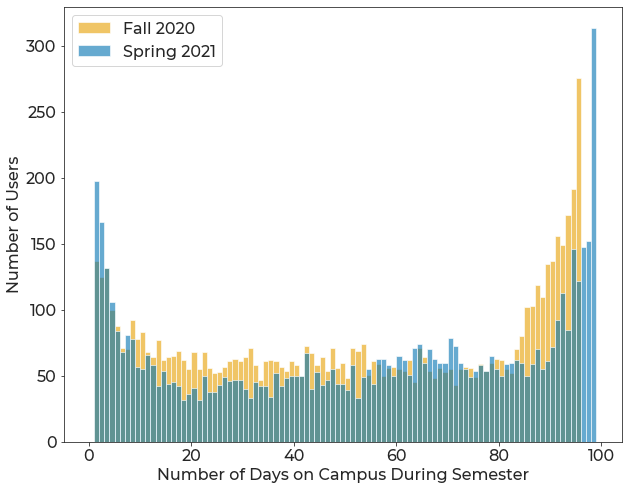

In [35]:
#create the number of users on campus during semester histogram figure
create_numvisits_per_node_chart_sem1(fall_node_list_non_paired,spring_node_list_non_paired)

In [36]:
#group fall interactions and spring interactions files by day
fall_interactions_full = fall_interactions_full.groupby(['day'])
fall_interactions_full = [group for x, group in fall_interactions_full]
spring_interactions_full = spring_interactions_full.groupby(['day'])
spring_interactions_full = [group for x, group in spring_interactions_full]

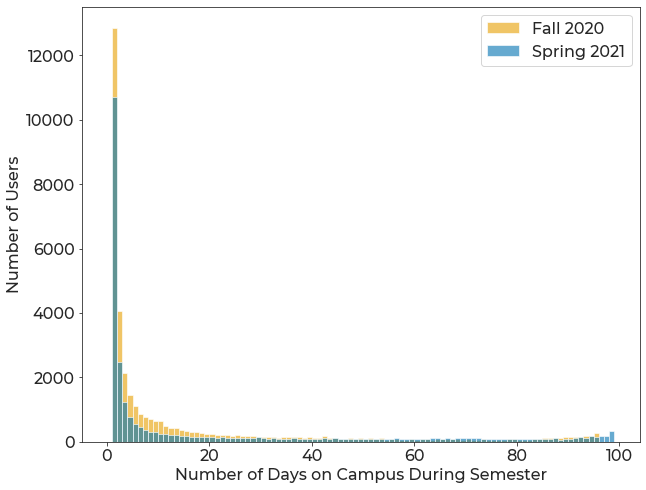

In [37]:
#make histogram for fall and spring before cleaning of guests and students
fall_uncleaned_node_list, fall_uncleaned_node_count, fall_uncleaned_edge_count, days_uncleaned_fall = run_network_to_make_groups_largerfile(fall_interactions_full)
spring_uncleaned_node_list, spring_uncleaned_node_count, spring_uncleaned_edge_count, days_uncleaned_spring = run_network_to_make_groups_largerfile(spring_interactions_full)
create_numvisits_per_node_chart_sem1(fall_uncleaned_node_list,spring_uncleaned_node_list)

In [38]:
#fix up by date pos list to only include students in 10 day list that have been on campus for 10 days
by_date_pos_list_fall_dict = create_by_date_pos_list_without10days(by_date_pos_list_fall,fall_uncleaned_node_list,positives,barcode_to_test_date_dict)  
by_date_pos_list_spring_dict = create_by_date_pos_list_without10days(by_date_pos_list_spring,spring_uncleaned_node_list,positives,barcode_to_test_date_dict)  

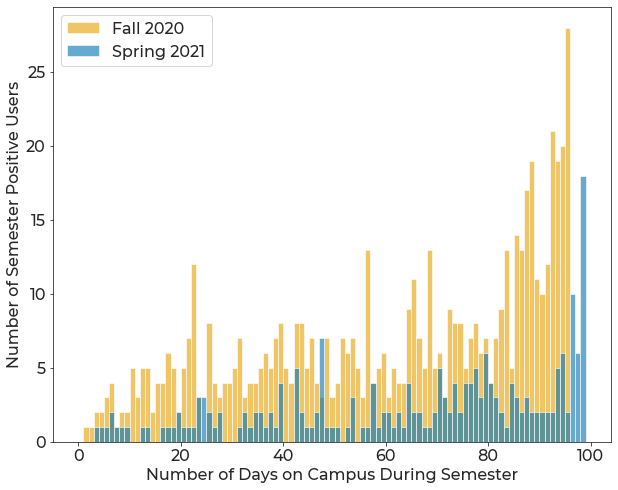

66.0 51.0
76.0 60.0
2409358.0 3.495328128056311e-15
960276.5 1.958897859625189e-09


In [39]:
#make histograms for the number of days on campus for positive users for fall and spring


fall_positive_visits = []
fall_negative_visits = []
for x in fall_node_list_non_paired:
    if x in fall_metadata_of_positives_barcodes:
        fall_positive_visits.append(sum(fall_node_list_non_paired[x][1]))
    else:
        fall_negative_visits.append(sum(fall_node_list_non_paired[x][1]))
        
spring_positive_visits = []
spring_negative_visits = []
for x in spring_node_list_non_paired:
    if x in spring_metadata_of_positives_barcodes:
        spring_positive_visits.append(sum(spring_node_list_non_paired[x][1])) 
    else:
        spring_negative_visits.append(sum(spring_node_list_non_paired[x][1]))
        
plt.figure(figsize = (10,8))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Number of Days on Campus During Semester',fontsize = 16)
plt.ylabel('Number of Semester Positive Users',fontsize = 16)
plt.hist(fall_positive_visits,bins = range(100), color = color_pallet[3],alpha = .6, label = 'Fall 2020')
plt.hist(spring_positive_visits,bins = range(100), color = color_pallet[5],alpha = .6, label = 'Spring 2021')
plt.legend(loc = 'upper left', fontsize = 16,frameon = True)
image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'Supp4C.svg'

plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()

u_fall,p_fall = mannwhitneyu(fall_positive_visits,fall_negative_visits)
u_spring,p_spring = mannwhitneyu(spring_positive_visits,spring_negative_visits)
print(np.median(fall_positive_visits),np.median(fall_negative_visits))
print(np.median(spring_positive_visits),np.median(spring_negative_visits))
print(u_fall,p_fall)
print(u_spring,p_spring)

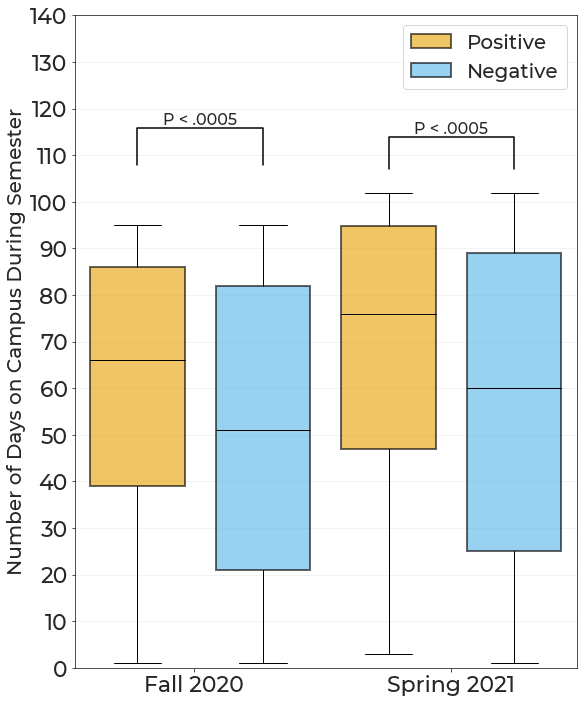

In [40]:
#produce boxplot for # of days on campus for positive vs 
#...negative users with sig bars

fig, ax = plt.subplots(figsize = (9,12))
bp1 = box_plot_no_fliers(fall_positive_visits,color_pallet[3],1)
bp2 = box_plot_no_fliers(fall_negative_visits,color_pallet[4],2)
bp3 = box_plot_no_fliers(spring_positive_visits,color_pallet[3],3)
bp4 = box_plot_no_fliers(spring_negative_visits,color_pallet[4],4)
ax.legend([bp1["boxes"][0], bp2["boxes"][0]],  ['Positive','Negative'],fontsize = 20,frameon=True,loc = 'best')
ax.set_xticks([1.45,3.5])
ax.set_xticklabels(labels = ['Fall 2020','Spring 2021'],fontsize = 22)
ax.set_yticks(np.arange(0,150,step =10))
ax.set_yticklabels(labels = np.arange(0,150,step =10),fontsize = 22)
plt.grid(axis = 'x',visible = False)
plt.grid(axis = 'y',alpha = .3)
ax.set_ylabel('Number of Days on Campus During Semester',fontsize = 20)
barplot_annotate_brackets(0,1,p_fall,[1,2],[100,1],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_spring,[3,4],[100,3],maxasterix=3,fs = 16)
ax.set_ylim(0,140)
image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'new_boxplot_App5.svg'

plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()

In [41]:
#running mann whit test on above boxplot data for pos visits vs neg visits
u_fall,p_fall = mannwhitneyu(fall_positive_visits,fall_negative_visits)
u_spring,p_spring = mannwhitneyu(spring_positive_visits,spring_negative_visits)
print(np.median(fall_positive_visits),np.median(fall_negative_visits))
print(np.median(spring_positive_visits),np.median(spring_negative_visits))
print(u_fall,p_fall)
print(u_spring,p_spring)

66.0 51.0
76.0 60.0
2409358.0 3.495328128056311e-15
960276.5 1.958897859625189e-09


In [42]:
#calculating building duration and interaction counts by building type based on all ap connections (solo and simultaneous)
by_date_building_duration_fall,by_date_building_int_counts_fall,dates_fall = find_proportion_interactions_per_buildingtype_perday(fall_interactions_by_ap_for_counts)
by_date_building_duration_spring,by_date_building_int_counts_spring,dates_spring = find_proportion_interactions_per_buildingtype_perday(spring_interactions_by_ap_for_counts)
by_date_building_int_counts_fall,by_date_building_duration_fall,day_2_DOW_fall  = create_day_of_week(dates_fall,by_date_building_int_counts_fall,by_date_building_duration_fall)
by_date_building_int_counts_spring,by_date_building_duration_spring,day_2_DOW_spring  = create_day_of_week(dates_spring,by_date_building_int_counts_spring,by_date_building_duration_spring)

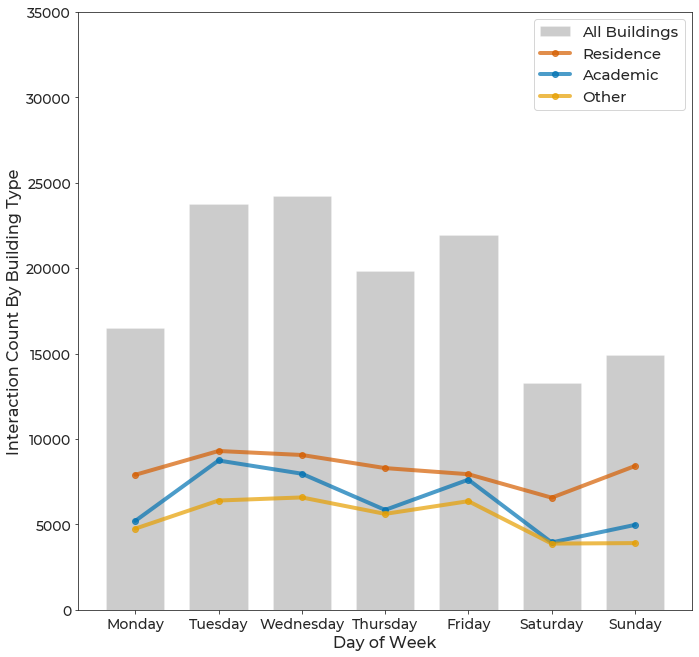

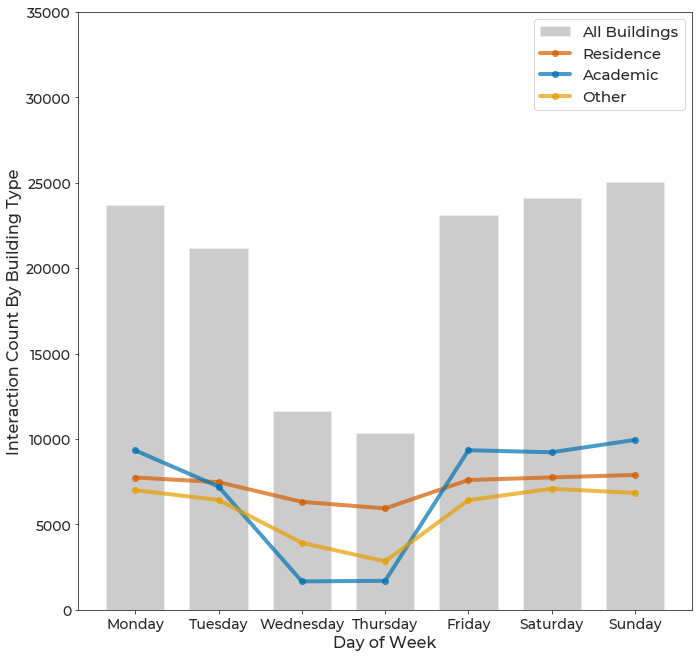

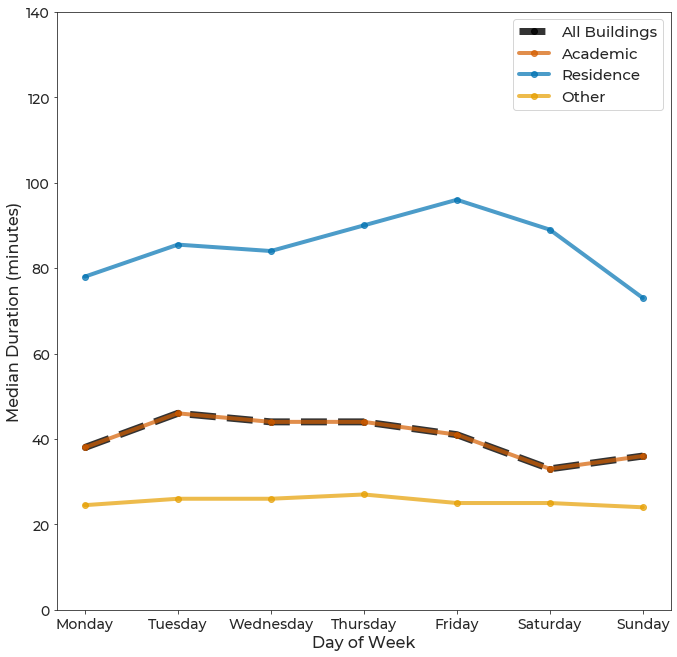

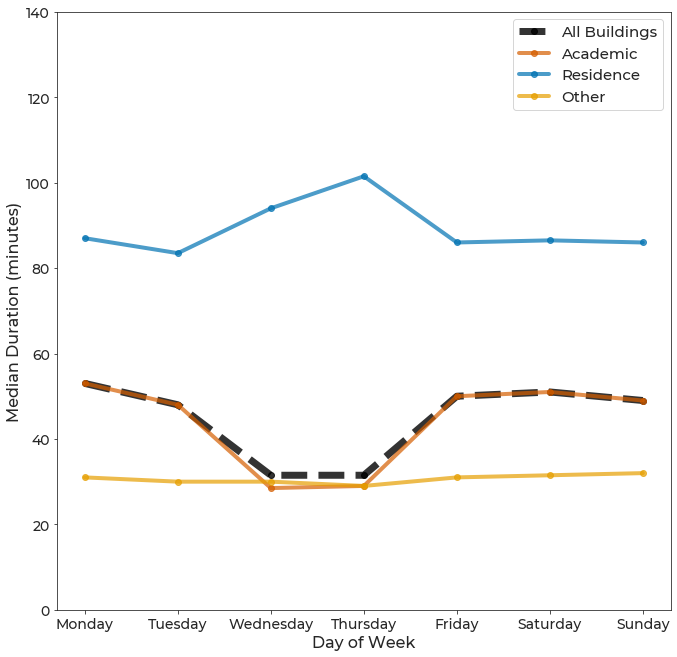

In [43]:
#separating int and duration metrics by building by semester and creating figures
fall_by_date_building_int_counts = create_sem_bydate_buildingcounts_withmedian(by_date_building_int_counts_fall)
spring_by_date_building_int_counts = create_sem_bydate_buildingcounts_withmedian(by_date_building_int_counts_spring)  

fall_by_date_building_duration_med,fall_by_date_building_duration = create_sem_bydate_duration_withmedian(by_date_building_duration_fall)
spring_by_date_building_duration_med,spring_by_date_building_duration = create_sem_bydate_duration_withmedian(by_date_building_duration_spring)
make_sem_chart_building_intcounts(fall_by_date_building_int_counts, 'Fall 2020')
make_sem_chart_building_intcounts(spring_by_date_building_int_counts, 'Spring 2021')


make_sem_chart_building_duration(fall_by_date_building_duration_med, 'Fall 2020',fall_by_date_building_duration)
make_sem_chart_building_duration(spring_by_date_building_duration_med, 'Spring 2021',spring_by_date_building_duration)


In [44]:
#calculating number of contacts, exposure time, and total time per indiv

days = []
node_degree = {}
node_meddur = {}
node_sumdur = {}


print('running')
type_to_color = {0:'b',1:'r'}
for x in final_fall:
    day = x['day'].iloc[0]
    days.append(day)
    g = nx.from_pandas_edgelist(x,'user1','user2',['sum','median','count'], create_using = nx.Graph())
    for node in g:
        degree = g.degree(node)
        if node in node_degree:
            node_degree[node].append(degree)
        else:
            node_degree[node] = [degree]

        sum_duration_list = []
        for info in g.edges(node,data = True):
            sum_duration_list.append(info[2]['sum'])

        if node in node_sumdur:
            node_sumdur[node].append(sum(sum_duration_list))
        else:
            node_sumdur[node] = [sum(sum_duration_list)]

node_expos_time = {}                   
for item,value in node_degree.items() :
    node_expos_time[item] = [value]

for item,value in node_sumdur.items() :
    node_expos_time[item].append(value)

for item, value in node_expos_time.items():
    res = [i / j for i, j in zip(value[1], value[0])]
    node_expos_time[item] = np.median(res)

running


In [46]:
# calculating degree, sum shared duration, and avg exposure time for spring sem
days2 = []
node_degree2 = {}
node_sumdur2 = {}

print('running')
type_to_color = {0:'b',1:'r'}
for x in final_spring:
    day = x['day'].iloc[0]
    days2.append(day)
    g = nx.from_pandas_edgelist(x,'user1','user2',['sum','median','count'], create_using = nx.Graph())
    for node in g:
        degree = g.degree(node)
        if node in node_degree2:
            node_degree2[node].append(degree)
        else:
            node_degree2[node] = [degree]

        sum_duration_list = []
        for info in g.edges(node,data = True):
            sum_duration_list.append(info[2]['sum'])

        if node in node_sumdur2:
            node_sumdur2[node].append(sum(sum_duration_list))
        else:
            node_sumdur2[node] = [sum(sum_duration_list)]

node_expos_time2 = {}                   
for item,value in node_degree2.items() :
    node_expos_time2[item] = [value]

for item,value in node_sumdur2.items() :
    node_expos_time2[item].append(value)

for item, value in node_expos_time2.items():
    res = [i / j for i, j in zip(value[1], value[0])]
    node_expos_time2[item] = np.median(res)

running


In [47]:
#running mann whitney u tests for exposure time for fall and spring
expos_sem = []
expos_sem_neg = []

for item,value in node_expos_time.items():
    if item in list(fall_metadata_of_positives_barcodes):
        expos_sem.append(value)
    else: expos_sem_neg.append(value)
   
        
U1, p_fall = mannwhitneyu(expos_sem, expos_sem_neg)
print('mann whit',p_fall)
print("median pos sem", statistics.median(expos_sem))
print("median neg sem",statistics.median(expos_sem_neg))
print("stdev pos sem",statistics.stdev(expos_sem))
print("stdev neg sem",statistics.stdev(expos_sem_neg))
print()


expos_sem2 = []
expos_sem_neg2 = []

for item,value in node_expos_time2.items():
    if item in list(spring_metadata_of_positives_barcodes):
        expos_sem2.append(value)
    else: expos_sem_neg2.append(value)

      
U1, p_spring = mannwhitneyu(expos_sem2, expos_sem_neg2)
print('mann whit2',p_spring)
print("median pos sem", statistics.median(expos_sem2))
print("median neg sem",statistics.median(expos_sem_neg2))
print("stdev pos sem",statistics.stdev(expos_sem2))
print("stdev neg sem",statistics.stdev(expos_sem_neg2))



mann whit 8.994331771295262e-05
median pos sem 58.073924023992426
median neg sem 49.81666666666666
stdev pos sem 102.34062975733978
stdev neg sem 103.97298429616626

mann whit2 6.692023410630474e-06
median pos sem 77.08122549019609
median neg sem 58.861111111111114
stdev pos sem 97.53092873540479
stdev neg sem 104.83136281081177


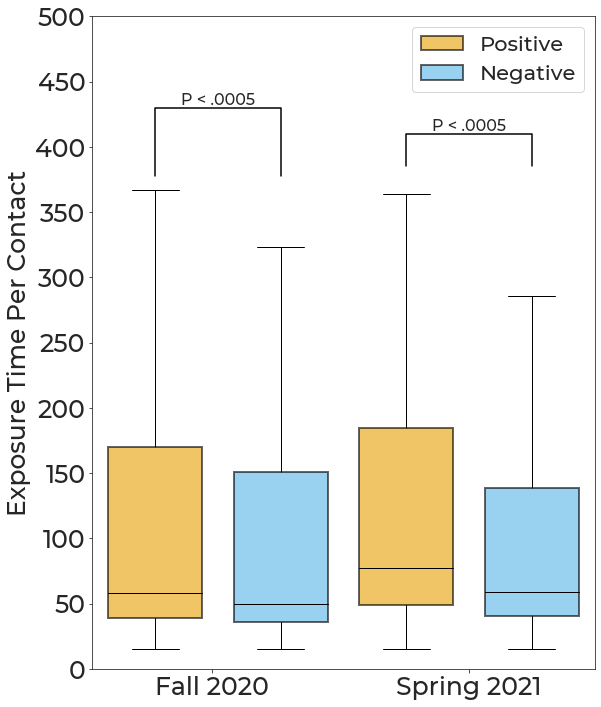

In [48]:
#creating figures based on exposure time with mann whit sig bars
fig, ax = plt.subplots(figsize = (9,12))
bp1 = box_plot_no_fliers(expos_sem,color_pallet[3],1)
bp2 = box_plot_no_fliers(expos_sem_neg,color_pallet[4],2)
bp3 = box_plot_no_fliers(expos_sem2,color_pallet[3],3)
bp4 = box_plot_no_fliers(expos_sem_neg2,color_pallet[4],4)
ax.legend([bp1["boxes"][0], bp2["boxes"][0]],  ['Positive','Negative'],fontsize = 21,frameon=True)
ax.set_xticks([1.45,3.5])
ax.set_xticklabels(labels = ['Fall 2020','Spring 2021'],fontsize = 25)
ax.set_yticks(np.arange(0,1000,step =50))
ax.set_yticklabels(labels = np.arange(0,1000,step =50),fontsize = 25)
plt.grid(axis = 'x',visible = False)
plt.grid(axis = 'y',visible = False)

ax.set_ylabel('Exposure Time Per Contact',fontsize = 25)
barplot_annotate_brackets(0,1,p_fall,[1,2],[325,1],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_spring,[3,4],[360,3],maxasterix=3,fs = 16)
ax.set_ylim(0,500)
image_format = 'svg' 
image_name = 'Main2B.svg'
plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()

In [49]:
#running mann whitney u on node degree (number of contacts per day)
node_deg_sem = []
node_deg_sem_neg = []

for item,value in node_degree.items():
    if item in list(fall_metadata_of_positives_barcodes):
        node_deg_sem.append(np.median(value))
    else: node_deg_sem_neg.append(np.median(value))
   
        
U1, p_fall = mannwhitneyu(node_deg_sem, node_deg_sem_neg)
print('mann whit',p_fall)
print("median pos sem", statistics.median(node_deg_sem))
print("median neg sem",statistics.median(node_deg_sem_neg))
print("stdev pos sem",statistics.stdev(node_deg_sem))
print("stdev neg sem",statistics.stdev(node_deg_sem_neg))
print()

node_deg_sem2 = []
node_deg_sem_neg2 = []

for item,value in node_degree2.items():
    if item in list(spring_metadata_of_positives_barcodes):
        node_deg_sem2.append(np.median(value))
    else: node_deg_sem_neg2.append(np.median(value))
   
        
U1, p_spring = mannwhitneyu(node_deg_sem2, node_deg_sem_neg2)
print('mann whit2',p_spring)
print("median pos sem", statistics.median(node_deg_sem2))
print("median neg sem",statistics.median(node_deg_sem_neg2))
print("stdev pos sem",statistics.stdev(node_deg_sem2))
print("stdev neg sem",statistics.stdev(node_deg_sem_neg2))


mann whit 3.00955253317902e-18
median pos sem 33.5
median neg sem 24.0
stdev pos sem 36.82399462132281
stdev neg sem 31.356103210669072

mann whit2 1.2396772962098242e-06
median pos sem 46.5
median neg sem 34.0
stdev pos sem 37.001410116386104
stdev neg sem 37.0340552219337


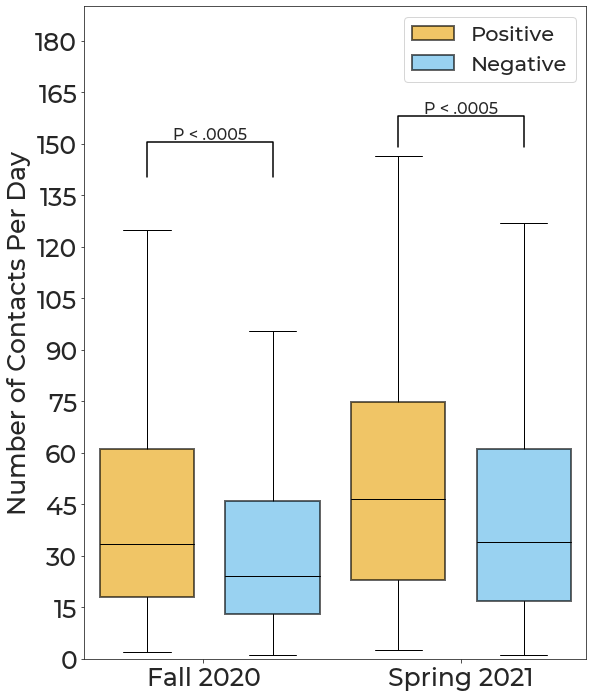

In [50]:
#creating plot for node degree(num contacts)
fig, ax = plt.subplots(figsize = (9,12))
bp1 = box_plot_no_fliers(node_deg_sem,color_pallet[3],1)
bp2 = box_plot_no_fliers(node_deg_sem_neg,color_pallet[4],2)
bp3 = box_plot_no_fliers(node_deg_sem2,color_pallet[3],3)
bp4 = box_plot_no_fliers(node_deg_sem_neg2,color_pallet[4],4)
ax.legend([bp1["boxes"][0], bp2["boxes"][0]],  ['Positive','Negative'],fontsize = 21,frameon = True,loc = 'best')
ax.set_xticks([1.45,3.5])
ax.set_xticklabels(labels = ['Fall 2020','Spring 2021'],fontsize = 25)
ax.set_yticks(np.arange(0,185,step =15))
ax.set_yticklabels(labels = np.arange(0,185,step =15),fontsize = 25)
plt.grid(axis = 'x',visible = False)
plt.grid(axis = 'y',visible = False)
ax.set_ylabel('Number of Contacts Per Day',fontsize = 25)
barplot_annotate_brackets(0,1,p_fall,[1,2],[130,1],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_spring,[3,4],[140,3],maxasterix=3,fs = 16)
ax.set_ylim(0,190)
image_format = 'svg' 
image_name = 'Main2A.svg'
plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()


In [51]:
#running sum duration and median duration shared contact for rolling window positives versus other groupings
rolling_positives_pn_meddur = []
rolling_positives_pp_sumdur = []
rolling_positives_pn_sumdur = []
rolling_positives_nn_meddur = []
rolling_positives_pp_meddur = []
rolling_positives_nn_sumdur = []
edge_list = []
print('running')
days = []
for j in final_fall:
    day = j['day'].iloc[0]
    days.append(day)
    g = nx.from_pandas_edgelist(j,'user1','user2',['sum','median','count'], create_using = nx.Graph())
    rolling_positives = by_date_pos_list_fall_dict[str(day)]
    sem_positives = list(fall_metadata_of_positives_barcodes)
    edges = list(g.edges(data = True))
    for x in edges:
        edge_list.append(x[0])
        edge_list.append(x[1])
        if str(x[0]) in rolling_positives:
            if str(x[1]) in rolling_positives:
                rolling_positives_pp_sumdur.append(x[2]['sum'])
                rolling_positives_pp_meddur.append(x[2]['median'])
            else : 
                rolling_positives_pn_sumdur.append(x[2]['sum'])
                rolling_positives_pn_meddur.append(x[2]['median'])
        else:
            if x[1] in rolling_positives:
                rolling_positives_pn_sumdur.append(x[2]['sum'])
                rolling_positives_pn_meddur.append(x[2]['median'])
            else:
                rolling_positives_nn_sumdur.append(x[2]['sum'])
                rolling_positives_nn_meddur.append(x[2]['median'])

running


In [52]:
#running sum duration and median duration shared contact for rolling window positives versus other groupings for spring
rolling_positives_pn_meddur2 = []
rolling_positives_pp_sumdur2 = []
rolling_positives_pn_sumdur2 = []
rolling_positives_nn_meddur2 = []
rolling_positives_pp_meddur2 = []
rolling_positives_nn_sumdur2 = []
edge_list2 = []
print('running')
days = []
for j in final_spring:
    day = j['day'].iloc[0]
    g = nx.from_pandas_edgelist(j,'user1','user2',['sum','median','count'], create_using = nx.Graph())
    rolling_positives = by_date_pos_list_spring_dict[str(day)]
    sem_positives = list(spring_metadata_of_positives_barcodes)
    edges = list(g.edges(data = True))
    for x in edges:
        edge_list2.append(x[0])
        edge_list2.append(x[1])
        if str(x[0]) in rolling_positives:
            if str(x[1]) in rolling_positives:
                rolling_positives_pp_sumdur2.append(x[2]['sum'])
                rolling_positives_pp_meddur2.append(x[2]['median'])
            else : 
                rolling_positives_pn_sumdur2.append(x[2]['sum'])
                rolling_positives_pn_meddur2.append(x[2]['median'])
        else:
            if x[1] in rolling_positives:
                rolling_positives_pn_sumdur2.append(x[2]['sum'])
                rolling_positives_pn_meddur2.append(x[2]['median'])
            else:
                rolling_positives_nn_sumdur2.append(x[2]['sum'])
                rolling_positives_nn_meddur2.append(x[2]['median'])

running


In [53]:
#testing significance of rolling window comparisons for sum shared contact time
U1, p_pp_pn_fall = mannwhitneyu(rolling_positives_pp_sumdur, rolling_positives_pn_sumdur)
print('pp-pn',p_pp_pn_fall)

U1, p_pp_nn_fall = mannwhitneyu(rolling_positives_pp_sumdur, rolling_positives_nn_sumdur)
print('pp-nn',p_pp_nn_fall)

U1, p_pn_nn_fall = mannwhitneyu(rolling_positives_pn_sumdur, rolling_positives_nn_sumdur)
print('pn-nn',p_pn_nn_fall)

U1, p_pp_pn_spring = mannwhitneyu(rolling_positives_pp_sumdur2, rolling_positives_pn_sumdur2)
print('pp-pn',p_pp_pn_spring)

U1, p_pp_nn_spring = mannwhitneyu(rolling_positives_pp_sumdur2, rolling_positives_nn_sumdur2)
print('pp-nn',p_pp_nn_spring)

U1, p_pn_nn_spring = mannwhitneyu(rolling_positives_pn_sumdur2, rolling_positives_nn_sumdur2)
print('pn-nn',p_pn_nn_spring)

pp-pn 9.161291692594887e-23
pp-nn 7.091091824758699e-68
pn-nn 0.0
pp-pn 3.090927948731482e-55
pp-nn 4.7849183167061985e-63
pn-nn 9.028259056406655e-18


In [54]:
#calculating median subgroup connection times
print('fall 2020')
print("median pp sem", statistics.median(rolling_positives_pp_sumdur))
print("median pn sem", statistics.median(rolling_positives_pn_sumdur))
print("median nn sem",statistics.median(rolling_positives_nn_sumdur))
print("stdev pp sem",statistics.stdev(rolling_positives_pp_sumdur))
print("stdev pn sem",statistics.stdev(rolling_positives_pn_sumdur))
print("stdev n sem",statistics.stdev(rolling_positives_nn_sumdur))

print('spring 2021')
print("median pp sem", statistics.median(rolling_positives_pp_sumdur2))
print("median pn sem", statistics.median(rolling_positives_pn_sumdur2))
print("median nn sem",statistics.median(rolling_positives_nn_sumdur2))
print("stdev pp sem",statistics.stdev(rolling_positives_pp_sumdur2))
print("stdev pn sem",statistics.stdev(rolling_positives_pn_sumdur2))
print("stdev n sem",statistics.stdev(rolling_positives_nn_sumdur2))

fall 2020
median pp sem 62.0
median pn sem 50.0
median nn sem 45.0
stdev pp sem 331.6559093496501
stdev pn sem 302.70437060447705
stdev n sem 279.1962048506829
spring 2021
median pp sem 111.0
median pn sem 50.0
median nn sem 49.0
stdev pp sem 432.13981836860785
stdev pn sem 292.6742189687707
stdev n sem 273.11619081085


KeyboardInterrupt: 

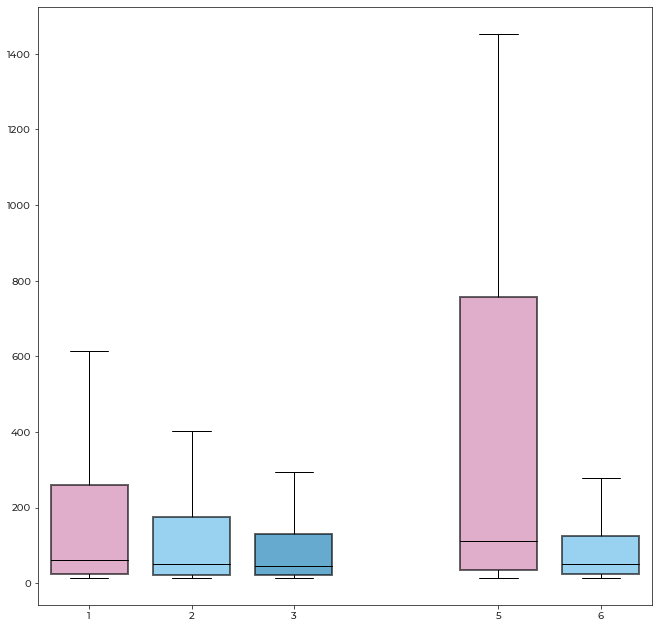

In [55]:
#creating figures for total interaction time comparisons calculated above
bp1 = fig, ax = plt.subplots(figsize = (11,11))
bp1 = box_plot_no_fliers(rolling_positives_pp_sumdur,color_pallet[2],1)
bp2 = box_plot_no_fliers(rolling_positives_pn_sumdur,color_pallet[4],2)
bp3 = box_plot_no_fliers(rolling_positives_nn_sumdur,color_pallet[5],3)
bp4 = box_plot_no_fliers(rolling_positives_pp_sumdur2,color_pallet[2],5)
bp5 = box_plot_no_fliers(rolling_positives_pn_sumdur2,color_pallet[4],6)
bp6 = box_plot_no_fliers(rolling_positives_nn_sumdur2,color_pallet[5],7)
plt.grid(axis = 'x',visible = False)
ax.set_xticks([2.02,6.02])
ax.set_yticks(np.arange(0,2000,step =100))
ax.set_yticklabels(labels = np.arange(0,2000,step =100),fontsize = 22)
ax.set_xticklabels(labels = ['Fall 2020','Spring 2021'],fontsize = 22)
ax.set_ylabel('Total Interaction Duration Per Pair Per Day (minutes)',fontsize = 15)
ax.legend([bp1["boxes"][0], bp2["boxes"][0],bp3["boxes"][0]], ['Positive/Positive','Positive/Negative', 'Negative/Negative'],fontsize = 16,loc = 'best',frameon=True)
barplot_annotate_brackets(0,1,p_pp_pn_fall,[1,1.97],[550,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_pn_nn_fall,[2.03,3.05],[550,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_pp_nn_fall,[1.0,3.05],[750,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_pp_pn_spring,[5,5.98],[1400,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_pn_nn_spring,[6.02,7.05],[1300,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_pp_nn_spring,[5.0,7.05],[1550,5],maxasterix=3,fs = 16)
image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'Supp7D2.svg'
plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()

In [ ]:
#running mann whit on median shared connection time based on subgroup
U1, p_pp_pn_fall = mannwhitneyu(rolling_positives_pp_meddur, rolling_positives_pn_meddur)
print('pp-pn',p_pp_pn_fall)

U1, p_pp_nn_fall = mannwhitneyu(rolling_positives_pp_meddur, rolling_positives_nn_meddur)
print('pp-nn',p_pp_nn_fall)

U1, p_pn_nn_fall = mannwhitneyu(rolling_positives_pn_meddur, rolling_positives_nn_meddur)
print('pn-nn',p_pn_nn_fall)

U1, p_pp_pn_spring = mannwhitneyu(rolling_positives_pp_meddur2, rolling_positives_pn_meddur2)
print('pp-pn',p_pp_pn_spring)

U1, p_pp_nn_spring = mannwhitneyu(rolling_positives_pp_meddur2, rolling_positives_nn_meddur2)
print('pp-nn',p_pp_nn_spring)

U1, p_pn_nn_spring = mannwhitneyu(rolling_positives_pn_meddur2, rolling_positives_nn_meddur2)
print('pn-nn',p_pn_nn_spring)

NameError: name 'rolling_positives_pp_meddur' is not defined

NameError: name 'rolling_positives_pp_meddur' is not defined

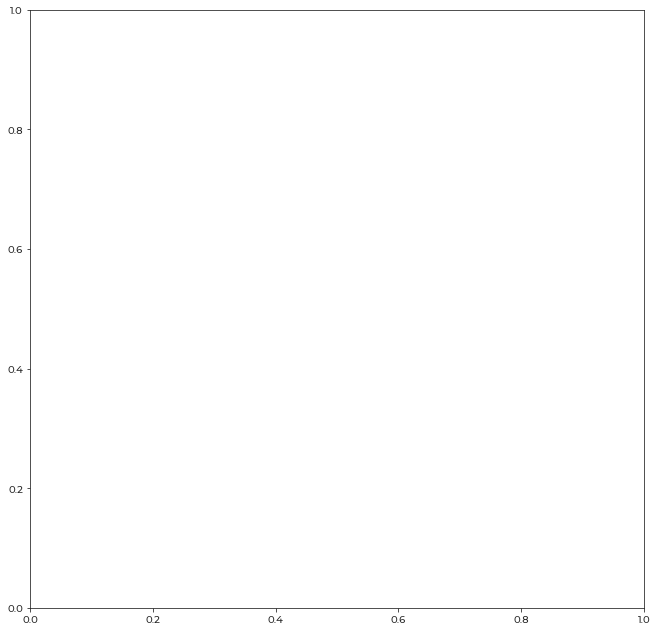

In [ ]:
#creating boxplots for median time spent based on subcategory of testing status
bp1 = fig, ax = plt.subplots(figsize = (11,11))
bp1 = box_plot_no_fliers(rolling_positives_pp_meddur,color_pallet[2],1)
bp2 = box_plot_no_fliers(rolling_positives_pn_meddur,color_pallet[4],2)
bp3 = box_plot_no_fliers(rolling_positives_nn_meddur,color_pallet[5],3)
bp4 = box_plot_no_fliers(rolling_positives_pp_meddur2,color_pallet[2],5)
bp5 = box_plot_no_fliers(rolling_positives_pn_meddur2,color_pallet[4],6)
bp6 = box_plot_no_fliers(rolling_positives_nn_meddur2,color_pallet[5],7)
plt.grid(axis = 'x',visible = False)
plt.grid(axis = 'y',alpha = .3)
ax.set_xticks([2.02,6.02])
ax.set_xticklabels(labels = ['Fall 2020','Spring 2021'],fontsize = 17)
ax.set_ylabel('Median Interaction Duration Per Pair',fontsize = 17)
ax.set_yticks(np.arange(0,800,step =20))
ax.set_yticklabels(labels = np.arange(0,800,step =20),fontsize = 18)
ax.legend([bp1["boxes"][0], bp2["boxes"][0],bp3["boxes"][0]], ['Positive/Positive','Positive/Negative', 'Negative/Negative'],fontsize = 16,loc = 'best',frameon=True)
barplot_annotate_brackets(0,1,p_pp_pn_fall,[1,1.97],[300,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_pn_nn_fall,[2.03,3.05],[310,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_pp_nn_fall,[1.0,3.05],[370,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_pp_pn_spring,[5,5.98],[340,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_pn_nn_spring,[6.02,7.05],[330,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_pp_nn_spring,[5.0,7.05],[375,5],maxasterix=3,fs = 16)
image_format = 'svg' # e.g .png, .svg, etc.
ax.set_ylim(0,540)
image_name = 'Supp7E2.svg'
plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()

In [ ]:
#producing medians for median time spent based on subgroup status

print('fall 2020')
print("median pp sem", statistics.median(rolling_positives_pp_meddur))
print("median pn sem", statistics.median(rolling_positives_pn_meddur))
print("median nn sem",statistics.median(rolling_positives_nn_meddur))
print("stdev pp sem",statistics.stdev(rolling_positives_pp_meddur))
print("stdev pn sem",statistics.stdev(rolling_positives_pn_meddur))
print("stdev n sem",statistics.stdev(rolling_positives_nn_meddur))

print('spring 2021')
print("median pp sem", statistics.median(rolling_positives_pp_meddur2))
print("median pn sem", statistics.median(rolling_positives_pn_meddur2))
print("median nn sem",statistics.median(rolling_positives_nn_meddur2))
print("stdev pp sem",statistics.stdev(rolling_positives_pp_meddur2))
print("stdev pn sem",statistics.stdev(rolling_positives_pn_meddur2))
print("stdev n sem",statistics.stdev(rolling_positives_nn_meddur2))


fall 2020


NameError: name 'rolling_positives_pp_meddur' is not defined

In [ ]:
#testing significance of median time spent between subgroups
U1, p = mannwhitneyu(rolling_positives_pp_meddur, rolling_positives_pn_meddur)
print('pp-pn',p)

U1, p = mannwhitneyu(rolling_positives_pp_meddur, rolling_positives_nn_meddur)
print('pp-nn',p)

U1, p = mannwhitneyu(rolling_positives_pn_meddur, rolling_positives_nn_meddur)
print('nn-pn',p)


U1, p = mannwhitneyu(rolling_positives_pp_meddur2, rolling_positives_pn_meddur2)
print('pp-pn',p)

U1, p = mannwhitneyu(rolling_positives_pp_meddur2, rolling_positives_nn_meddur2)
print('pp-nn',p)

U1, p = mannwhitneyu(rolling_positives_pn_meddur2, rolling_positives_nn_meddur2)
print('nn-pn',p)

NameError: name 'rolling_positives_pp_meddur' is not defined

In [ ]:
#making placeholder array
holder_counter = []

In [ ]:
#creating files for outbreaker testing
fall_keep_list = make_diff_list(final_fall,fall_metadata_of_positives_barcodes)
spring_keep_list = make_diff_list(final_spring,spring_metadata_of_positives_barcodes)
fall_keeps = pd.DataFrame(data = fall_keep_list, columns = ['user1','user2','interaction date','user1 test date','user2 test date','test days diff','int days before user1 test','int days before user2 test'])
spring_keeps = pd.DataFrame(data = spring_keep_list, columns = ['user1','user2','interaction date','user1 test date','user2 test date','test days diff','int days before user1 test','int days before user2 test'])
fall_keeps['test days diff'] = [abs(x) for x in fall_keeps['test days diff']]
spring_keeps['test days diff'] = [abs(x) for x in spring_keeps['test days diff']]
fall_keeps.to_csv('fall_twelveday.csv',index = False)
spring_keeps.to_csv('spring_twelveday.csv',index = False)


In [ ]:
#make day by day lists for on campus pos and neg
counter_neg_list_f, counter_pos_list_f,fall_days = make_dist_charts_data(fall_interactions_by_ap_for_counts,fall_metadata_of_positives_barcodes)
counter_neg_list_s, counter_pos_list_s,spring_days = make_dist_charts_data(spring_interactions_by_ap_for_counts,spring_metadata_of_positives_barcodes)

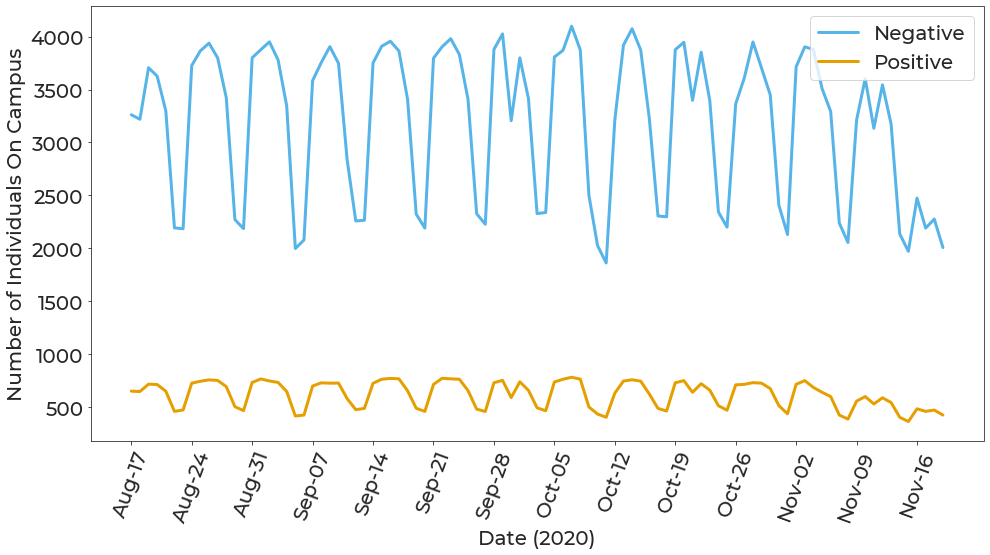

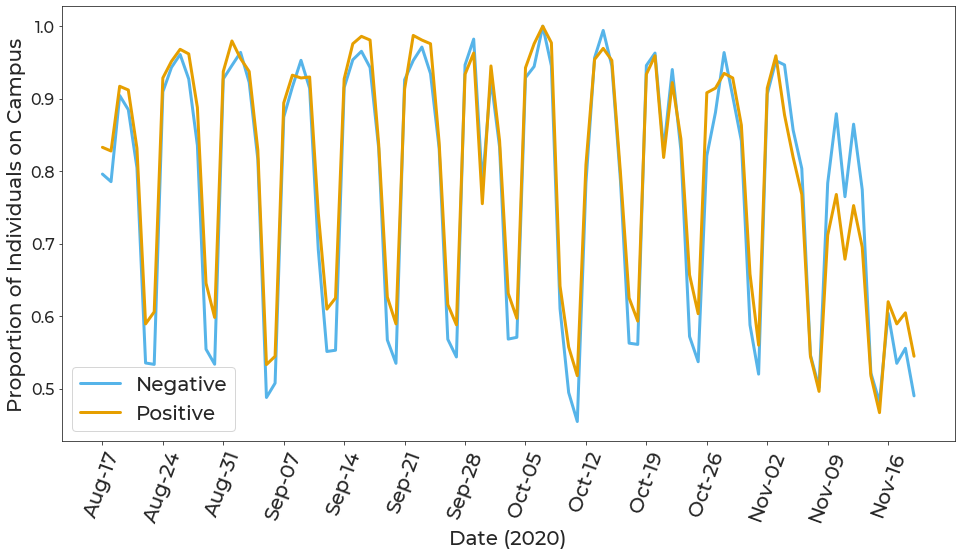

4104.5 0.282291201521357
(0.9760025550428193, 2.2837283787169615e-63)


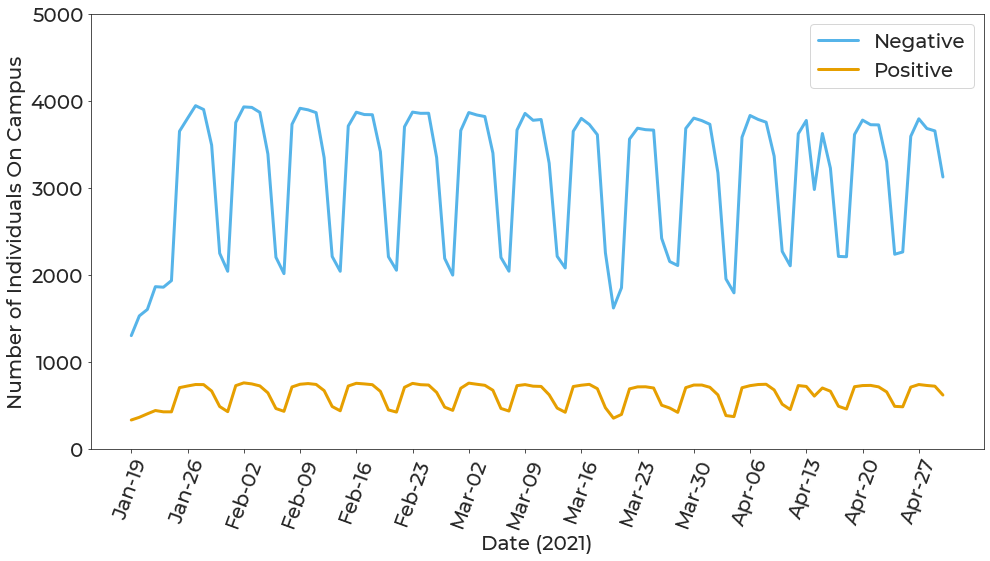

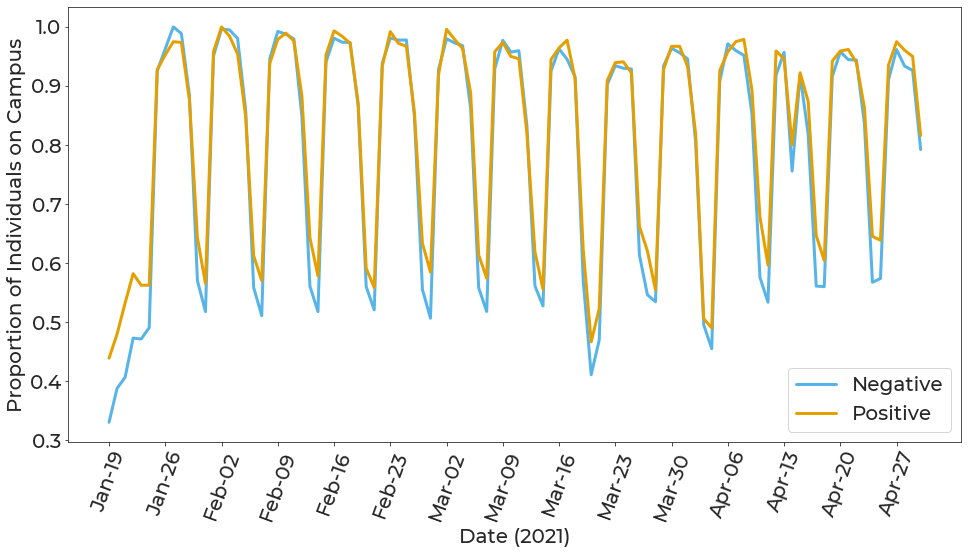

4715.5 0.24899118351797467
(0.99450284093424, 7.977178027564443e-100)


In [ ]:
#make figures based on day by day lists
create_dist_chart_sem1(counter_pos_list_f,counter_neg_list_f,fall_days)
create_dist_chart_sem2(counter_pos_list_s,counter_neg_list_s,spring_days)

In [ ]:
#examine contact tracing pairs and directionality (make dataframe to analyze)

ct_dataframe = pd.DataFrame(columns = ['contact_pair','type'])

pairings = []
pairings_indirect = []
source_contacts = []
receiver_contacts = []

for index,row in ct_data.dropna()[['barcode','IDs']].iterrows():
    res = row['IDs'].replace('\'','').strip('][').split(', ')
    if row['barcode'] not in source_contacts:
        source_contacts.append(row['barcode'])
    for contact in res:
        if contact not in receiver_contacts:
            receiver_contacts.append(contact)
        pairing = [row['barcode'],contact]
        pairings.append(sorted(pairing))


for x in pairings:
    ct_dataframe.loc[len(ct_dataframe.index)] = [x,'direct_pair']

ct_dataframe_pairings = pd.DataFrame(ct_dataframe['contact_pair'].tolist(),columns = ['Source','Target'])
ct_dataframe = pd.concat([ct_dataframe, ct_dataframe_pairings.reindex(ct_dataframe.index)], axis=1)
ct_dataframe = ct_dataframe[['Source','Target','type','contact_pair']]

contact_list = list(list(set(ct_dataframe.Source.values)) + list(set(ct_dataframe.Target.values)))
contact_list
ct_dataframe.columns = ['c1','c2','type','contact_pair']
ct_dataframe.to_excel('ct_dataframe_ready_for_network.xlsx',columns = ['c1','c2','type'],index = False)
ct_dataframe['contact_pair_string'] = [str(x) for x in ct_dataframe['contact_pair']]

ct_dict = ct_dataframe.set_index('contact_pair_string')['type'].to_dict()

ct_dataframe

c1         c2         type            contact_pair  \
0    PB5NAM51D  PBHHU83VD  direct_pair  [PB5NAM51D, PBHHU83VD]   
1    PB3RNGH6D  PBHHU83VD  direct_pair  [PB3RNGH6D, PBHHU83VD]   
2    PBP1MK82R  PBTM6HM9F  direct_pair  [PBP1MK82R, PBTM6HM9F]   
3    PBSP8TV2V  PBTM6HM9F  direct_pair  [PBSP8TV2V, PBTM6HM9F]   
4    PB4F5FVM8  PBHFQJWE6  direct_pair  [PB4F5FVM8, PBHFQJWE6]   
..         ...        ...          ...                     ...   
554  PB7S28R2A  PBF9RA1UC  direct_pair  [PB7S28R2A, PBF9RA1UC]   
555  PB7S28R2A  PBBJHBD8B  direct_pair  [PB7S28R2A, PBBJHBD8B]   
556  PBBJHBD8B  PBF9RA1UC  direct_pair  [PBBJHBD8B, PBF9RA1UC]   
557  PB7S28R2A  PBF9RA1UC  direct_pair  [PB7S28R2A, PBF9RA1UC]   
558  PBBJHBD8B  PBF9RA1UC  direct_pair  [PBBJHBD8B, PBF9RA1UC]   

            contact_pair_string  
0    ['PB5NAM51D', 'PBHHU83VD']  
1    ['PB3RNGH6D', 'PBHHU83VD']  
2    ['PBP1MK82R', 'PBTM6HM9F']  
3    ['PBSP8TV2V', 'PBTM6HM9F']  
4    ['PB4F5FVM8', 'PBHFQJWE6']  
..                          ...  
554  ['PB7S28R2A', 'PBF9RA1UC']  
555  ['PB7S28R2A', 'PBBJHBD8B']  
556  ['PBBJHBD8B', 'PBF9RA1UC']  
557  ['PB7S28R2A', 'PBF9RA1UC']  
558  ['PBBJHBD8B', 'PBF9RA1UC']  

[559 rows x 5 columns]

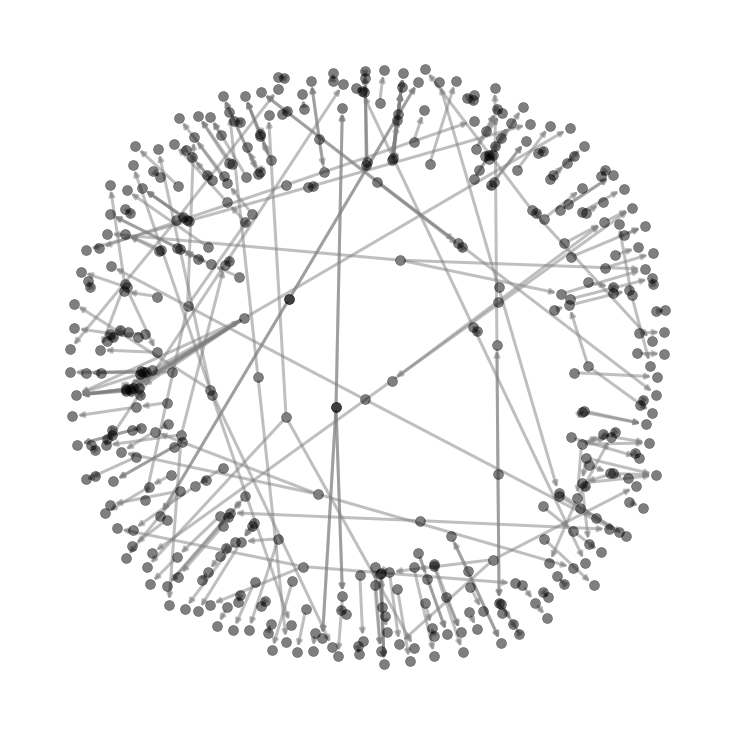

In [ ]:
#make network to look at contact tracing pairs and directionality

g = nx.from_pandas_edgelist(ct_dataframe,'c1','c2',['type'],create_using=nx.DiGraph())
edge_dict = {'direct_and_indirect_pair':'green','direct_pair':'grey','indirect_pair':'red',}
colors = [edge_dict[g[u][v]['type']] for u,v in g.edges()]
plt.figure(figsize = (10,10))
nx.draw(g,pos =nx.spring_layout(g,seed = 1),edge_color=colors,with_labels = False,width = 3,node_color = 'black',node_size = 100,alpha = .5,linewidths = .5,font_size = 14)
#nx.draw(g,pos =nx.graphviz_layout(g, prog='dot'),edge_color=colors,with_labels = False,width = 3,node_color = color_map,node_size = 100,alpha = .6,linewidths = .5,font_size = 14)

plt.show()


original = g.copy()

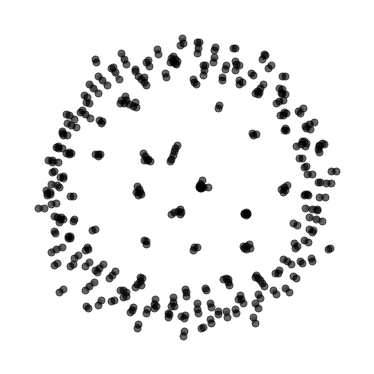

In [ ]:
#look at undirected contact tracing clusters

undirected = original.to_undirected()
plt.figure(figsize = (5,5))
nx.draw(undirected,pos =nx.spring_layout(undirected,seed = 27),with_labels = False,width = 5,node_size = 50,alpha = .6,linewidths = .9,edge_color = 'grey',node_color = 'black',font_size = 14)
plt.show()

counter = 0
ct_groupings = {}
for x in nx.connected_components(undirected):
    for node in x:
        ct_groupings[node] = counter
    counter+=1


In [ ]:
#make a by date pos list based only on contact tracing positives

by_date_pos_list_CT_dict_FALL = {}
by_date_pos_list_CT_dict_SPRING = {}
for x in by_date_pos_list_fall_dict:
    by_date_pos_list_CT_dict_FALL[x] = []
    for node in by_date_pos_list_fall_dict[x]:
        if node in ct_groupings:
            by_date_pos_list_CT_dict_FALL[x].append(node)

for x in by_date_pos_list_spring_dict:
    by_date_pos_list_CT_dict_SPRING[x] = []
    for node in by_date_pos_list_spring_dict[x]:
        if node in ct_groupings:
            by_date_pos_list_CT_dict_SPRING[x].append(node)

In [ ]:
#make lists of barcodes of only contact traced positives in the respective semesters

fall_metadata_of_CT_positives_barcodes = []
for x in fall_metadata_of_positives_barcodes:
    if x in ct_groupings.keys():
        fall_metadata_of_CT_positives_barcodes.append(x)

spring_metadata_of_CT_positives_barcodes = []
for x in spring_metadata_of_positives_barcodes:
    if x in ct_groupings.keys():
        spring_metadata_of_CT_positives_barcodes.append(x)

In [ ]:
#CT analysis with attribute assortativity and 10 day rolling window
print('running')
rolling_pos_att,holder_counter,lower_ci_95_rolling, higher_ci_95_rolling,days,counter_neg_list,counter_pos_list = pos_att_network_sem_test_CT_scenario1(final_fall,by_date_pos_list_fall_dict,True,holder_counter,'Rolling Count of Positive Attribute Individuals versus Negative Attribute Individuals: Fall 2020')


running


c:\Users\brync\anaconda3\lib\site-packages\networkx\algorithms\assortativity\correlation.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


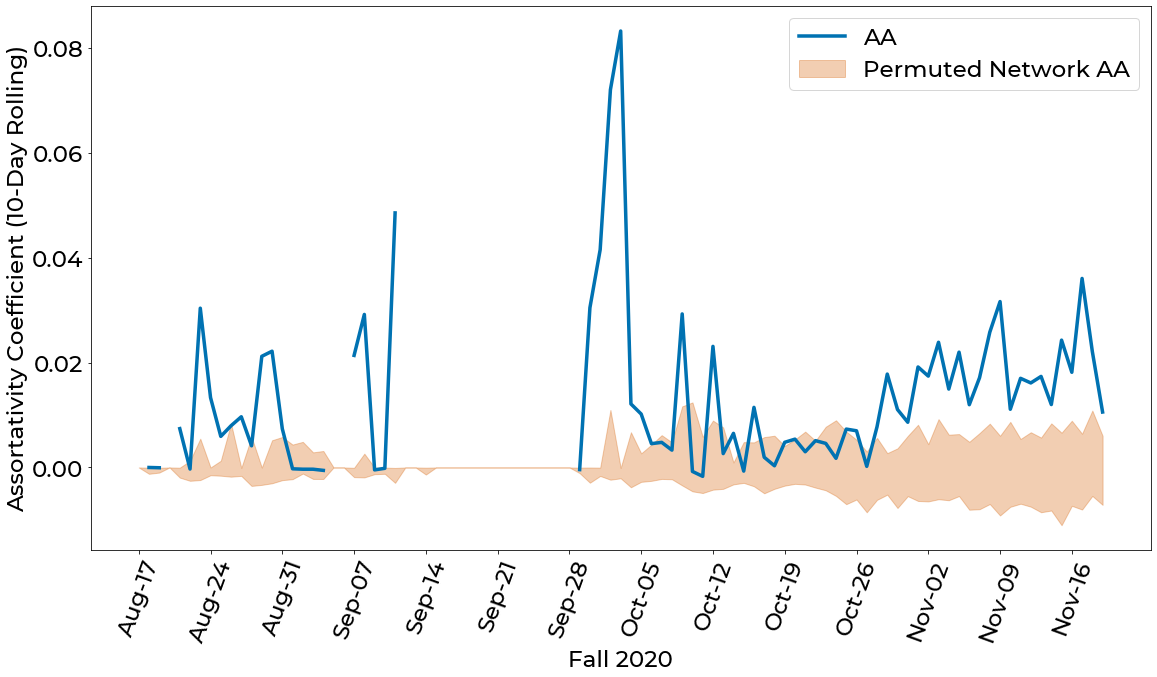

23 72 95


In [ ]:
#contact tracing based AA figure 

make_AA_charts(days,rolling_pos_att,lower_ci_95_rolling,higher_ci_95_rolling,'Rolling 10 Day Window Positives and Permuted Rolling 10 Day Window Positives, Attribute Assortativity: 8/17/2020-11/23/2020',color_pallet[5],"AA","Permuted Network AA",' (10-Day Rolling)')

In [ ]:
#non ct AA analysis

print('running')
rolling_pos_att,holder_counter,lower_ci_95_rolling, higher_ci_95_rolling,days,counter_neg_list,counter_pos_list = pos_att_network_sem_test_CT_scenario2(final_fall,by_date_pos_list_fall_dict,True,holder_counter,'Rolling Count of Positive Attribute Individuals versus Negative Attribute Individuals: Fall 2020')


running


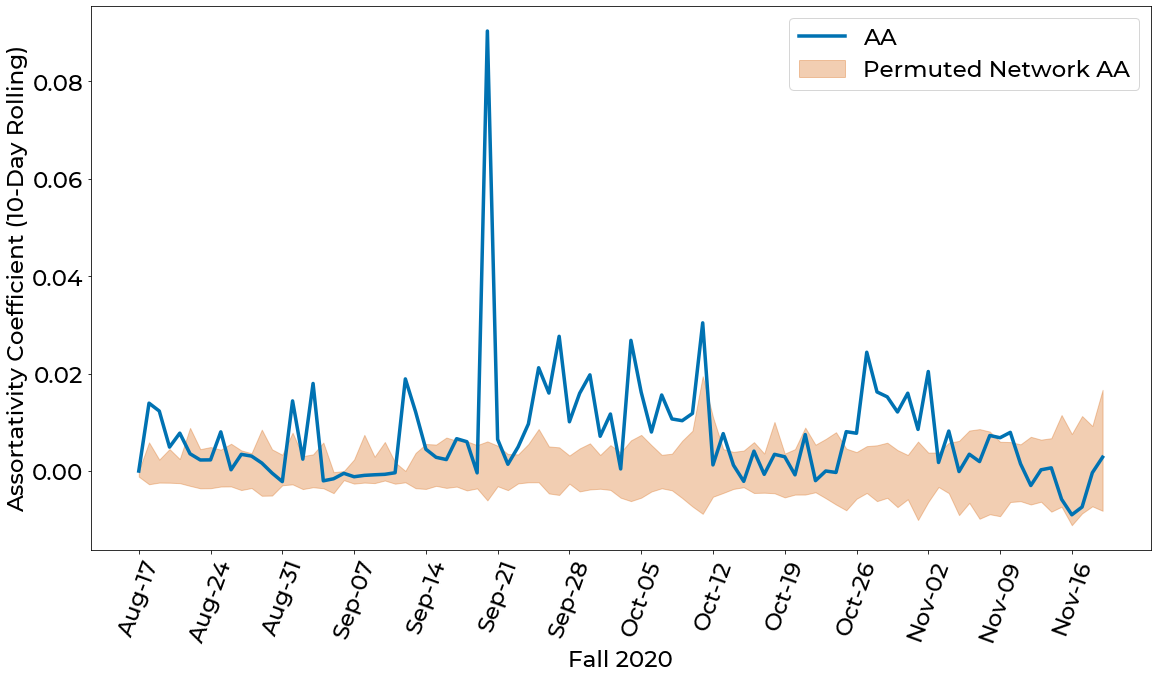

52 43 95


In [ ]:
#non ct AA figure

make_AA_charts(days,rolling_pos_att,lower_ci_95_rolling,higher_ci_95_rolling,'Rolling 10 Day Window Positives and Permuted Rolling 10 Day Window Positives, Attribute Assortativity: 8/17/2020-11/23/2020',color_pallet[5],"AA","Permuted Network AA",' (10-Day Rolling)')

In [ ]:
#CT and non Contact traced (CT) AA analysis for rolling and non-rolling

print('running')
rolling_pos_att,holder_counter,lower_ci_95_rolling, higher_ci_95_rolling,days,counter_neg_list,counter_pos_list = pos_att_network_sem_test(final_fall,by_date_pos_list_fall_dict,True,holder_counter,'Rolling Count of Positive Attribute Individuals versus Negative Attribute Individuals: Fall 2020')
print('halfway')
sem1_pos_att,holder_counter,lower_ci_95_sem1, higher_ci_95_sem1,days,counter_neg_list,counter_pos_list = pos_att_network_sem_test(final_fall,fall_metadata_of_positives_barcodes,False,holder_counter,'Sem1 Non-Rolling Count of Positive Attribute Individuals On Campus Versus Negative Attribute Individuals On Campus: Fall 2020')

running


c:\Users\brync\anaconda3\lib\site-packages\networkx\algorithms\assortativity\correlation.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


halfway


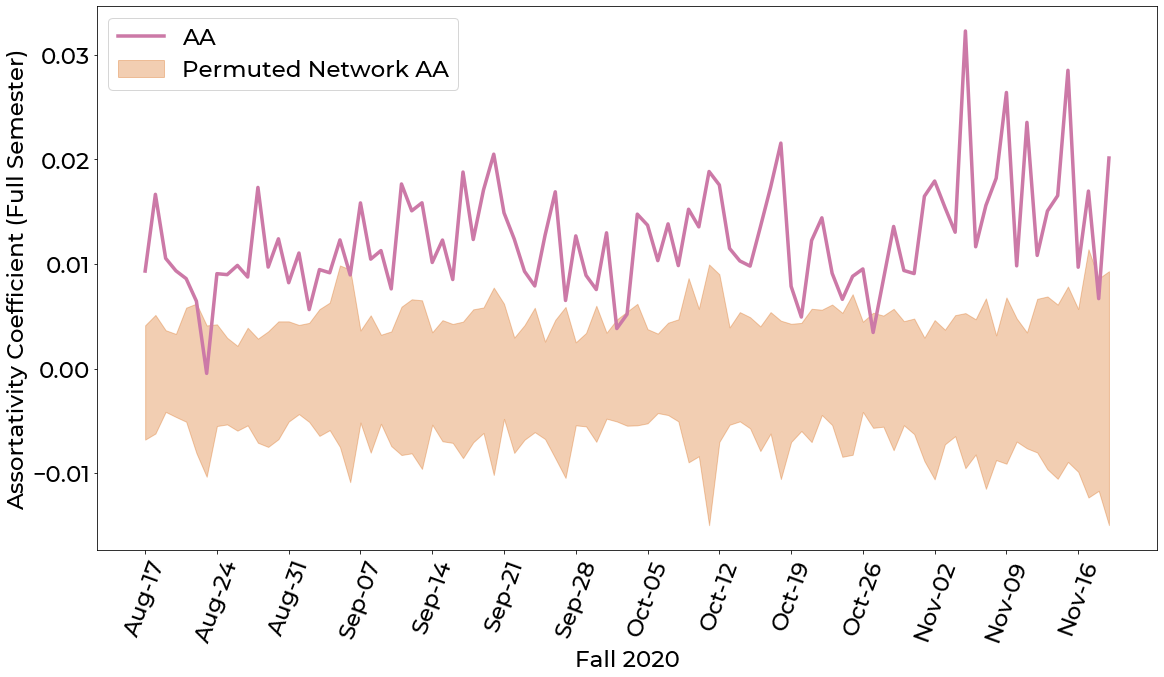

6 89 95


In [ ]:
#Ct and non CT AA charts

make_AA_charts(days,sem1_pos_att,lower_ci_95_sem1,higher_ci_95_sem1,'First Sem Positives and Permuted First Sem Positives, Attribute Assortativity: 8/17/2020-11/23/2020',color_pallet[2],"AA","Permuted Network AA",' (Full Semester)')
make_AA_charts(days,rolling_pos_att,lower_ci_95_rolling,higher_ci_95_rolling,'Rolling 10 Day Window Positives and Permuted Rolling 10 Day Window Positives, Attribute Assortativity: 8/17/2020-11/23/2020',color_pallet[5],"AA","Permuted Network AA",' (10-Day Rolling)')

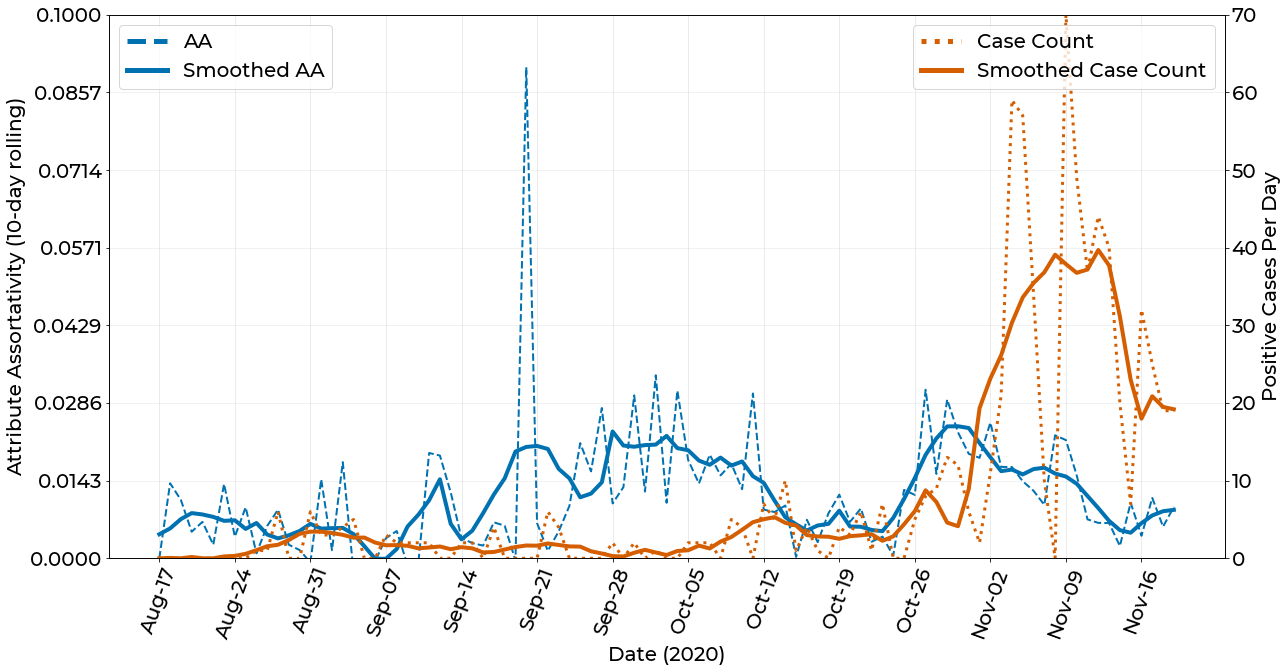

unsmoothed pearson:  (0.04037210786205049, 0.6976846487754422)
smoothed pearson:  (0.10143568121820012, 0.3280198604727711)
Non-Smoothed
-8.0
[0.012160902640761095, -0.010665414366685456, -0.058626308972881264, -0.03983887918384321, 0.040372107862050505, 0.11302695351092795, 0.14173547365798822, 0.15333461490587919, 0.12091169453437468, 0.1353558555202966, 0.14990162049072553, 0.20653823337378555, 0.2537744896484326, 0.2012903162007605, 0.21232126103428647]


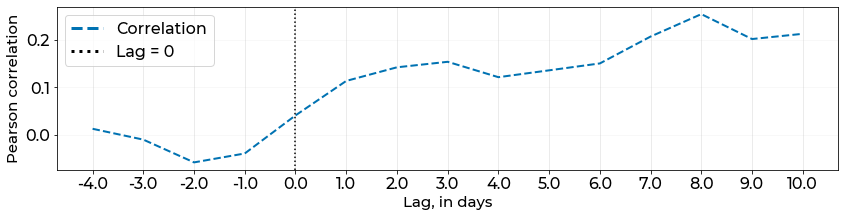

Smoothed
-8.0
[-0.08726769229694656, -0.051364378163535215, -0.010346088943608625, 0.04125870575087962, 0.10143568121820018, 0.16301216886481606, 0.2234592749443598, 0.28147321455917407, 0.33382511856786234, 0.383492165320598, 0.4224372931724937, 0.4448688453562552, 0.44922547473443175, 0.43474014188883403, 0.4110189104985796]


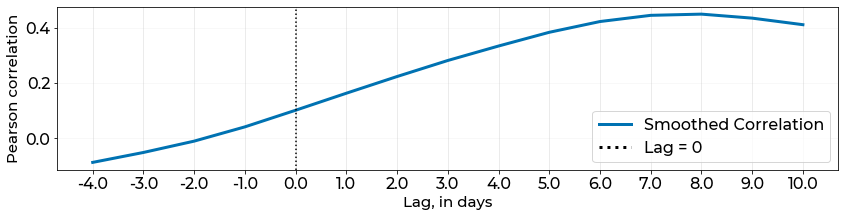

In [ ]:
#lag analysis and figure
case_count_per_day,rolling_smoothed,case_count_smoothed = lag_stuff_to_be_splitup(fall_metadata_of_positives,rolling_pos_att,days)
lag_finder(rolling_pos_att,case_count_per_day,rolling_smoothed,case_count_smoothed)

In [ ]:
#CT and non CT for rolling and non-rolling positives for spring semester

print('running')
rolling_pos_att2,holder_counter2,lower_ci_95_rolling2, higher_ci_95_rolling2,days1,counter_neg_list2,counter_pos_list2 = pos_att_network_sem_test(final_spring,by_date_pos_list_spring_dict,True,holder_counter,'Rolling Count of Positive Attribute Individuals versus Negative Attribute Individuals: Spring 2021')
print('halfway')
sem2_pos_att,holder_counter,lower_ci_95_sem2, higher_ci_95_sem2,days2,counter_neg_list2,counter_pos_list2 = pos_att_network_sem_test(final_spring,spring_metadata_of_positives_barcodes,False,holder_counter,'Sem2 Non-Rolling Count of Positive Attribute Individuals On Campus Versus Negative Attribute Individuals On Campus: Spring 2021')

running
halfway


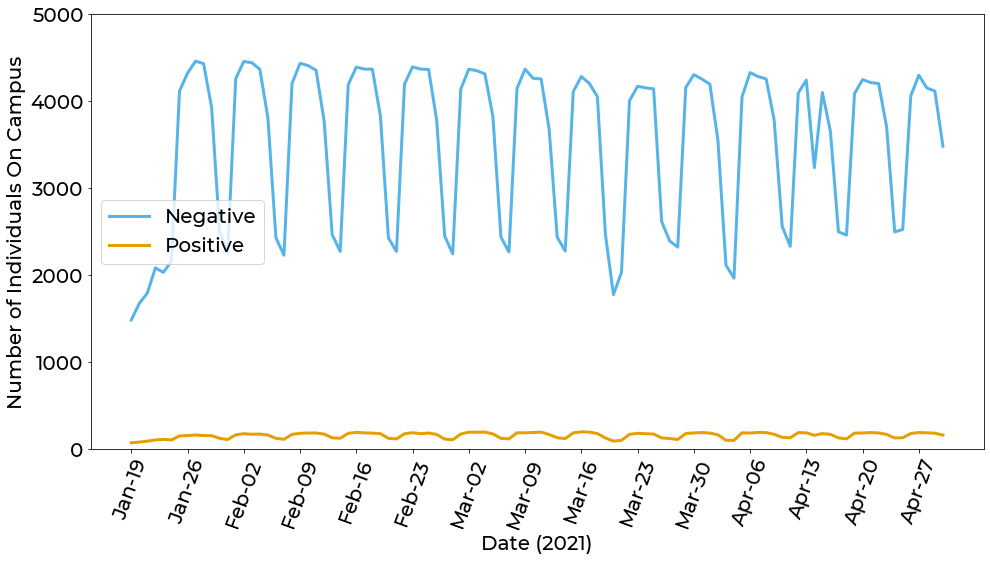

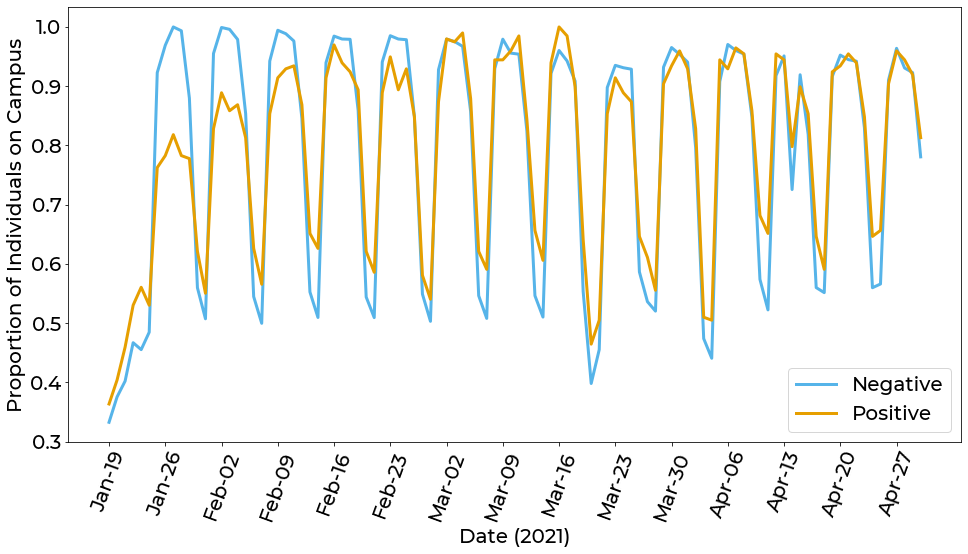

5573.5 0.37883858730562014
(0.9577469705584032, 6.308717157410912e-56)


In [ ]:
#by day charts for spring semester
create_dist_chart_sem2(counter_pos_list2,counter_neg_list2,days2)

In [ ]:
#CT AA analysis
print('running')
rolling_pos_att2,holder_counter2,lower_ci_95_rolling2, higher_ci_95_rolling2,days1,counter_neg_list2,counter_pos_list2 = pos_att_network_sem_test_CT_scenario1(final_spring,by_date_pos_list_spring_dict,True,holder_counter,'Rolling Count of Positive Attribute Individuals versus Negative Attribute Individuals: Spring 2021')


running


In [ ]:
#CT AA chart
make_AA_charts_sem2(days1,rolling_pos_att2,lower_ci_95_rolling2,higher_ci_95_rolling2,'Rolling 10 Day Window Positives and Permuted Rolling 10 Day Window Positives, Attribute Assortativity: 8/17/2020-11/23/2020',color_pallet[5],"AA","Permuted Network AA",' (10-Day Rolling)')

NameError: name 'days1' is not defined

In [ ]:
#non CT AA analysis
rolling_pos_att2,holder_counter2,lower_ci_95_rolling2, higher_ci_95_rolling2,days1,counter_neg_list2,counter_pos_list2 = pos_att_network_sem_test_CT_scenario2(final_spring,by_date_pos_list_spring_dict,True,holder_counter,'Rolling Count of Positive Attribute Individuals versus Negative Attribute Individuals: Spring 2021')

93 9 102


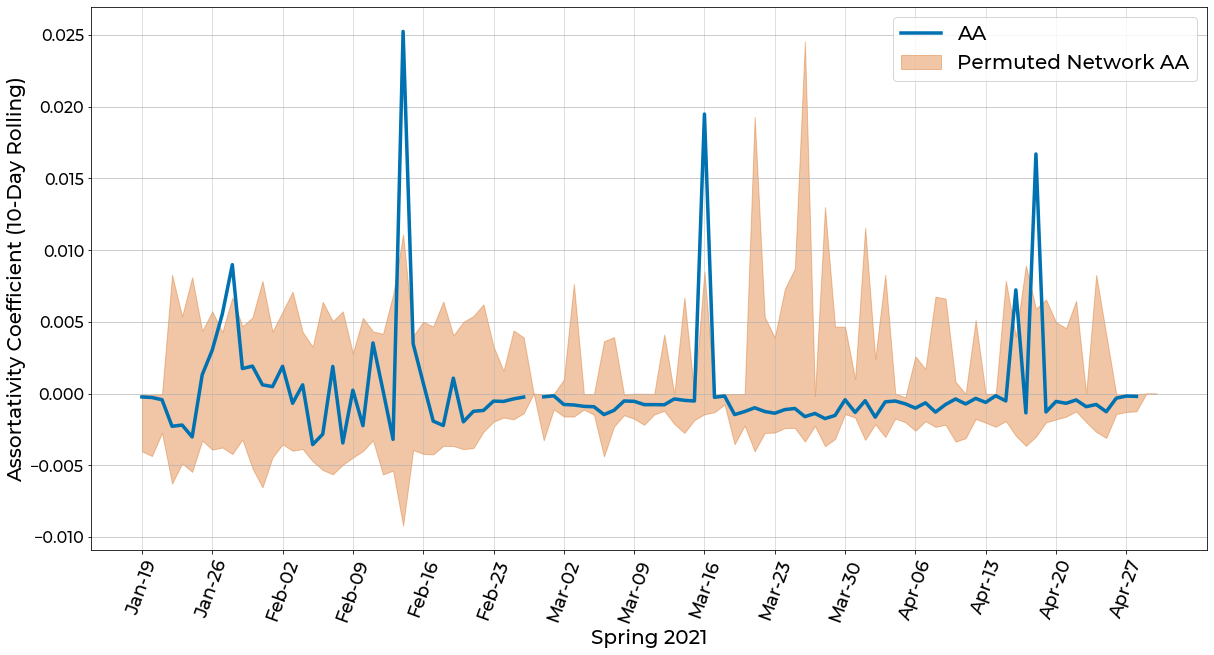

In [ ]:
#non CT AA chart
make_AA_charts_sem2(days1,rolling_pos_att2,lower_ci_95_rolling2,higher_ci_95_rolling2,'Rolling 10 Day Window Positives and Permuted Rolling 10 Day Window Positives, Attribute Assortativity: 8/17/2020-11/23/2020',color_pallet[5],"AA","Permuted Network AA",' (10-Day Rolling)')

2 100 102


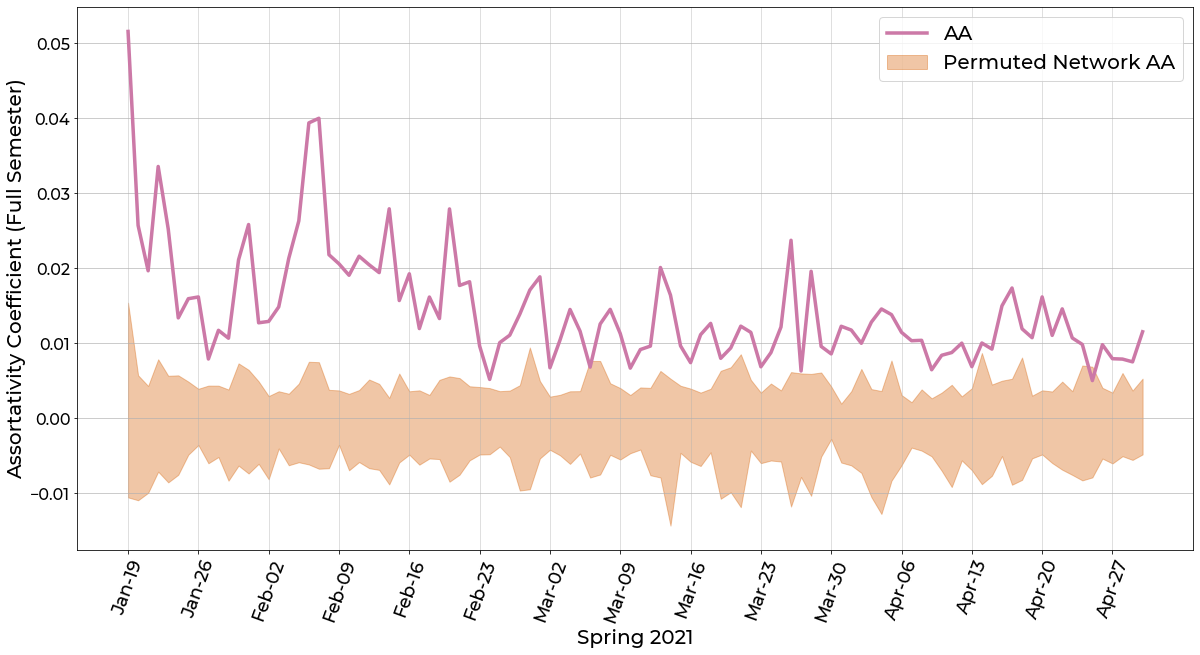

In [ ]:
#non CT AA chart spring
make_AA_charts_sem2(days2,sem2_pos_att,lower_ci_95_sem2,higher_ci_95_sem2,'Second Sem Positives and Permuted Second Sem Positives, Attribute Assortativity: 8/17/2020-11/23/2020',color_pallet[2],"AA","Permuted Network AA",' (Full Semester)')


64 38 102


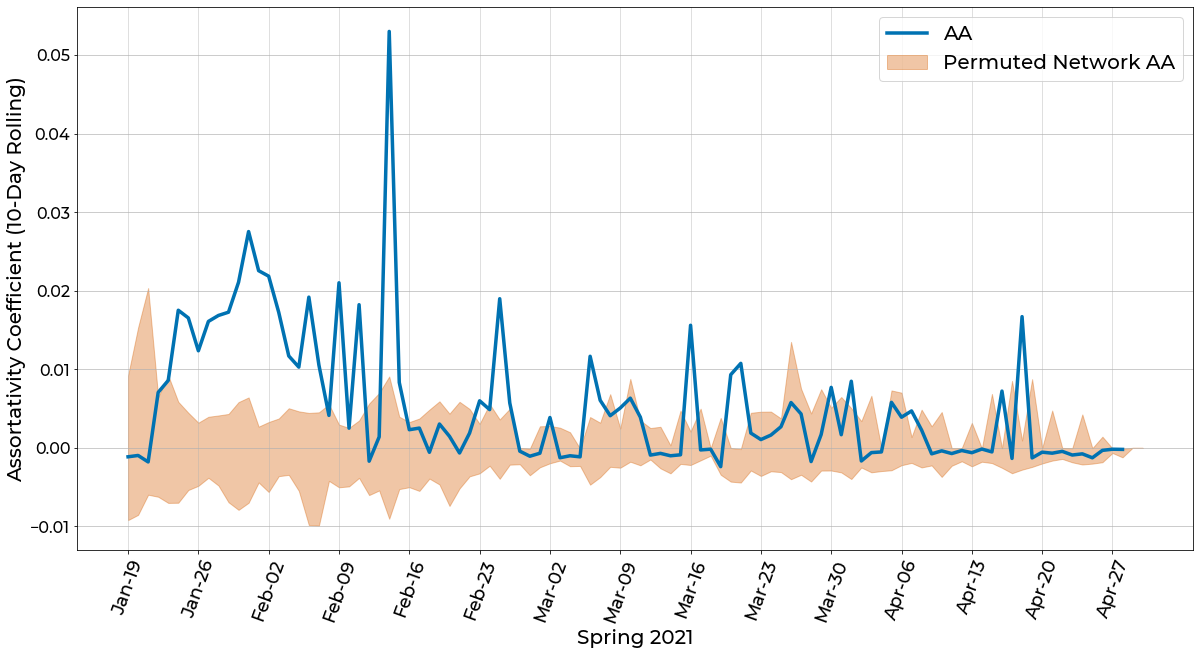

In [ ]:
#non CT AA chart spring rolling
make_AA_charts_sem2(days1,rolling_pos_att2,lower_ci_95_rolling2,higher_ci_95_rolling2,'Rolling 10 Day Window Positives and Permuted Rolling 10 Day Window Positives, Attribute Assortativity: 8/17/2020-11/23/2020',color_pallet[5],"AA","Permuted Network AA",' (10-Day Rolling)')

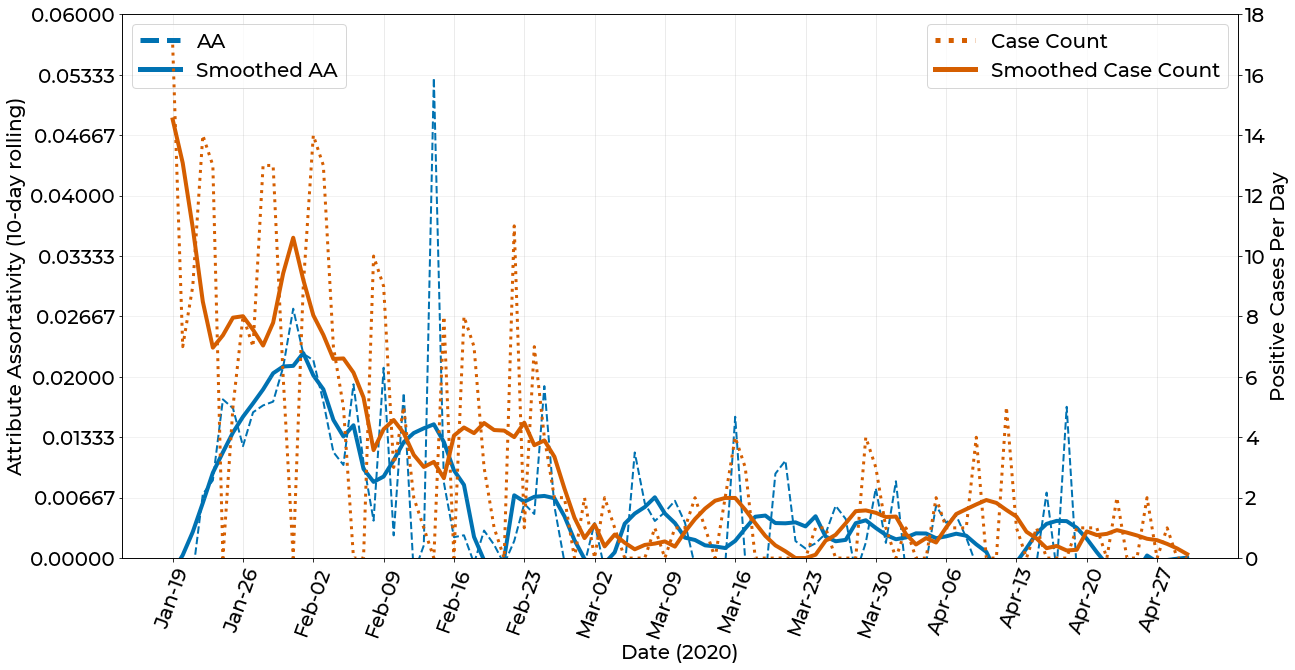

unsmoothed pearson:  (0.27344534983831126, 0.00542194193060372)
smoothed pearson:  (0.5924643252850437, 5.400188903047864e-11)
Non-Smoothed
3.0
[0.38204123189040706, 0.45868526004381066, 0.3252161114737192, 0.3312458786555474, 0.2668145877280802, 0.39425768413117285, 0.31352460395441467, 0.39846277868524255, 0.4100984052867051, 0.28629876617919586, 0.2684887794740495, 0.17585962692611726, 0.43009179887410626, 0.2553855694178165, 0.293767560214214]


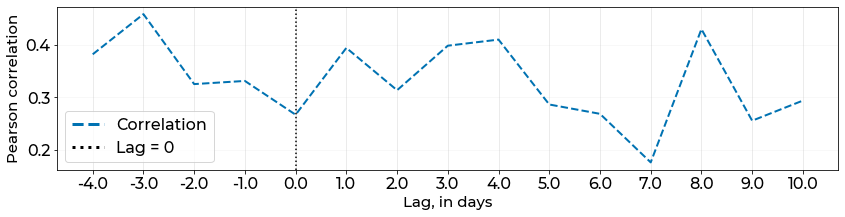

Smoothed
4.0
[0.7587608940865104, 0.7315508623328034, 0.6901815142717908, 0.6453962070178813, 0.5924643252850437, 0.6322673403375456, 0.667699078626503, 0.6906254234290153, 0.6862862493813079, 0.6589241799707979, 0.634508456063766, 0.6118256781891749, 0.5886172521141255, 0.5435655223708711, 0.4898108518859345]


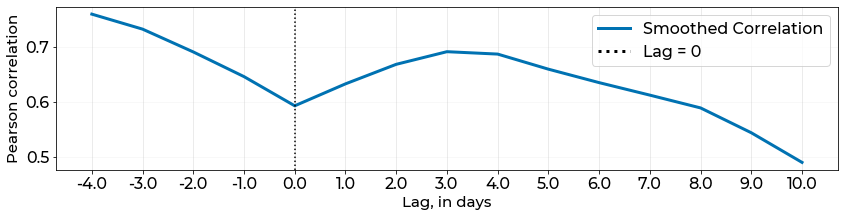

In [ ]:
#overlapping case count and AA analysis and chart

case_count_per_day2,rolling_smoothed2,case_count_smoothed2 = lag_stuff_to_be_splitup2(spring_metadata_of_positives,rolling_pos_att2,days1)
lag_finder2(rolling_pos_att2,case_count_per_day2,rolling_smoothed2,case_count_smoothed2)

In [ ]:
#begin aggregating 10 day window details for networks

all_year_positives = pd.DataFrame(columns = ['day','p1','p2','day sum duration','day median duration','day interaction count'])
pos_IDs = positiveIDs
print('running')

for j in final_fall:
    j.columns = ['day','s1','s2','sum','median','count']
    day = j['day'].iloc[0]
    print(day)
    g = nx.from_pandas_edgelist(j,'s1','s2',['sum','median','count'], create_using = nx.Graph())
    if str(day) in by_date_pos_list_fall_dict:
        rolling_positives = by_date_pos_list_fall_dict[str(day)]
    elif str(day) not in by_date_pos_list_fall_dict:
        by_date_pos_list_fall_dict[str(day)] = []
    
    rolling_positives = by_date_pos_list_fall_dict[str(day)]
    edges = list(g.edges(data = True))
    for x in edges:
        if (str(x[0]) in rolling_positives) and (str(x[0]) in pos_IDs):
            if (str(x[1]) in rolling_positives) and (str(x[1]) in pos_IDs):
                all_year_positives.loc[len(all_year_positives.index)] = [day,x[0],x[1],x[2]['sum'],x[2]['median'],x[2]['count']]

print('running2')

for j in final_spring:
    j.columns = ['day','s1','s2','sum','median','count']
    day = j['day'].iloc[0]
    print(day)
    g = nx.from_pandas_edgelist(j,'s1','s2',['sum','median','count'], create_using = nx.Graph())
    if str(day) in by_date_pos_list_spring_dict:
        rolling_positives = by_date_pos_list_spring_dict[str(day)]
    elif str(day) not in by_date_pos_list_spring_dict:
        by_date_pos_list_spring_dict[str(day)] = []
    
    rolling_positives = by_date_pos_list_spring_dict[str(day)]
    edges = list(g.edges(data = True))
    for x in edges:
        if (str(x[0]) in rolling_positives) and (str(x[0]) in pos_IDs):
            if (str(x[1]) in rolling_positives) and (str(x[1]) in pos_IDs):
                all_year_positives.loc[len(all_year_positives.index)] = [day,x[0],x[1],x[2]['sum'],x[2]['median'],x[2]['count']]


running
2020-08-17
2020-08-18
2020-08-19
2020-08-20
2020-08-21
2020-08-22
2020-08-23
2020-08-24
2020-08-25
2020-08-26
2020-08-27
2020-08-28
2020-08-29
2020-08-30
2020-08-31
2020-09-01
2020-09-02
2020-09-03
2020-09-04
2020-09-05
2020-09-06
2020-09-07
2020-09-08
2020-09-09
2020-09-10
2020-09-11
2020-09-12
2020-09-13
2020-09-14
2020-09-15
2020-09-16
2020-09-17
2020-09-18
2020-09-19
2020-09-20
2020-09-21
2020-09-22
2020-09-23
2020-09-24
2020-09-25
2020-09-26
2020-09-27
2020-09-28
2020-09-29
2020-09-30
2020-10-01
2020-10-02
2020-10-03
2020-10-04
2020-10-05
2020-10-06
2020-10-07
2020-10-08
2020-10-09
2020-10-10
2020-10-11
2020-10-12
2020-10-13
2020-10-14
2020-10-15
2020-10-16
2020-10-17
2020-10-18
2020-10-19
2020-10-20
2020-10-21
2020-10-22
2020-10-23
2020-10-24
2020-10-25
2020-10-26
2020-10-27
2020-10-28
2020-10-29
2020-10-30
2020-10-31
2020-11-01
2020-11-02
2020-11-03
2020-11-04
2020-11-05
2020-11-06
2020-11-07
2020-11-08
2020-11-09
2020-11-10
2020-11-11
2020-11-12
2020-11-13
2020-11-14
20

In [ ]:
#organize dataframe for full year 10 day window network

all_year_pos_aggregated = all_year_positives.groupby(['p1','p2']).agg({'day sum duration':'sum','day median duration':'median','day interaction count':['sum','size']}).reset_index()
new_columns = [''.join(t) for t in all_year_pos_aggregated.columns]
all_year_pos_aggregated.columns = new_columns
all_year_pos_aggregated.columns = ['p1','p2','total interactions','median duration median','sum time spent','total days interacted']

In [ ]:
#creating weighting of sum time spent (inverse so weight shows properly)
all_year_pos_aggregated['inverse total interaction time'] = 1/all_year_pos_aggregated['sum time spent']

In [ ]:
#read the csv that has this information already saved
all_year_pos_aggregated = pd.read_csv('all_year_pos_aggregated_refreshed.csv')

In [ ]:
#remove any positives that arent in the metadata list

all_year_pos_aggregated = all_year_pos_aggregated[all_year_pos_aggregated['p1'].isin(metadata['barcode'].values)]
all_year_pos_aggregated = all_year_pos_aggregated[all_year_pos_aggregated['p2'].isin(metadata['barcode'].values)]

In [ ]:
#produce the network showing the full year 10day window network

all_all_graph = nx.from_pandas_edgelist(all_year_pos_aggregated,'p1','p2',['sum time spent','median duration median', 'total interactions', 'total days interacted','inverse total interaction time'],create_using = nx.Graph())
weight = nx.get_edge_attributes(all_all_graph,'inverse total interaction time')
weight = list(weight.values())
weight = [x/(max(weight))*2 for x in weight]
#weight = .5
plt.figure(figsize = (20,20))
color_map = []
node_color_dict = {}
peacock_nodes = []
non_peacock_nodes = []
for node in all_all_graph:
    if node in peacock_list:
        node_color_dict[node] = color_pallet[0]
        color_map.append(color_pallet[0])
        peacock_nodes.append(node)
    elif node in sequenced_with_classyear['barcode'].tolist():
        node_color_dict[node] = color_pallet[5]
        color_map.append(color_pallet[5])
        non_peacock_nodes.append(node)
    else: 
        node_color_dict[node] = color_pallet[3]
        color_map.append(color_pallet[3])   

nodes_to_hold = all_all_graph.nodes

nx.set_node_attributes(all_all_graph,node_color_dict,'sequence_status')


node_list_dict_peacock = {}
node_list_dict_nonpeacock = {}

peacock_dist = []
non_peacock_dist = []
for node in all_all_graph:
    for node2 in all_all_graph:
        if node != node2:
            if nx.has_path(all_all_graph,node,node2):
                if (str([node,node2]) not in node_list_dict_peacock) and (str([node2,node]) not in node_list_dict_peacock) and (str([node,node2]) not in node_list_dict_nonpeacock) and (str([node2,node]) not in node_list_dict_nonpeacock):
                    if node in peacock_list and node2 in peacock_list:
                        node_list_dict_peacock[str([node,node2])] = nx.shortest_path_length(all_all_graph,node,node2)
                    elif (node not in peacock_list and node2 in peacock_list) or (node in peacock_list and node2 not in peacock_list):
                        node_list_dict_nonpeacock[str([node,node2])] = nx.shortest_path_length(all_all_graph,node,node2)

print(len(node_list_dict_peacock))
print(len(node_list_dict_nonpeacock))

nx.write_gexf(all_all_graph, "main5.gexf")


nx.draw(all_all_graph,pos =nx.spring_layout(all_all_graph,seed = 4,k=0.089, iterations=45),width = weight,with_labels = False,node_size = 100,alpha = .6,linewidths = .9,edge_color = 'grey',node_color = color_map,font_size = 14)
#nx.draw(all_all_graph,pos =nx.kamada_kawai_layout(all_all_graph,scale = 4),width = weight,with_labels = False,node_size = 100,alpha = .6,linewidths = .9,edge_color = 'royalblue',node_color = color_map,font_size = 14)

plt.show()

mavilys = metadata[['barcode','Mavily']].dropna()
mavilys_dict = dict(mavilys.values)

sports = metadata[['barcode','Sports_team']].dropna()
sports_dict = dict(sports.values)

add_sports = metadata[['barcode','Additional_Sports_team']].dropna()
add_sports_dict = dict(add_sports.values)

residency = metadata[['barcode','Lives_on_campus']].dropna()
residency_dict = dict(residency.values)

residence_hall = metadata[['barcode','Residence_hall']].dropna()
residence_hall_dict = dict(residence_hall.values)

gender = metadata[['barcode','Sex']].dropna()
gender_dict = dict(gender.values)

class_year = metadata[['barcode','Class_Year']].dropna()
class_year_dict = dict(class_year.values)


        
nx.set_node_attributes(all_all_graph,mavilys_dict,'mavily')
pos_attribute_assort_coef = assortativity.attribute_assortativity_coefficient(all_all_graph, 'mavily')
print('mavily',pos_attribute_assort_coef)

nx.set_node_attributes(all_all_graph,sports_dict,'sports')
pos_attribute_assort_coef = assortativity.attribute_assortativity_coefficient(all_all_graph, 'sports')
print('sports',pos_attribute_assort_coef)

nx.set_node_attributes(all_all_graph,residence_hall_dict,'residence_hall')
pos_attribute_assort_coef = assortativity.attribute_assortativity_coefficient(all_all_graph, 'residence_hall')
print('residence hall',pos_attribute_assort_coef)

nx.set_node_attributes(all_all_graph,residency_dict,'residency')
pos_attribute_assort_coef = assortativity.attribute_assortativity_coefficient(all_all_graph, 'residency')
print('residency',pos_attribute_assort_coef)

nx.set_node_attributes(all_all_graph,gender_dict,'gender')
pos_attribute_assort_coef = assortativity.attribute_assortativity_coefficient(all_all_graph, 'gender')
print('gender',pos_attribute_assort_coef)

nx.set_node_attributes(all_all_graph,class_year_dict,'class_year')
pos_attribute_assort_coef = assortativity.attribute_assortativity_coefficient(all_all_graph, 'class_year')
print('class year',pos_attribute_assort_coef)

S = [all_all_graph.subgraph(c).copy() for c in nx.connected_components(all_all_graph)]



NameError: name 'peacock_list' is not defined

<Figure size 1440x1440 with 0 Axes>

0.09204147894335617


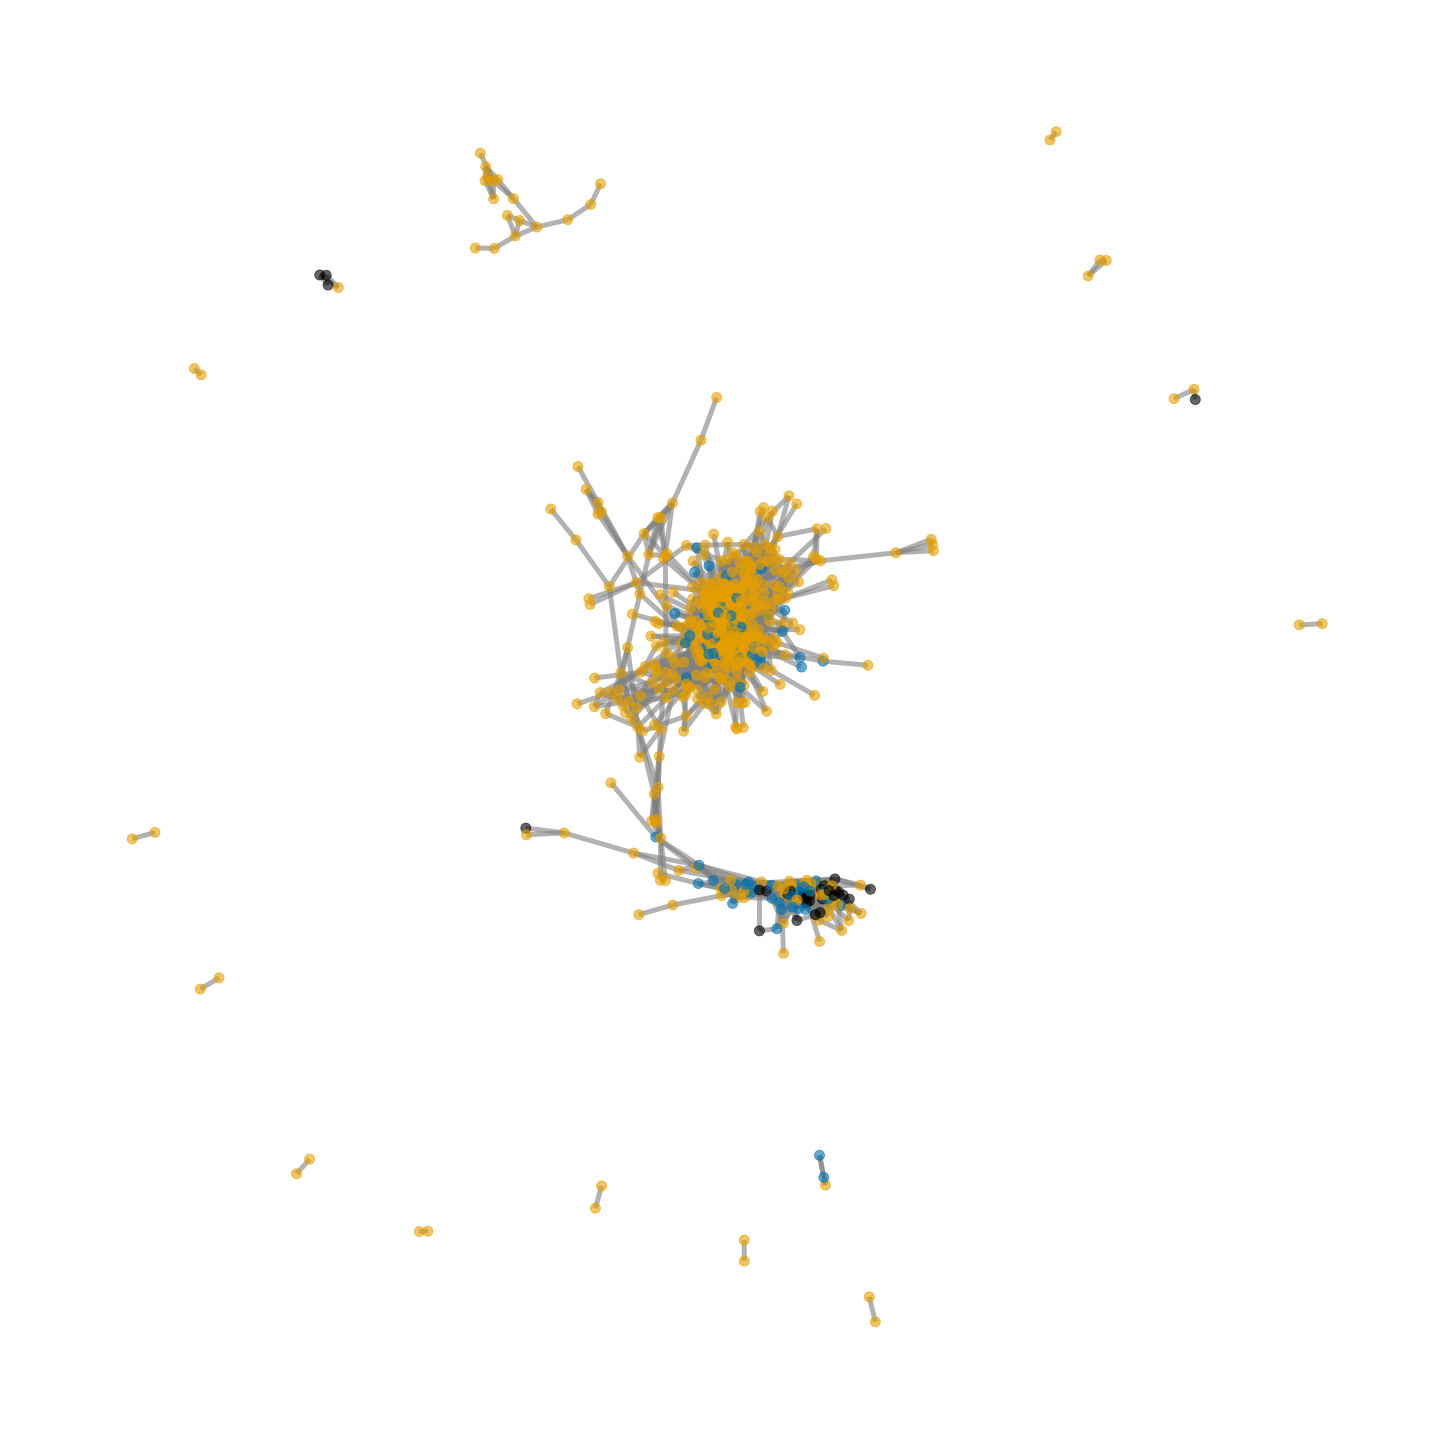

Graph with 664 nodes and 4789 edges


In [ ]:
#look at assortativity by lineage

barcode_2_lineage = {}
for x in range(len(sequenced['barcode'])):
    barcode_2_lineage[sequenced['barcode'].iloc[x]] = sequenced['pango_lineage'].iloc[x]
    
{key:val for key, val in barcode_2_lineage.items() if val != None}
{key:val for key, val in barcode_2_lineage.items() if val != np.nan}

for node in all_all_graph:
    if node not in barcode_2_lineage:
        barcode_2_lineage[node] = 'NOT SEQUENCED'


nx.set_node_attributes(all_all_graph,barcode_2_lineage,'sequence_lineage')
pos_attribute_assort_coef = assortativity.attribute_assortativity_coefficient(all_all_graph, 'sequence_lineage')
print(pos_attribute_assort_coef)


plt.figure(figsize = (20,20))
nx.draw(all_all_graph,pos =nx.spring_layout(all_all_graph,seed = 27),with_labels = False,width = 5,node_size = 100,alpha = .6,linewidths = .9,edge_color = 'grey',node_color = color_map,font_size = 14)
plt.show()

nx.write_gexf(all_all_graph, "to_see.gexf")

print(all_all_graph)

In [56]:
#make a list of all peacock barcodes
peacock_IDs = list(peacock['barcode'].values)

In [ ]:
#read in snp distance files and merge with wifi path distance files

genetic_distance = pd.read_csv('genetic_distance_cleaned_refreshed.csv')
path_info = pd.read_csv('new_full_cleaned_refreshed.csv',usecols = ['p1','p2','path dist','weighted path dist'])
genetic_distance.columns = ['index','p1','p2','snps']
path_info.columns = ['p1','p2','path dist','weighted path dist']
new_gen_dist = pd.merge(genetic_distance,path_info,on=['p1','p2'],how = 'left')
new_gen_dist.to_csv('path_and_gen_dist_refreshed.csv')


In [ ]:
#read in final csv's that were premade
final_cleaned_paths = pd.read_csv('path_and_gen_dist_refreshed.csv',usecols = ['p1','p2','snps','path dist','weighted path dist'])

In [ ]:
#identifying infinite or finite paths within network (i.e. within social network)
final_cleaned_paths['path_inf_or_not'] = ['infinite' if final_cleaned_paths['path dist'][x] == np.inf else 'finite' for x in range(len(final_cleaned_paths))]

In [ ]:
#identifying the type of pairing (peacock to peacock vs peacock to non peacock etc)
final_cleaned_paths['p1 status'] = ['peacock' if final_cleaned_paths['p1'][x] in peacock_IDs else 'non-peacock' for x in range(len(final_cleaned_paths))]
final_cleaned_paths['p2 status'] = ['peacock' if final_cleaned_paths['p2'][x] in peacock_IDs else 'non-peacock' for x in range(len(final_cleaned_paths))]

In [ ]:
#labeling peacock pair type
final_cleaned_paths['peacock'] = ['peacock pair' if (final_cleaned_paths['p1 status'][x] == 'peacock' and final_cleaned_paths['p2 status'][x] == 'peacock') else 'non-peacock pair' for x in range(len(final_cleaned_paths))]

In [ ]:
#labeling non-sequenced nodes consistently

barcode_2_lineage = {}
for x in range(len(sequenced['barcode'])):
    barcode_2_lineage[sequenced['barcode'].iloc[x]] = sequenced['pango_lineage'].iloc[x]
    
{key:val for key, val in barcode_2_lineage.items() if val != None}
{key:val for key, val in barcode_2_lineage.items() if val != np.nan}
{key:val for key, val in barcode_2_lineage.items() if val in nodes_to_hold}


{}

MannwhitneyuResult(statistic=1609938.0, pvalue=2.644421785488866e-66)
MannwhitneyuResult(statistic=28924.0, pvalue=4.211092120542112e-25)
MannwhitneyuResult(statistic=274289.5, pvalue=0.0005443527331881276)


C:\Users\brync\AppData\Local\Temp/ipykernel_31804/1200623507.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_peacock_pairings_fin['type'] = 1
C:\Users\brync\AppData\Local\Temp/ipykernel_31804/1200623507.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peacock_pairings_fin['type'] = 0


NameError: name 'p' is not defined

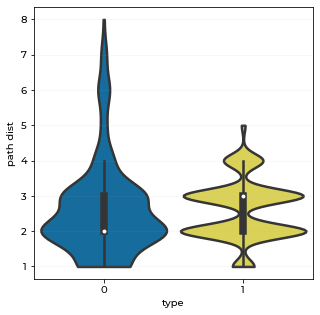

In [ ]:
#running statistical tests on peacock path distance analysis
final_cleaned_paths['status'] = final_cleaned_paths['p1 status']+","+final_cleaned_paths['p2 status']
final_cleaned_paths['status'] = [len(list(set(x.split(',')))) for x in final_cleaned_paths['status']]
final_cleaned_paths = final_cleaned_paths[final_cleaned_paths['p2'].isin(nodes_to_hold)]
final_cleaned_paths = final_cleaned_paths[final_cleaned_paths['p1'].isin(nodes_to_hold)]


non_peacock_pairings = final_cleaned_paths[final_cleaned_paths['peacock'] == 'non-peacock pair' ]
non_peacock_pairings = non_peacock_pairings[non_peacock_pairings['status'] == 1 ]

peacock_pairs_df = final_cleaned_paths[final_cleaned_paths['peacock'] == 'peacock pair' ]

#make box plot for inf versus non inf for peacock versus non peacock
non_peacock_pairings_inf_snps = list(non_peacock_pairings[non_peacock_pairings['path_inf_or_not'] == 'infinite']['snps'])
non_peacock_pairings_fin_snps = list(non_peacock_pairings[non_peacock_pairings['path_inf_or_not'] == 'finite']['snps'])

peacock_pairings_inf_snps = list(peacock_pairs_df[peacock_pairs_df['path_inf_or_not'] == 'infinite']['snps'])
peacock_pairings_fin_snps = list(peacock_pairs_df[peacock_pairs_df['path_inf_or_not'] == 'finite']['snps'])


non_peacock_pairings_fin = non_peacock_pairings[non_peacock_pairings['path_inf_or_not'] == 'finite']
peacock_pairings_fin = peacock_pairs_df[peacock_pairs_df['path_inf_or_not'] == 'finite']


print(scipy.stats.mannwhitneyu(non_peacock_pairings_inf_snps,non_peacock_pairings_fin_snps))
print(scipy.stats.mannwhitneyu(peacock_pairings_inf_snps,peacock_pairings_fin_snps))


print(scipy.stats.mannwhitneyu(non_peacock_pairings_fin['path dist'],peacock_pairings_fin['path dist']))

non_peacock_pairings_fin['type'] = 1
peacock_pairings_fin['type'] = 0


for_dist_compare = pd.concat([non_peacock_pairings_fin,peacock_pairings_fin], ignore_index=True)

#plt.figure(figsize = (5,5))
#plt.grid(axis = 'y',alpha = .1)

#sns.violinplot(y = "path dist", x = 'type' ,data=for_dist_compare,inner = 'box',cut = 0,split = True, linewidth=2.5,width = .9,scale = 'width')
#barplot_annotate_brackets(0,1,p,[0,1],[8,8],maxasterix=3,fs = 12)
#plt.yticks(np.arange(0,10,step =1),labels = np.arange(0,10,step =1),fontsize = 14)
#plt.xticks([0,1],['B.1.429.1 Pair','Mixed Pair'],fontsize = 15)
#plt.ylabel('Path Distance',fontsize = 13)
#plt.xlabel('')
#plt.ylim(0,10)

#plt.show()

4.211092120542112e-25 28924.0


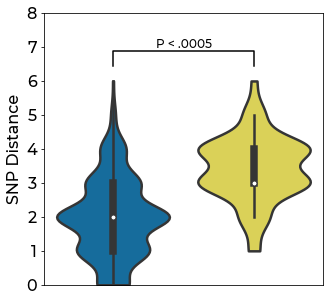

[2. 3.]
['n: 328', 'n: 107']
MannwhitneyuResult(statistic=1609938.0, pvalue=2.644421785488866e-66)
MannwhitneyuResult(statistic=28924.0, pvalue=4.211092120542112e-25)


In [ ]:
#making statistical tests on peacock snp distance and path existence analyses
sns.set_palette(sns.color_palette([color_pallet[5],color_pallet[1]]))
u,p = scipy.stats.mannwhitneyu(peacock_pairings_inf_snps,peacock_pairings_fin_snps)
print(p,u)
plt.figure(figsize = (5,5))
sns.violinplot(x = "path_inf_or_not", y = "snps",data=final_cleaned_paths[final_cleaned_paths['peacock'] == 'peacock pair' ],inner = 'box',cut = 0,split = True, linewidth=2.5)
#plt.title("Peacock Pair",fontsize = 15,fontweight = 'bold')
plt.xlabel('',fontsize = 13)
plt.ylabel('SNP Distance',fontsize = 16)
plt.ylim(0,8)
barplot_annotate_brackets(0,1,p,[0,1],[6,6],maxasterix=3,fs = 12)
plt.yticks(np.arange(0,9,step =1),labels = np.arange(0,9,step =1),fontsize = 16)
plt.xticks([],[])
#leg = plt.legend(loc = 'upper left',labels=['Within Social Proximity Network', 'Not Within Social Proximity Network'],frameon = True, borderpad=.5,fontsize = 11)
#leg.legendHandles[0].set_color(color_pallet[5])
#leg.legendHandles[1].set_color(color_pallet[1])
# set the linewidth of each legend object
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(6.0)

image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'Main5C.svg'

plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()

medians = final_cleaned_paths[final_cleaned_paths['peacock'] == 'peacock pair' ].groupby(['path_inf_or_not'])['snps'].median().values
nobs = final_cleaned_paths[final_cleaned_paths['peacock'] == 'peacock pair' ]['path_inf_or_not'].value_counts().values
nobs = [str(x) for x in nobs.tolist()]
nobs = ["n: " + i for i in nobs]
 
print(medians)
print(nobs)




#make box plot for inf versus non inf for peacock versus non peacock
non_peacock_pairings_inf = list(non_peacock_pairings[non_peacock_pairings['path_inf_or_not'] == 'infinite']['snps'])
non_peacock_pairings_fin = list(non_peacock_pairings[non_peacock_pairings['path_inf_or_not'] == 'finite']['snps'])

peacock_pairings_inf = list(peacock_pairs_df[peacock_pairs_df['path_inf_or_not'] == 'infinite']['snps'])
peacock_pairings_fin = list(peacock_pairs_df[peacock_pairs_df['path_inf_or_not'] == 'finite']['snps'])

print(scipy.stats.mannwhitneyu(non_peacock_pairings_inf,non_peacock_pairings_fin))
print(scipy.stats.mannwhitneyu(peacock_pairings_inf,peacock_pairings_fin))

In [ ]:
#looking for infinite vs noninfinite path distance groupings
inf_gen_dist_path_dist = final_cleaned_paths[final_cleaned_paths['path_inf_or_not']=='infinite']
non_inf_gen_dist_path_dist = final_cleaned_paths[final_cleaned_paths['path_inf_or_not']=='finite']

In [ ]:
#pulling in CT data again for analysis
ct_data = pd.read_csv('ct_data.csv',index_col = 0)
ct_data = ct_data.dropna()[['barcode','IDs']]
ct_data['IDs'] = [x.replace('\'','').strip('][').split(', ') for x in ct_data['IDs']]
ct_dict = ct_data.set_index('barcode').T.to_dict()


['PB5NAM51D', 'PB3RNGH6D']

In [ ]:
#running comparisons on contact traced individuals/pairings 

print('running')
ct_ct_sum = []
non_non_sum = []
ct_ct_median = []
non_non_median = []
ct_ct_ints = []
non_non_ints = []
p_n_sum = []
p_n_median = []
p_n_ints = []
n_n_sum = []
n_n_median = []
n_n_ints = []

for j in final_spring:
    j.columns = ['day','s1','s2','sum duration','median duration','num interactions']
    day = j['day'].iloc[0]
    rolling_positives = by_date_pos_list_spring_dict[str(day)]
    g = nx.from_pandas_edgelist(j,'s1','s2',['sum duration','median duration','num interactions'], create_using = nx.Graph())
    edges = list(g.edges(data = True))
    for x in edges:
        if (str(x[0]) in ct_dict and str(x[1]) in ct_dict[str(x[0])]['IDs'] and str(x[0]) in rolling_positives and str(x[1] in rolling_positives)) or (str(x[1]) in ct_dict and str(x[0]) in ct_dict[str(x[1])]['IDs'] and str(x[0]) in rolling_positives and str(x[1] in rolling_positives)):   #ct - ct
            ct_ct_sum.append(x[2]['sum duration'])
            ct_ct_median.append(x[2]['median duration'])
            ct_ct_ints.append(x[2]['num interactions'])
        elif (str(x[0]) not in ct_dict and str(x[1]) not in ct_dict and str(x[0]) in rolling_positives and str(x[1] in rolling_positives)): #non - non
            non_non_sum.append(x[2]['sum duration'])
            non_non_median.append(x[2]['median duration'])
            non_non_ints.append(x[2]['num interactions'])
        
        if ((str(x[0]) in rolling_positives and str(x[1]) not in rolling_positives) or (str(x[0]) not in rolling_positives and str(x[1]) in rolling_positives)):
            p_n_sum.append(x[2]['sum duration'])
            p_n_median.append(x[2]['median duration'])
            p_n_ints.append(x[2]['num interactions'])
        elif (str(x[0]) not in rolling_positives and str(x[1]) not in rolling_positives):
            n_n_sum.append(x[2]['sum duration'])
            n_n_median.append(x[2]['median duration'])
            n_n_ints.append(x[2]['num interactions'])
        


running


ct/ct-non/non 7.99335698991342e-102
ct/ct-pos/neg 5.4299066739157466e-105
ct/ct-n/n 7.455442230661195e-112
pos/neg-non/non 0.9610303340173802
neg/neg-pos/neg 5.4299066739157466e-105


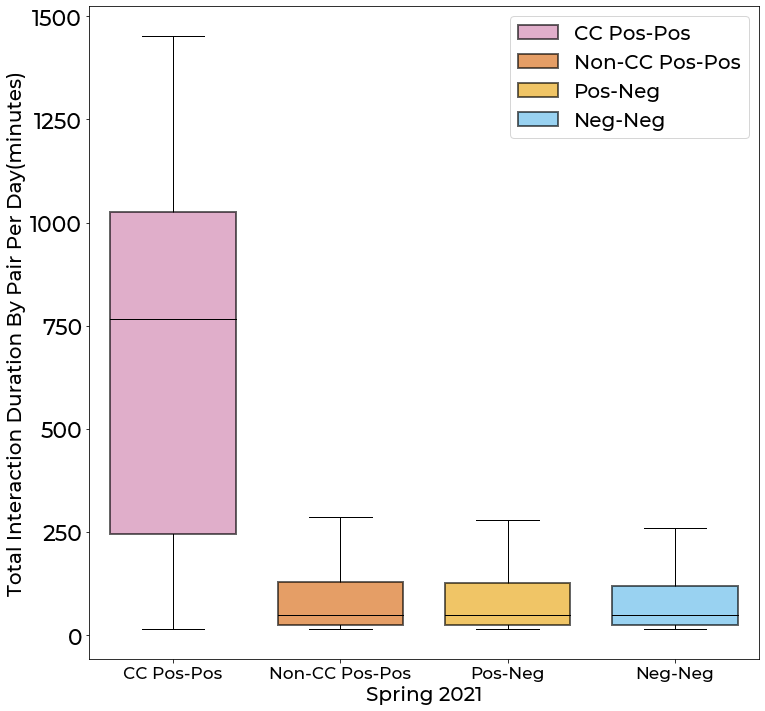

spring 2021
median ct/ct sum 766.5
median non/non sum 50.0
median p/n sum 50.0
median n/n sum 49.0


In [ ]:
#running statistical tests on contact tracing analysis/data completed above 
#and creating fig

U1, ct_non = mannwhitneyu(ct_ct_sum, non_non_sum)
print("ct/ct-non/non",ct_non)

U1, ct_pn = mannwhitneyu(ct_ct_sum, p_n_sum)
print("ct/ct-pos/neg",ct_pn)

U1, ct_nn = mannwhitneyu(ct_ct_sum, n_n_sum)
print("ct/ct-n/n",ct_nn)

U1, pn_non = mannwhitneyu(p_n_sum, non_non_sum)
print("pos/neg-non/non",pn_non)

U1, nn_pn = mannwhitneyu(n_n_sum, p_n_sum)
print("neg/neg-pos/neg",ct_pn)


fig, ax = plt.subplots(figsize = (12,12))
bp1 = box_plot_no_fliers(ct_ct_sum,color_pallet[2],1)
bp2 = box_plot_no_fliers(non_non_sum,color_pallet[6],2)
bp3 = box_plot_no_fliers(p_n_sum,color_pallet[3],3)
bp4 = box_plot_no_fliers(n_n_sum,color_pallet[4],4)
#ax.set_ylim(0,2500)
ax.legend([bp1["boxes"][0], bp2["boxes"][0],bp3["boxes"][0], bp4["boxes"][0]],  ['CC Pos-Pos','Non-CC Pos-Pos','Pos-Neg','Neg-Neg'],fontsize = 20,frameon=True)
ax.set_xticks([1,2,3,4])
ax.set_yticks(np.arange(0,1600,step =250))
ax.set_yticklabels(labels = np.arange(0,1600,step =250),fontsize = 22)
ax.set_xticklabels(labels = ['CC Pos-Pos','Non-CC Pos-Pos','Pos-Neg','Neg-Neg'],fontsize = 17)
plt.grid(axis = 'x',visible = False)
ax.set_ylabel('Total Interaction Duration By Pair Per Day(minutes)',fontsize = 20)
ax.set_xlabel('Spring 2021',fontsize = 20)
image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'Supp7C2.svg'
plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()


print('spring 2021')
print("median ct/ct sum", statistics.median(ct_ct_sum))
print("median non/non sum", statistics.median(non_non_sum))
print("median p/n sum", statistics.median(p_n_sum))
print("median n/n sum", statistics.median(n_n_sum))


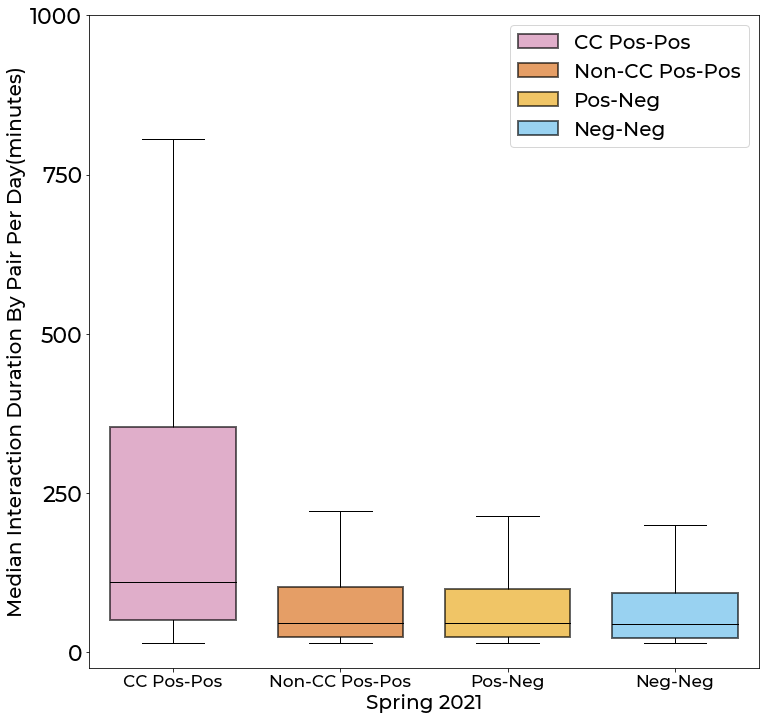

spring 2021
median ct/ct median 110.0
median non/non median 46.0
median p/n median 46.0
median n/n median 45.0
ct/ct-non/non 1.342801294270188e-34
ct/ct-pos/neg 6.507244325372294e-36
ct/ct-n/n 2.1072160280088278e-39
pos/neg-non/non 0.9902697142458855
neg/neg-pos/neg 6.507244325372294e-36


In [ ]:
#creating fig for median interaction time

fig, ax = plt.subplots(figsize = (12,12))
bp1 = box_plot_no_fliers(ct_ct_median,color_pallet[2],1)
bp2 = box_plot_no_fliers(non_non_median,color_pallet[6],2)
bp3 = box_plot_no_fliers(p_n_median,color_pallet[3],3)
bp4 = box_plot_no_fliers(n_n_median,color_pallet[4],4)
#ax.set_ylim(0,2500)
ax.legend([bp1["boxes"][0], bp2["boxes"][0],bp3["boxes"][0], bp4["boxes"][0]],  ['CC Pos-Pos','Non-CC Pos-Pos','Pos-Neg','Neg-Neg'],fontsize = 20,frameon=True)
ax.set_xticks([1,2,3,4])
ax.set_yticks(np.arange(0,1100,step =250))
ax.set_yticklabels(labels = np.arange(0,1100,step =250),fontsize = 22)
ax.set_xticklabels(labels = ['CC Pos-Pos','Non-CC Pos-Pos','Pos-Neg','Neg-Neg'],fontsize = 17)
plt.grid(axis = 'x',visible = False)
ax.set_xlabel('Spring 2021',fontsize = 20)
ax.set_ylabel('Median Interaction Duration By Pair Per Day(minutes)',fontsize = 20)
image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'Supp7D2.svg'
plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()


print('spring 2021')
print("median ct/ct median", statistics.median(ct_ct_median))
print("median non/non median", statistics.median(non_non_median))
print("median p/n median", statistics.median(p_n_median))
print("median n/n median", statistics.median(n_n_median))

U1, ct_non = mannwhitneyu(ct_ct_median, non_non_median)
print("ct/ct-non/non",ct_non)

U1, ct_pn = mannwhitneyu(ct_ct_median, p_n_median)
print("ct/ct-pos/neg",ct_pn)

U1, ct_nn = mannwhitneyu(ct_ct_median, n_n_median)
print("ct/ct-n/n",ct_nn)

U1, pn_non = mannwhitneyu(p_n_median, non_non_median)
print("pos/neg-non/non",pn_non)

U1, nn_pn = mannwhitneyu(n_n_median, p_n_median)
print("neg/neg-pos/neg",ct_pn)


In [ ]:
#running same CT analysis but this time for fall

print('running')
ct_ct_sum1 = []
non_non_sum1 = []
ct_ct_median1 = []
non_non_median1 = []
ct_ct_ints1 = []
non_non_ints1 = []
p_n_sum1 = []
p_n_median1 = []
p_n_ints1 = []
n_n_sum1 = []
n_n_median1 = []
n_n_ints1 = []

for j in final_fall:
    j.columns = ['day','s1','s2','sum duration','median duration','num interactions']
    day = j['day'].iloc[0]
    rolling_positives = by_date_pos_list_fall_dict[str(day)]
    g = nx.from_pandas_edgelist(j,'s1','s2',['sum duration','median duration','num interactions'], create_using = nx.Graph())
    edges = list(g.edges(data = True))
    for x in edges:
        if (str(x[0]) in ct_dict and str(x[1]) in ct_dict[str(x[0])]['IDs'] and str(x[0]) in rolling_positives and str(x[1] in rolling_positives)) or (str(x[1]) in ct_dict and str(x[0]) in ct_dict[str(x[1])]['IDs'] and str(x[0]) in rolling_positives and str(x[1] in rolling_positives)):   #ct - ct
            ct_ct_sum1.append(x[2]['sum duration'])
            ct_ct_median1.append(x[2]['median duration'])
            ct_ct_ints1.append(x[2]['num interactions'])
        elif (str(x[0]) not in ct_dict and str(x[1]) not in ct_dict and str(x[0]) in rolling_positives and str(x[1] in rolling_positives)): #non - non
            non_non_sum1.append(x[2]['sum duration'])
            non_non_median1.append(x[2]['median duration'])
            non_non_ints1.append(x[2]['num interactions'])
        
        if ((str(x[0]) in rolling_positives and str(x[1]) not in rolling_positives) or (str(x[0]) not in rolling_positives and str(x[1]) in rolling_positives)):
            p_n_sum1.append(x[2]['sum duration'])
            p_n_median1.append(x[2]['median duration'])
            p_n_ints1.append(x[2]['num interactions'])
        elif (str(x[0]) not in rolling_positives and str(x[1]) not in rolling_positives):
            n_n_sum1.append(x[2]['sum duration'])
            n_n_median1.append(x[2]['median duration'])
            n_n_ints1.append(x[2]['num interactions'])
        

running


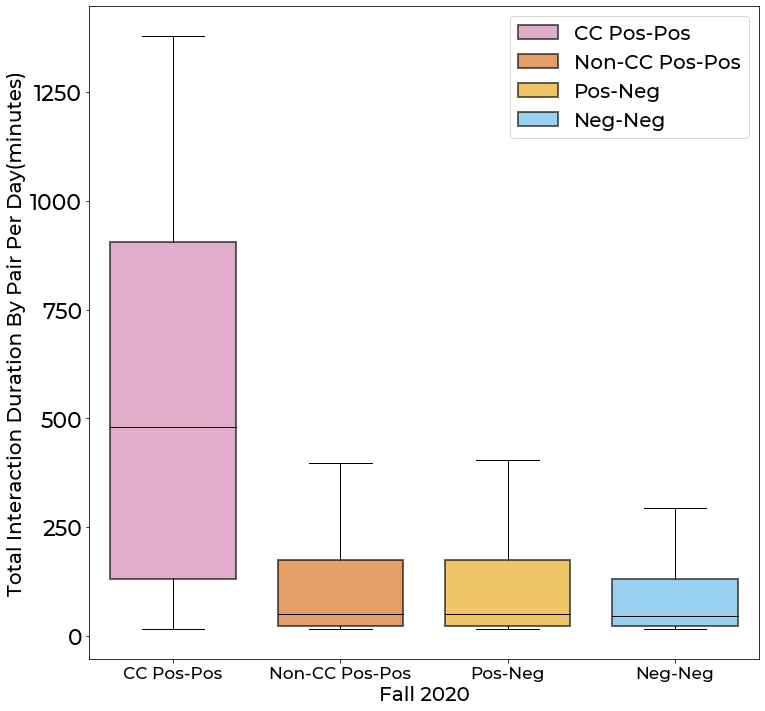

fall 2020
median ct/ct sum 481.0
median non/non sum 49.0
median p/n sum 50.0
median n/n sum 45.0
ct/ct-non/non 9.012215892491636e-120
ct/ct-pos/neg 2.3890411233130806e-119
ct/ct-n/n 6.030934945808587e-140
pos/neg-non/non 0.03383201410894686
neg/neg-pos/neg 2.3890411233130806e-119


In [ ]:
#creating fall CT total interaction time figs

fig, ax = plt.subplots(figsize = (12,12))
bp1 = box_plot_no_fliers(ct_ct_sum1,color_pallet[2],1)
bp2 = box_plot_no_fliers(non_non_sum1,color_pallet[6],2)
bp3 = box_plot_no_fliers(p_n_sum1,color_pallet[3],3)
bp4 = box_plot_no_fliers(n_n_sum1,color_pallet[4],4)
ax.legend([bp1["boxes"][0], bp2["boxes"][0],bp3["boxes"][0], bp4["boxes"][0]], ['CC Pos-Pos','Non-CC Pos-Pos','Pos-Neg','Neg-Neg'],fontsize = 20,frameon=True)
ax.set_xticks([1,2,3,4])
ax.set_yticks(np.arange(0,1450,step =250))
ax.set_yticklabels(labels = np.arange(0,1450,step =250),fontsize = 22)
ax.set_xticklabels(labels = ['CC Pos-Pos','Non-CC Pos-Pos','Pos-Neg','Neg-Neg'],fontsize = 17)
plt.grid(axis = 'x',visible = False)
ax.set_xlabel('Fall 2020',fontsize = 20)
ax.set_ylabel('Total Interaction Duration By Pair Per Day(minutes)',fontsize = 20)
image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'Supp7C1.svg'
plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()


print('fall 2020')
print("median ct/ct sum", statistics.median(ct_ct_sum1))
print("median non/non sum", statistics.median(non_non_sum1))
print("median p/n sum", statistics.median(p_n_sum1))
print("median n/n sum", statistics.median(n_n_sum1))

U1, ct_non = mannwhitneyu(ct_ct_sum1, non_non_sum1)
print("ct/ct-non/non",ct_non)

U1, ct_pn = mannwhitneyu(ct_ct_sum1, p_n_sum1)
print("ct/ct-pos/neg",ct_pn)

U1, ct_nn = mannwhitneyu(ct_ct_sum1, n_n_sum1)
print("ct/ct-n/n",ct_nn)

U1, pn_non = mannwhitneyu(p_n_sum1, non_non_sum1)
print("pos/neg-non/non",pn_non)

U1, nn_pn = mannwhitneyu(n_n_sum1, p_n_sum1)
print("neg/neg-pos/neg",ct_pn)

ct/ct-non/non 5.923525203824676e-39
ct/ct-pos/neg 2.2422001086229454e-37
ct/ct-n/n 3.894286747767363e-55
pos/neg-non/non 0.00631995487893384
neg/neg-pos/neg 2.2422001086229454e-37


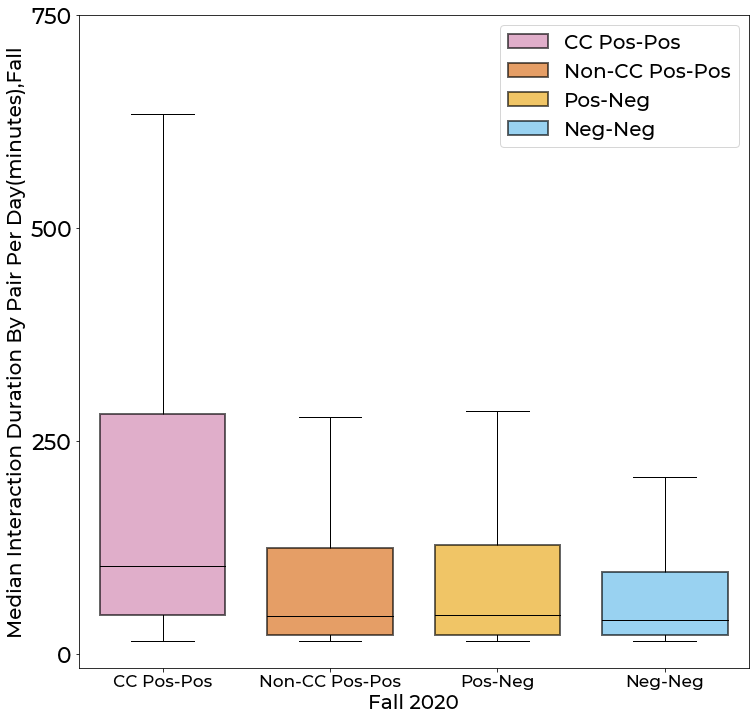

Fall 2020
median ct/ct median 104.0
median non/non median 45.0
median p/n median 46.0
median n/n median 40.0


In [ ]:
#running statistical tests and fall figs for median interaction time 

U1, ct_non = mannwhitneyu(ct_ct_median1, non_non_median1)
print("ct/ct-non/non",ct_non)

U1, ct_pn = mannwhitneyu(ct_ct_median1, p_n_median1)
print("ct/ct-pos/neg",ct_pn)

U1, ct_nn = mannwhitneyu(ct_ct_median1, n_n_median1)
print("ct/ct-n/n",ct_nn)

U1, pn_non = mannwhitneyu(p_n_median1, non_non_median1)
print("pos/neg-non/non",pn_non)

U1, nn_pn = mannwhitneyu(n_n_median1, p_n_median1)
print("neg/neg-pos/neg",ct_pn)


fig, ax = plt.subplots(figsize = (12,12))
bp1 = box_plot_no_fliers(ct_ct_median1,color_pallet[2],1)
bp2 = box_plot_no_fliers(non_non_median1,color_pallet[6],2)
bp3 = box_plot_no_fliers(p_n_median1,color_pallet[3],3)
bp4 = box_plot_no_fliers(n_n_median1,color_pallet[4],4)
#ax.set_ylim(0,2500)
ax.legend([bp1["boxes"][0], bp2["boxes"][0],bp3["boxes"][0], bp4["boxes"][0]],  ['CC Pos-Pos','Non-CC Pos-Pos','Pos-Neg','Neg-Neg'],fontsize = 20,frameon=True)
ax.set_xticks([1,2,3,4])
ax.set_yticks(np.arange(0,800,step =250))
ax.set_yticklabels(labels = np.arange(0,800,step =250),fontsize = 22)
ax.set_xticklabels(labels = ['CC Pos-Pos','Non-CC Pos-Pos','Pos-Neg','Neg-Neg'],fontsize = 17)
plt.grid(axis = 'x',visible = False)
ax.set_xlabel('Fall 2020',fontsize = 20)

ax.set_ylabel('Median Interaction Duration By Pair Per Day(minutes),Fall',fontsize = 20)
image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'Supp7D1.svg'
plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()


print('Fall 2020')
print("median ct/ct median", statistics.median(ct_ct_median1))
print("median non/non median", statistics.median(non_non_median1))
print("median p/n median", statistics.median(p_n_median1))
print("median n/n median", statistics.median(n_n_median1))

In [112]:
#back to peacock

In [ ]:
#dates of B.1.429.1 transmission:
# 2021-01-17 (10 days before first peacock) to 2021-03-12

In [113]:
#running social analysis of B.1.429.1 pairings (total interaction duration, median int duration, and node degree)

print('running')
pe_pe_sum = []
pe_n_sum = []
pe_pe_median = []
pe_n_median = []
pe_pe_ints = []
pe_n_ints = []
pe_p_sum = []
pe_p_median = []
pe_p_ints = []
p_p_sum = []
p_p_median = []
p_p_ints = []
node_degree = {}

for j in final_spring:
    j.columns = ['day','s1','s2','sum duration','median duration','num interactions']
    day = j['day'].iloc[0]
    if day >= '2021-01-17' and day <= '2021-03-12': #only running for 10 days prior to first peacock pos to last peacock pos
        print(day)
        g = nx.from_pandas_edgelist(j,'s1','s2',['sum duration','median duration','num interactions'], create_using = nx.Graph())
        rolling_positives = by_date_pos_list_spring_dict[str(day)]
        edges = list(g.edges(data = True))
        for x in edges:
            if (str(x[0]) in rolling_positives) and (str(x[0]) in peacock_IDs): 
                if (str(x[1]) in rolling_positives) and (str(x[1]) in peacock_IDs): #pea - pea
                    pe_pe_sum.append(x[2]['sum duration'])
                    pe_pe_median.append(x[2]['median duration'])
                    pe_pe_ints.append(x[2]['num interactions'])
                elif (str(x[1]) in rolling_positives) and (str(x[1]) not in peacock_IDs): #pea - p
                    pe_p_sum.append(x[2]['sum duration'])
                    pe_p_median.append(x[2]['median duration'])
                    pe_p_ints.append(x[2]['num interactions'])
                else:                                                               #pea - n
                    pe_n_sum.append(x[2]['sum duration'])
                    pe_n_median.append(x[2]['median duration'])
                    pe_n_ints.append(x[2]['num interactions'])
            if (str(x[1]) in rolling_positives) and (str(x[1]) in peacock_IDs): 
                if (str(x[0]) in rolling_positives) and (str(x[0]) not in peacock_IDs): #p - pea
                    pe_p_sum.append(x[2]['sum duration'])
                    pe_p_median.append(x[2]['median duration'])
                    pe_p_ints.append(x[2]['num interactions'])
                elif (str(x[0]) not in rolling_positives) and (str(x[0]) not in peacock_IDs):   #n - pea
                    pe_n_sum.append(x[2]['sum duration'])
                    pe_n_median.append(x[2]['median duration'])
                    pe_n_ints.append(x[2]['num interactions'])
            if (str(x[0]) in rolling_positives) and (str(x[0]) not in peacock_IDs): 
                if (str(x[1]) in rolling_positives) and (str(x[1]) not in peacock_IDs): #p - p
                    p_p_sum.append(x[2]['sum duration'])
                    p_p_median.append(x[2]['median duration'])
                    p_p_ints.append(x[2]['num interactions'])
                
        for node in g:
            if node in peacock_IDs and node in rolling_positives:
                degree = g.degree(node)
                if node in node_degree:
                    node_degree[node].append(degree)
                else:
                    node_degree[node] = [degree]
            if node not in peacock_IDs and node in rolling_positives:
                degree = g.degree(node)
                if node in node_degree:
                    node_degree[node].append(degree)
                else:
                    node_degree[node] = [degree]
        


running
2021-01-19
2021-01-20
2021-01-21
2021-01-22
2021-01-23
2021-01-24
2021-01-25
2021-01-26
2021-01-27
2021-01-28
2021-01-29
2021-01-30
2021-01-31
2021-02-01
2021-02-02
2021-02-03
2021-02-04
2021-02-05
2021-02-06
2021-02-07
2021-02-08
2021-02-09
2021-02-10
2021-02-11
2021-02-12
2021-02-13
2021-02-14
2021-02-15
2021-02-16
2021-02-17
2021-02-18
2021-02-19
2021-02-20
2021-02-21
2021-02-22
2021-02-23
2021-02-24
2021-02-25
2021-02-26
2021-02-27
2021-02-28
2021-03-01
2021-03-02
2021-03-03
2021-03-04
2021-03-05
2021-03-06
2021-03-07
2021-03-08
2021-03-09
2021-03-10
2021-03-11
2021-03-12


In [114]:
#assesing statistical test of node degree for peacock to non peacock during peacock transmission period

node_deg_peacock_group = []
node_deg_positive_group = []

for item,value in node_degree.items():
    if item in list(peacock_IDs):
        node_deg_peacock_group.append(np.median(value))
    else: node_deg_positive_group.append(np.median(value))
   
        
U1, peacock_pos = mannwhitneyu(node_deg_peacock_group, node_deg_positive_group)
print('mann whit',peacock_pos)
print("median pos sem", statistics.median(node_deg_peacock_group))
print("median neg sem",statistics.median(node_deg_positive_group))
print()

mann whit 0.06651001966301082
median pos sem 73.5
median neg sem 55.0



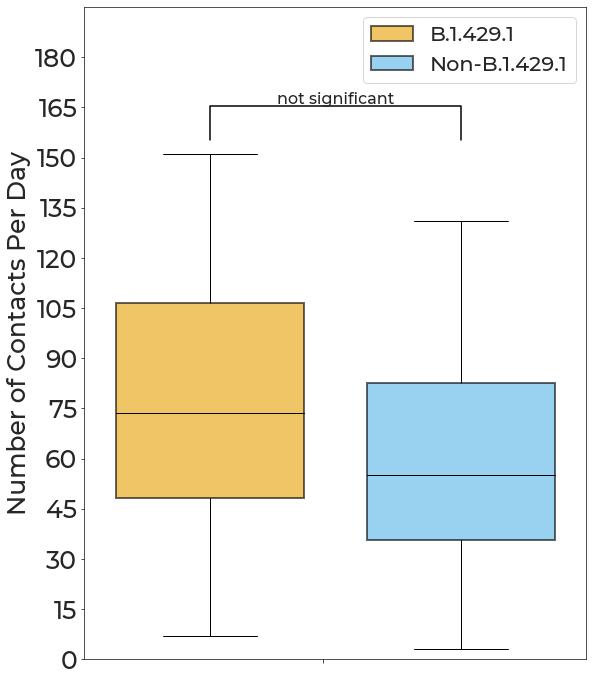

In [116]:
#creating plot for node degree(num contacts) for peacock period

fig, ax = plt.subplots(figsize = (9,12))
bp1 = box_plot_no_fliers(node_deg_peacock_group,color_pallet[3],1)
bp2 = box_plot_no_fliers(node_deg_positive_group,color_pallet[4],2)
ax.legend([bp1["boxes"][0], bp2["boxes"][0]],  ['B.1.429.1','Non-B.1.429.1'],fontsize = 21,loc = 'upper right',frameon = True)
ax.set_xticks([1.45])
ax.set_xticklabels(labels = [''],fontsize = 25)
ax.set_yticks(np.arange(0,185,step =15))
ax.set_yticklabels(labels = np.arange(0,185,step =15),fontsize = 25)
plt.grid(axis = 'x',visible = False)
plt.grid(axis = 'y',visible = False)
ax.set_ylabel('Number of Contacts Per Day',fontsize = 25)
barplot_annotate_brackets(0,1,peacock_pos,[1,2],[145,1],maxasterix=3,fs = 16)
ax.set_ylim(0,195)
image_format = 'svg' 
image_name = 'Supp12NEW_degree.svg'
plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()

pe-n 2.9270832238577537e-09
pe-p 0.5075239889905794
p-n 1.963647994100521e-18
pp-pepe 0.5256023845697639
pp-pen 1.4251839523361805e-30
pp-pep 0.702264378999121


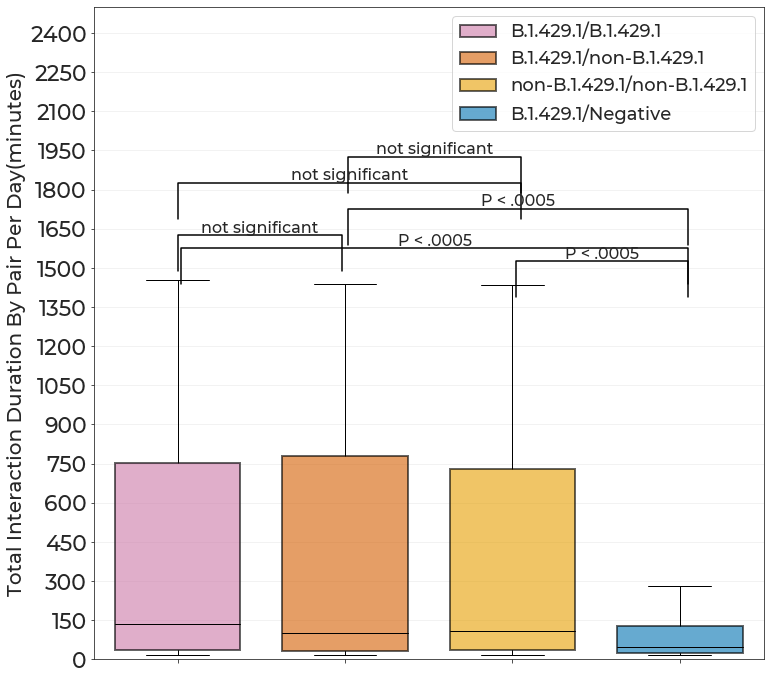

spring 2021
median pea-pea sum 135.0
median pea-n sum 47.0
median pea-p sum 99.0
median p-p sum 110.0


In [119]:
#creating figs and running statistical tests on total int time

U1, p_pe_n = mannwhitneyu(pe_pe_sum, pe_n_sum)
print("pe-n",p_pe_n)
U1, p_pe_p = mannwhitneyu(pe_pe_sum, pe_p_sum)
print("pe-p",p_pe_p)
U1, p_p_n = mannwhitneyu(pe_n_sum, pe_p_sum)
print("p-n",p_p_n)

U1, pp_pepe = mannwhitneyu(p_p_sum, pe_pe_sum)
print("pp-pepe",pp_pepe)
U1, pp_pen = mannwhitneyu(p_p_sum, pe_n_sum)
print("pp-pen",pp_pen)
U1, pp_pep = mannwhitneyu(p_p_sum, pe_p_sum)
print("pp-pep",pp_pep)

fig, ax = plt.subplots(figsize = (12,12))
bp1 = box_plot_no_fliers(pe_pe_sum,color_pallet[2],1)
bp2 = box_plot_no_fliers(pe_p_sum,color_pallet[6],2)
bp3 = box_plot_no_fliers(p_p_sum,color_pallet[3],3)
bp4 = box_plot_no_fliers(pe_n_sum,color_pallet[5],4)

ax.legend([bp1["boxes"][0], bp2["boxes"][0],bp3["boxes"][0],bp4["boxes"][0]],  ['B.1.429.1/B.1.429.1','B.1.429.1/non-B.1.429.1','non-B.1.429.1/non-B.1.429.1','B.1.429.1/Negative'],fontsize = 18,loc = 'upper right',frameon=True)
ax.set_xticks([1,2,3,4])
ax.set_yticks(np.arange(0,2500,step =150))
ax.set_ylim(0,2500)
ax.set_yticklabels(labels = np.arange(0,2500,step =150),fontsize = 22)
ax.set_xticklabels(labels =  ['','','',''],fontsize = 17)
plt.grid(axis = 'x',visible = False)
plt.grid(axis = 'y',alpha = .3)
ax.set_ylabel('Total Interaction Duration By Pair Per Day(minutes)',fontsize = 20)
barplot_annotate_brackets(0,1,p_pe_p,[1,1.98],[1350,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_p_n,[2.02,4.05],[1450,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_pe_n,[1.02,4.05],[1300,5],maxasterix=3,fs = 16)

barplot_annotate_brackets(0,1,pp_pepe,[1,3.05],[1550,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,pp_pen,[3.02,4.05],[1250,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,pp_pep,[2.02,3.05],[1650,5],maxasterix=3,fs = 16)

image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'Supp12NEW_total.svg'
plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()

print('spring 2021')
print("median pea-pea sum", statistics.median(pe_pe_sum))
print("median pea-n sum", statistics.median(pe_n_sum))
print("median pea-p sum", statistics.median(pe_p_sum))
print("median p-p sum", statistics.median(p_p_sum))



pe-n 0.005234484217349386
pe-p 0.6366419274526016
p-n 1.4826215275393153e-08
pp-pepe 0.27869110088770443
pp-pen 1.0105456535473823e-15
pp-pep 0.3516160693829009


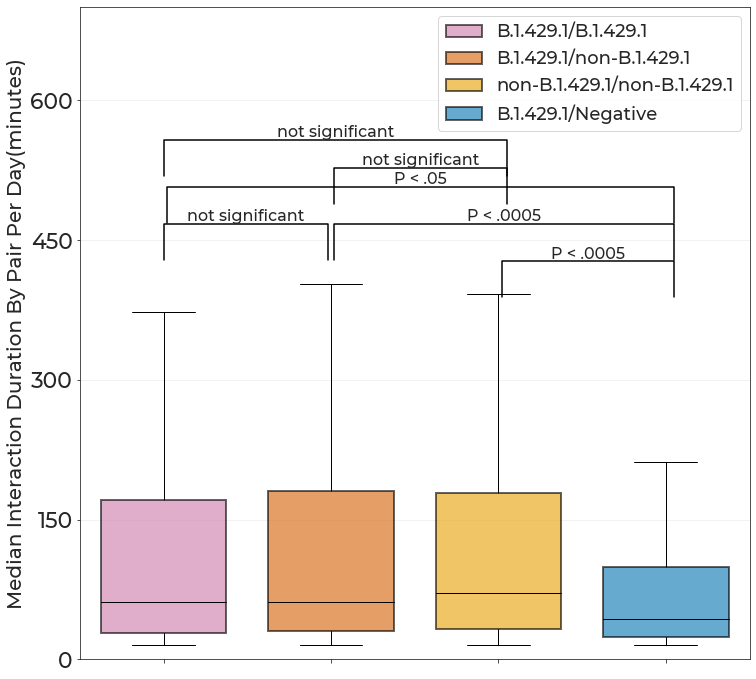

spring 2021
median pea-pea median 61.0
median pea-n median 43.0
median pea-p median 61.25
median p-p median 71.0


In [120]:
#creating fig and running statistical tests on median int time

U1, p_pe_n = mannwhitneyu(pe_pe_median, pe_n_median)
print("pe-n",p_pe_n)
U1, p_pe_p = mannwhitneyu(pe_pe_median, pe_p_median)
print("pe-p",p_pe_p)
U1, p_p_n = mannwhitneyu(pe_n_median, pe_p_median)
print("p-n",p_p_n)

U1, pp_pepe = mannwhitneyu(p_p_median, pe_pe_median)
print("pp-pepe",pp_pepe)
U1, pp_pen = mannwhitneyu(p_p_median, pe_n_median)
print("pp-pen",pp_pen)
U1, pp_pep = mannwhitneyu(p_p_median, pe_p_median)
print("pp-pep",pp_pep)

fig, ax = plt.subplots(figsize = (12,12))
bp1 = box_plot_no_fliers(pe_pe_median,color_pallet[2],1)
bp2 = box_plot_no_fliers(pe_p_median,color_pallet[6],2)
bp3 = box_plot_no_fliers(p_p_median,color_pallet[3],3)
bp4 = box_plot_no_fliers(pe_n_median,color_pallet[5],4)

ax.legend([bp1["boxes"][0], bp2["boxes"][0],bp3["boxes"][0],bp4["boxes"][0]],  ['B.1.429.1/B.1.429.1','B.1.429.1/non-B.1.429.1','non-B.1.429.1/non-B.1.429.1','B.1.429.1/Negative'],fontsize = 18,frameon=True,loc = 'upper right')
ax.set_xticks([1,2,3,4])
ax.set_yticks(np.arange(0,2500,step =150))
ax.set_ylim(0,700)
ax.set_yticklabels(labels = np.arange(0,2500,step =150),fontsize = 22)
ax.set_xticklabels(labels =  ['','','',''],fontsize = 17)
plt.grid(axis = 'x',visible = False)
plt.grid(axis = 'y',alpha = .3)
ax.set_ylabel('Median Interaction Duration By Pair Per Day(minutes)',fontsize = 20)
barplot_annotate_brackets(0,1,p_pe_p,[1,1.98],[390,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_p_n,[2.02,4.05],[390,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,p_pe_n,[1.02,4.05],[430,5],maxasterix=3,fs = 16)

barplot_annotate_brackets(0,1,pp_pepe,[1,3.05],[480,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,pp_pen,[3.02,4.05],[350,5],maxasterix=3,fs = 16)
barplot_annotate_brackets(0,1,pp_pep,[2.02,3.05],[450,5],maxasterix=3,fs = 16)

image_format = 'svg' # e.g .png, .svg, etc.
image_name = 'Supp12NEW_median.svg'
plt.savefig(image_name, format=image_format, dpi=1200)
plt.show()

print('spring 2021')
print("median pea-pea median", statistics.median(pe_pe_median))
print("median pea-n median", statistics.median(pe_n_median))
print("median pea-p median", statistics.median(pe_p_median))
print("median p-p median", statistics.median(p_p_median))
